In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer
import ast
import DSA
import copy
from notebooks.utils_rnn import *
%load_ext autoreload
%autoreload 2


### Load config

In [2]:
config = load_config("../config.yaml")
taskset = "PDM"

In [3]:
# Define font sizes and styles for consistency
SIZE_DEFAULT = 6
SIZE_LARGE = 8
plt.rc("font", family="Arial")
plt.rc("font", weight="normal")
plt.rc("font", size=SIZE_DEFAULT)
plt.rc("axes", titlesize=SIZE_LARGE)
plt.rc("axes", labelsize=SIZE_LARGE)
plt.rc("xtick", labelsize=SIZE_DEFAULT)
plt.rc("ytick", labelsize=SIZE_DEFAULT)

### Get dissimilarities

#### Computation dynamics

In [4]:
path = f"../data/dissimilarities/{taskset}/"
df = get_dataframe(path, taskset)
df_selected, models_trained_per_group = select_df(df)



In [5]:
group_pairs = find_group_pairs(config, taskset)
dissimilarities_per_shared_task = dissimilarities_per_percentage_of_shared_task(group_pairs, df_selected)

#### Learning dynamics

For now, only analysis for pretrain_frozen against pretrain_unfrozen

In [6]:
dissimilarities_groups, groups_training = get_dissimilarities_groups(taskset, models_trained_per_group)

/Users/qguilhot/Library/Mobile Documents/com~apple~CloudDocs/ETHZ/RepAL/notebooks/utils_rnn.py:802: RuntimeWarning: Mean of empty slice
  np.nanmean(dissimilarities_interpolated[measure][group]),
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/repal-8PB6Q6y1-py3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


dsa
5
5


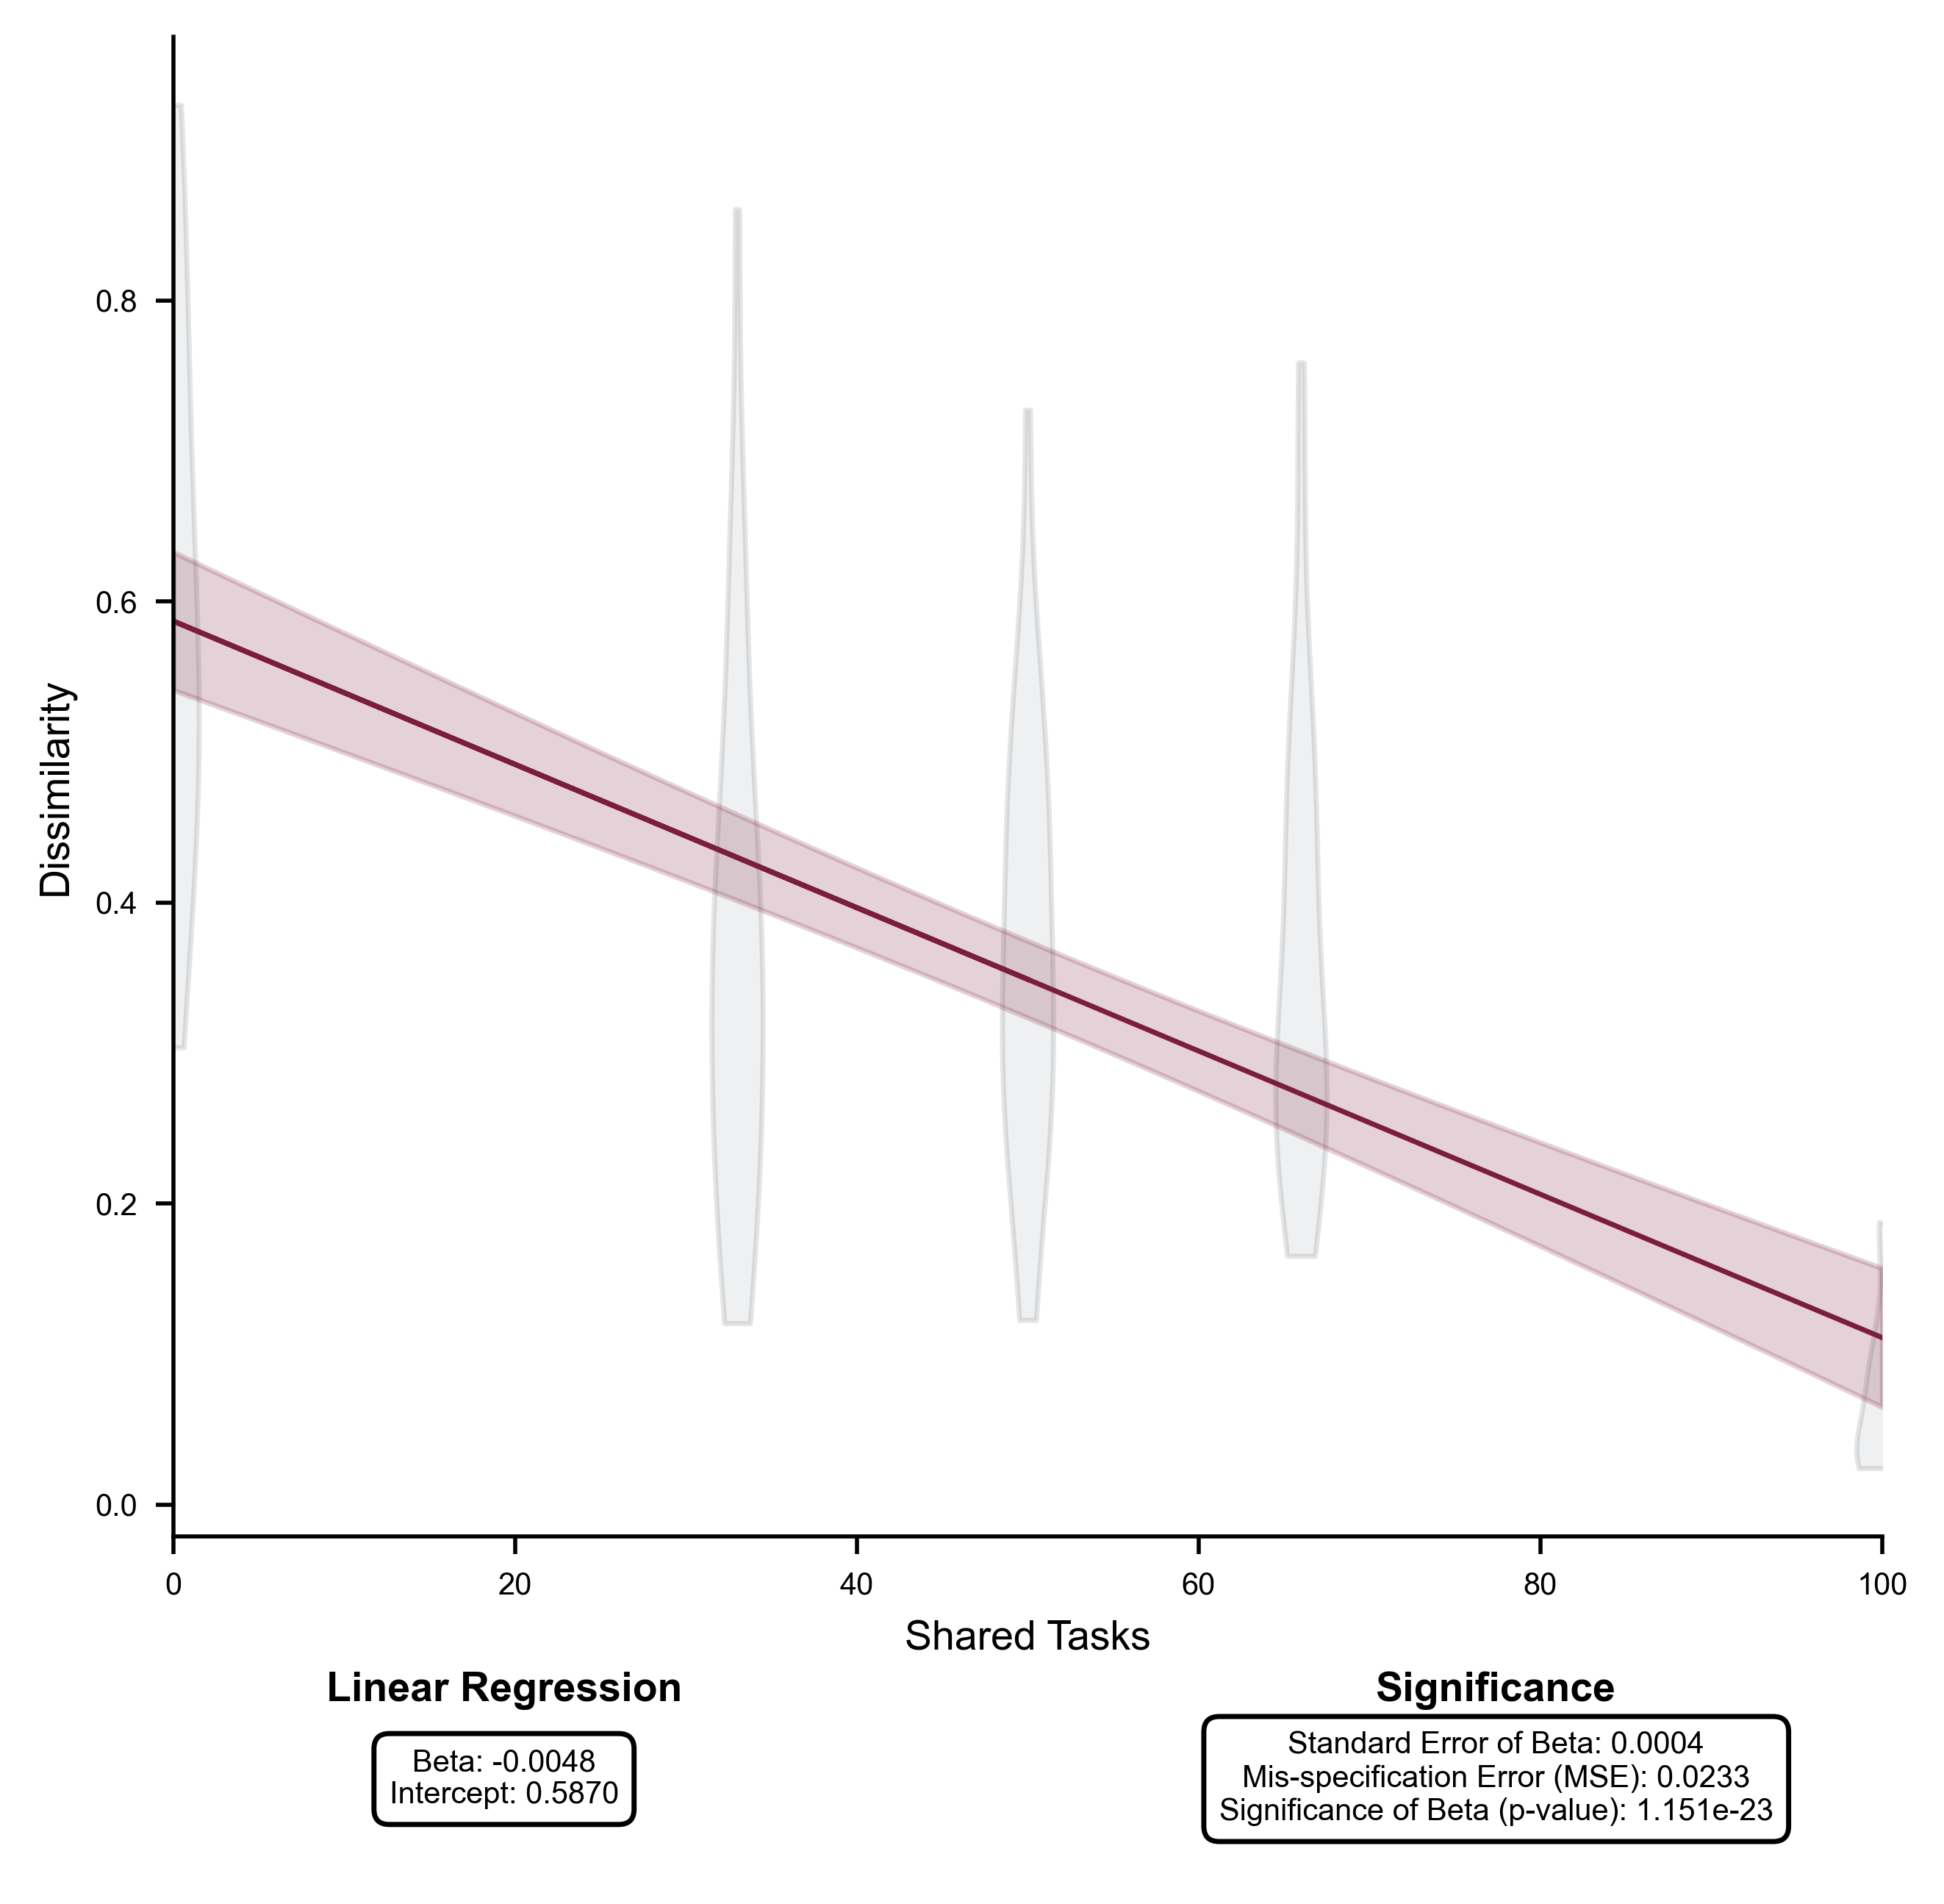

cka
5
5


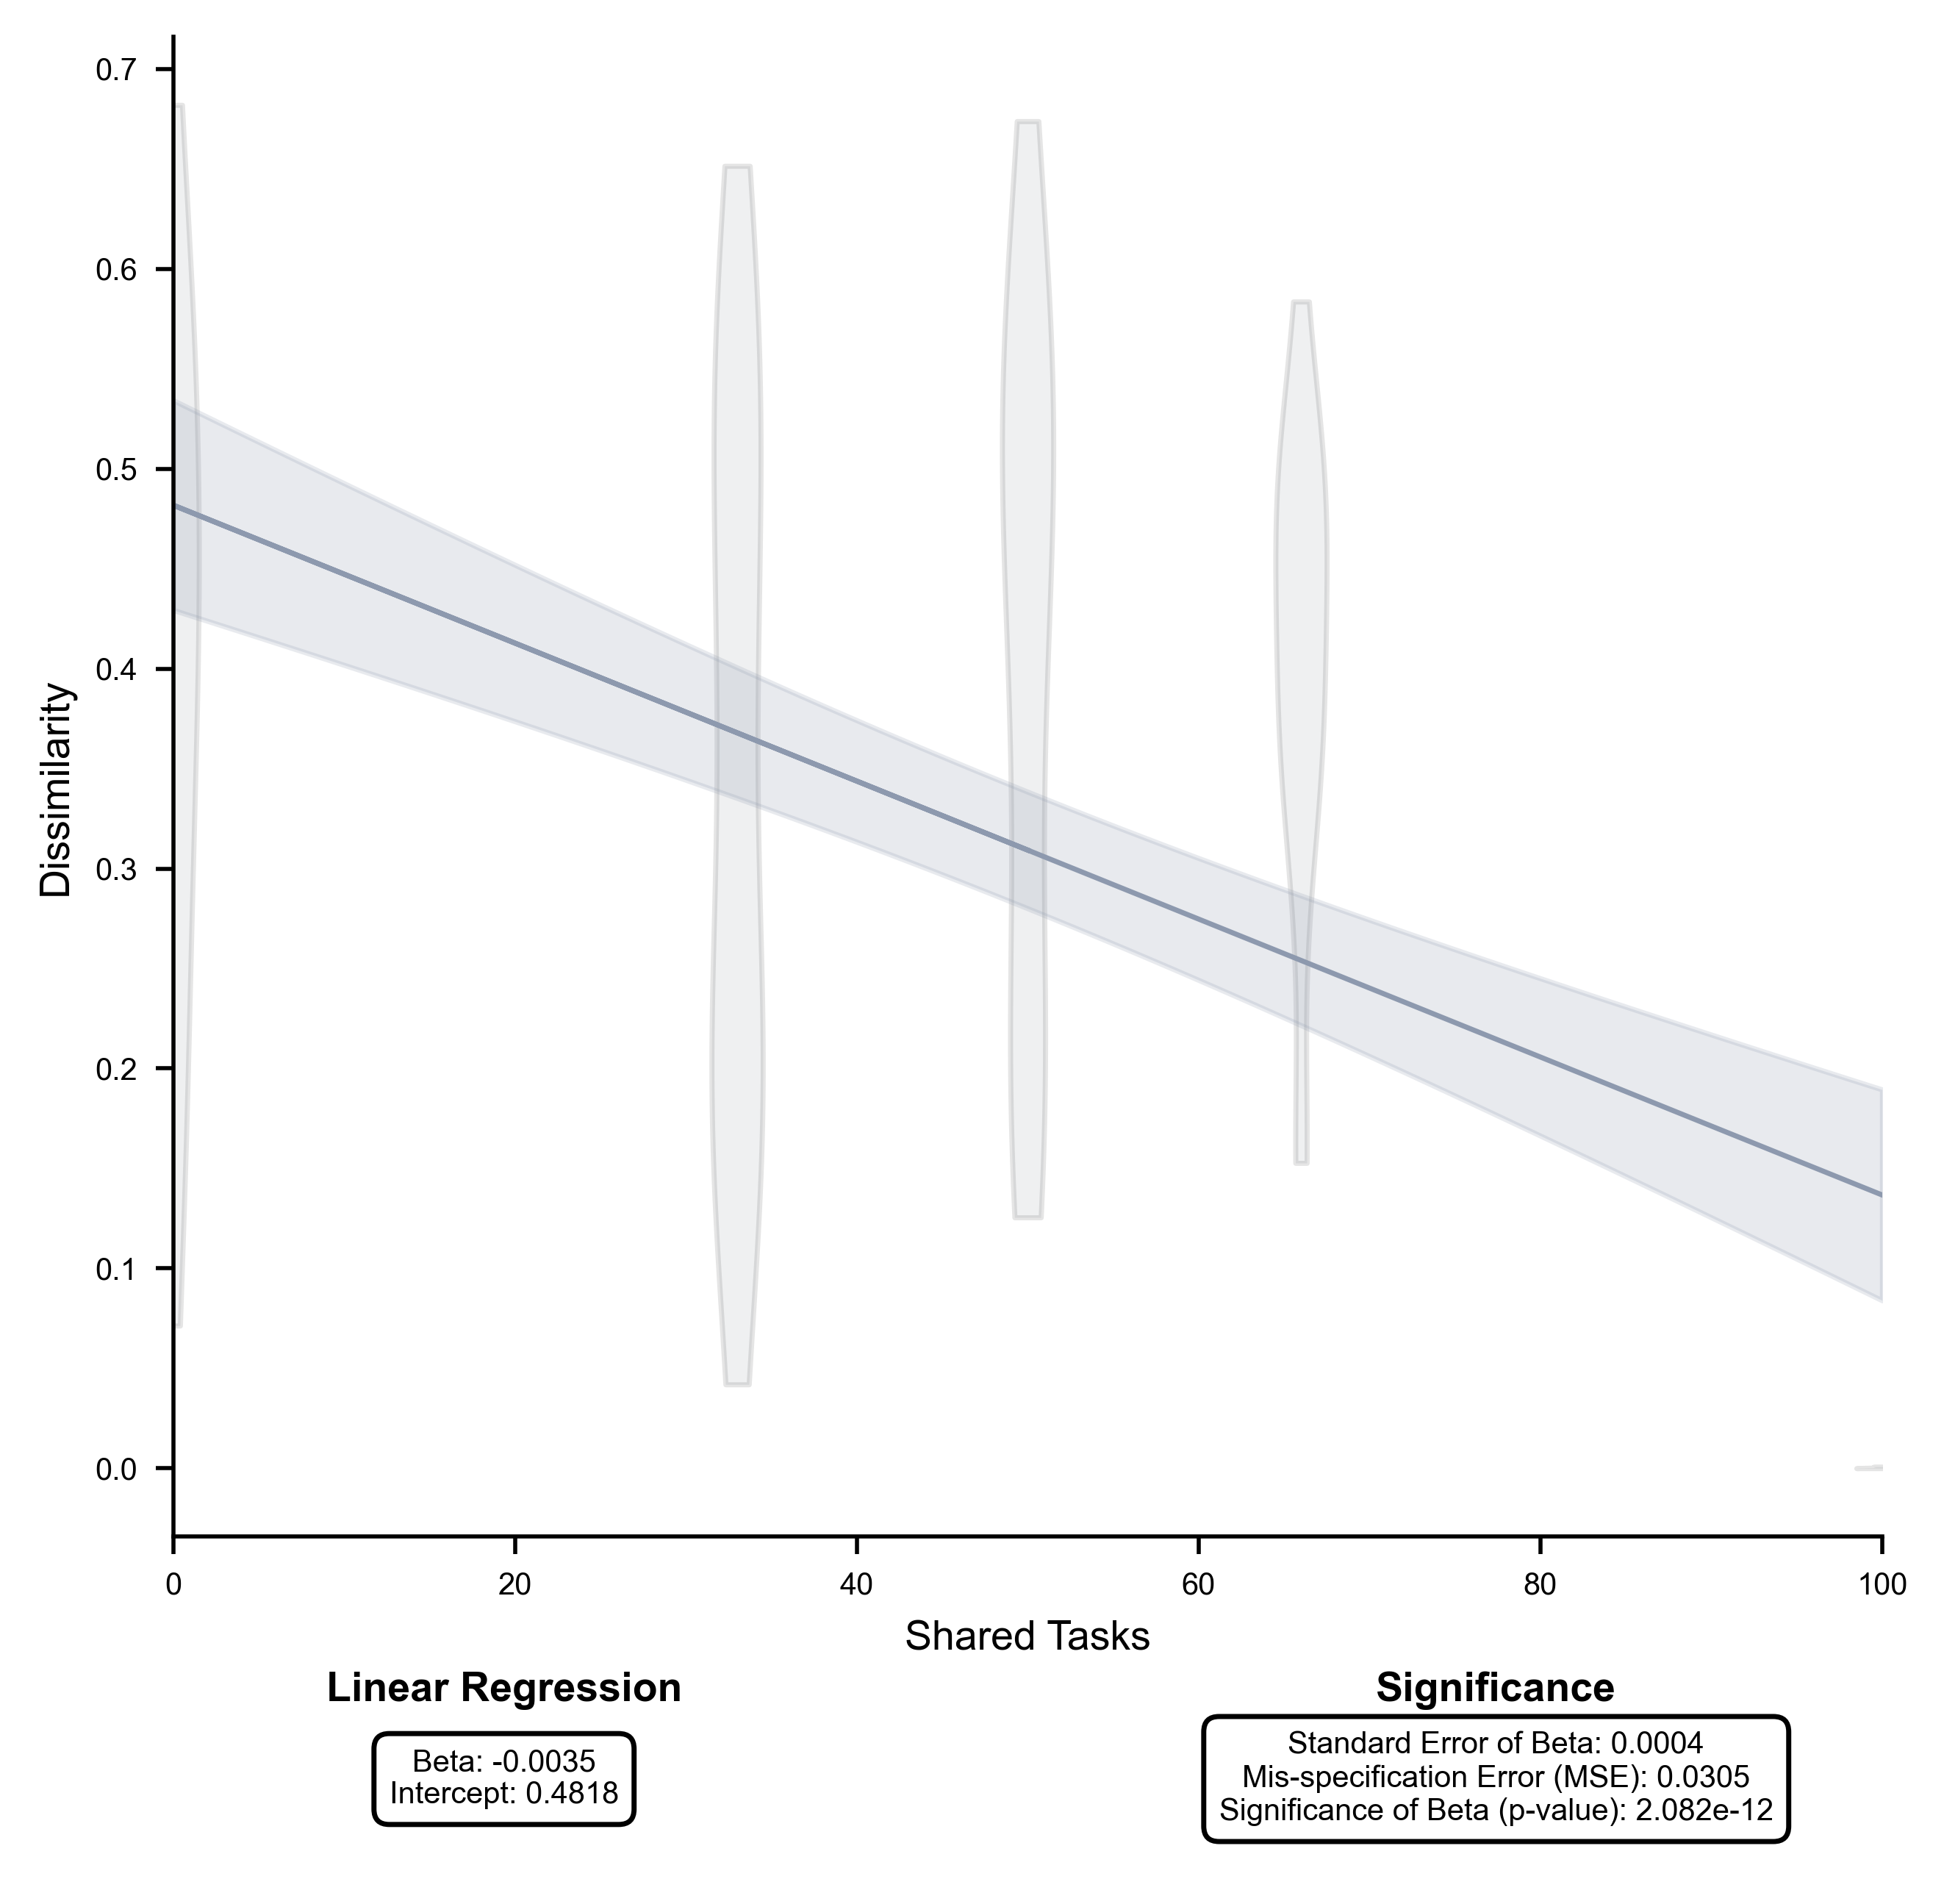

procrustes
5
5


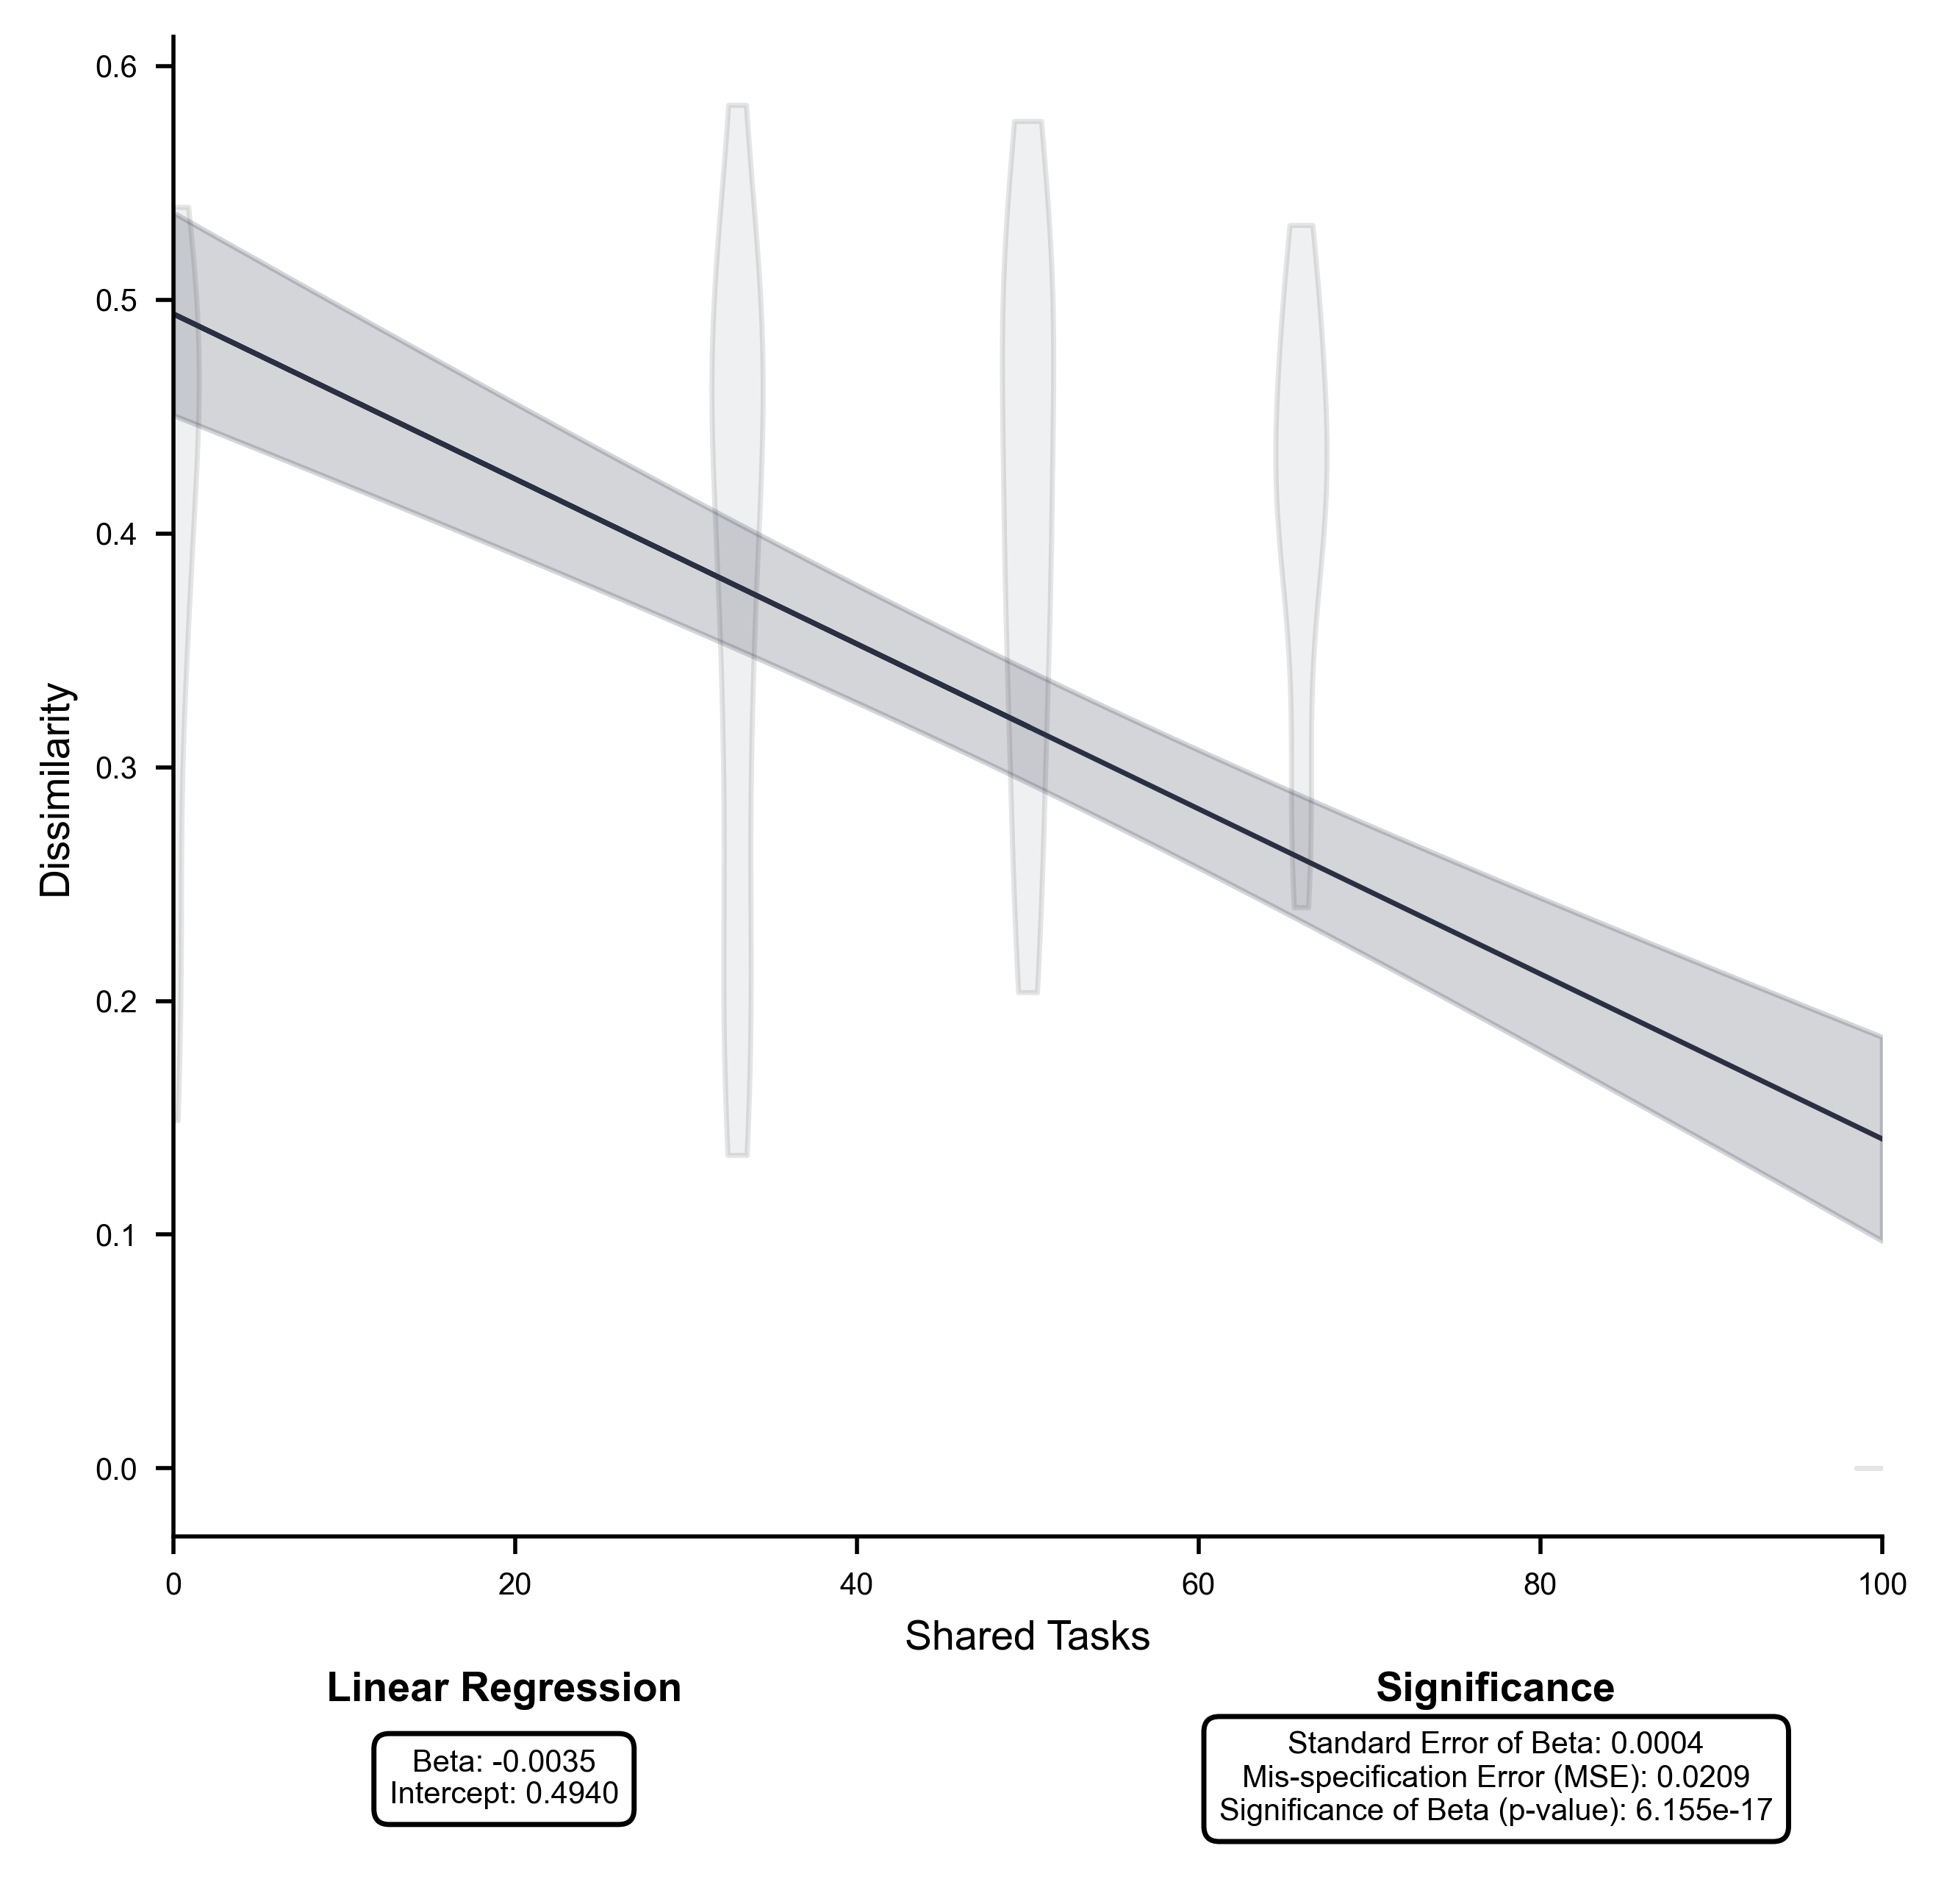

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats

# Iterate over each measure to compute linear regression and uncertainty
for measure in dissimilarities_per_shared_task:
    X = []  # Store shared_tasks as X
    y = []  # Store dissimilarities as y
    print(measure)

    # Aggregate all (shared_task, dissimilarity) pairs across all models
    observations = []
    positions = []
    for shared_tasks, models_data in dissimilarities_per_shared_task[measure].items():
        dissimilarities = []
        for model, dissimilarity_list in models_data.items():
            dissimilarity = dissimilarity_list[0]  # Extract single dissimilarity value
            X.append(shared_tasks)
            y.append(dissimilarity)
            dissimilarities.append(dissimilarity)
        observations.append(dissimilarities)
        positions.append(shared_tasks)
    print(len(positions))
    print(len(observations))

    # Convert to numpy arrays for linear regression
    X = np.array(X).reshape(-1, 1)  # Reshape to a 2D array
    y = np.array(y)

    # Perform linear regression
    model = LinearRegression()
    model.fit(X, y)

    # Get the slope (beta) and intercept
    beta = model.coef_[0]
    intercept = model.intercept_

    # Predict y values for the regression line
    y_pred = model.predict(X)

    # Compute residuals and their variance
    residuals = y - y_pred
    residual_variance = np.var(residuals, ddof=2)

    # Compute variance of X
    X_mean = np.mean(X)
    X_variance = np.sum((X - X_mean) ** 2)

    # Standard error of the slope (beta)
    standard_error_beta = np.sqrt(residual_variance / X_variance)

    # T-statistic and p-value
    t_statistic = beta / standard_error_beta
    df = len(X) - 2  # degrees of freedom
    p_value = 2 * stats.t.sf(np.abs(t_statistic), df)

    # Mis-specification error (MSE)
    mse = np.mean(residuals**2)

    # Confidence interval for the regression line
    X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred_range = model.predict(X_range)
    se_line = np.sqrt(
        residual_variance * (1 / len(X) + (X_range - X_mean) ** 2 / X_variance)
    )
    ci_upper = y_pred_range.flatten() + 1.96 * se_line.flatten()
    ci_lower = y_pred_range.flatten() - 1.96 * se_line.flatten()

    # Create the main plot and space for two boxes below
    fig, ax_main = plt.subplots(figsize=(6, 6), dpi=500)

    # Main plot: scatter plot of observations and the regression line
    parts = ax_main.violinplot(
        observations,
        positions,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=3,
    )
    for pc in parts["bodies"]:
        pc.set_facecolor("#696D7D")
        pc.set_edgecolor("black")
        pc.set_alpha(0.1)
    ax_main.plot(
        X,
        y_pred,
        "-",
        color=color_mapping_metrics[measure],
        linewidth=1,
    )
    ax_main.fill_between(
        X_range.flatten(),
        ci_lower,
        ci_upper,
        color=color_mapping_metrics[measure],
        alpha=0.2,
    )

    # Set axis labels and title for the main plot
    ax_main.set_xlabel("Shared Tasks")
    ax_main.set_ylabel(f"Dissimilarity")
    ax_main.set_xlim(0,100)
    # Customize axis limits and hide the top and right spines
    ax_main.spines["right"].set_visible(False)
    ax_main.spines["top"].set_visible(False)
    ax_main.spines["left"].set_visible(True)  # Show the left y-axis
    ax_main.yaxis.set_ticks_position("left")
    ax_main.xaxis.set_ticks_position("bottom")

    # Remove legend if it has no labels
    if ax_main.get_legend_handles_labels() != ([], []):
        ax_main.legend()
    ax_main.grid(False)

    # Create space for the metrics below the main plot
    fig.subplots_adjust(bottom=0.2)  # Adjust bottom space to fit the boxes

    # Add the boxes below the main plot
    # Left box for "Linear Regression"
    ax_lr = fig.add_axes([0.1, 0.05, 0.35, 0.2])  # [left, bottom, width, height]
    ax_lr.axis("off")  # Turn off axes for the metrics plot
    ax_lr.text(
        0.5,
        0.4,
        "Linear Regression",
        ha="center",
        va="center",
        fontsize=SIZE_LARGE,
        fontweight="bold",
    )
    ax_lr.text(
        0.5,
        0.2,
        f"Beta: {beta:.4f}\nIntercept: {intercept:.4f}",
        ha="center",
        va="center",
        fontsize=SIZE_DEFAULT,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
    )

    # Right box for "Significance"
    ax_significance = fig.add_axes(
        [0.55, 0.05, 0.35, 0.2]
    )  # [left, bottom, width, height]
    ax_significance.axis("off")  # Turn off axes for the metrics plot
    ax_significance.text(
        0.5,
        0.4,
        "Significance",
        ha="center",
        va="center",
        fontsize=SIZE_LARGE,
        fontweight="bold",
    )
    ax_significance.text(
        0.5,
        0.2,
        (
            f"Standard Error of Beta: {standard_error_beta:.4f}\n"
            f"Mis-specification Error (MSE): {mse:.4f}\n"
            f"Significance of Beta (p-value): {p_value:.4g}"
        ),
        ha="center",
        va="center",
        fontsize=SIZE_DEFAULT,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
    )

    # Show the plot
    plt.show()

['', '_pretrain_basic_frozen']


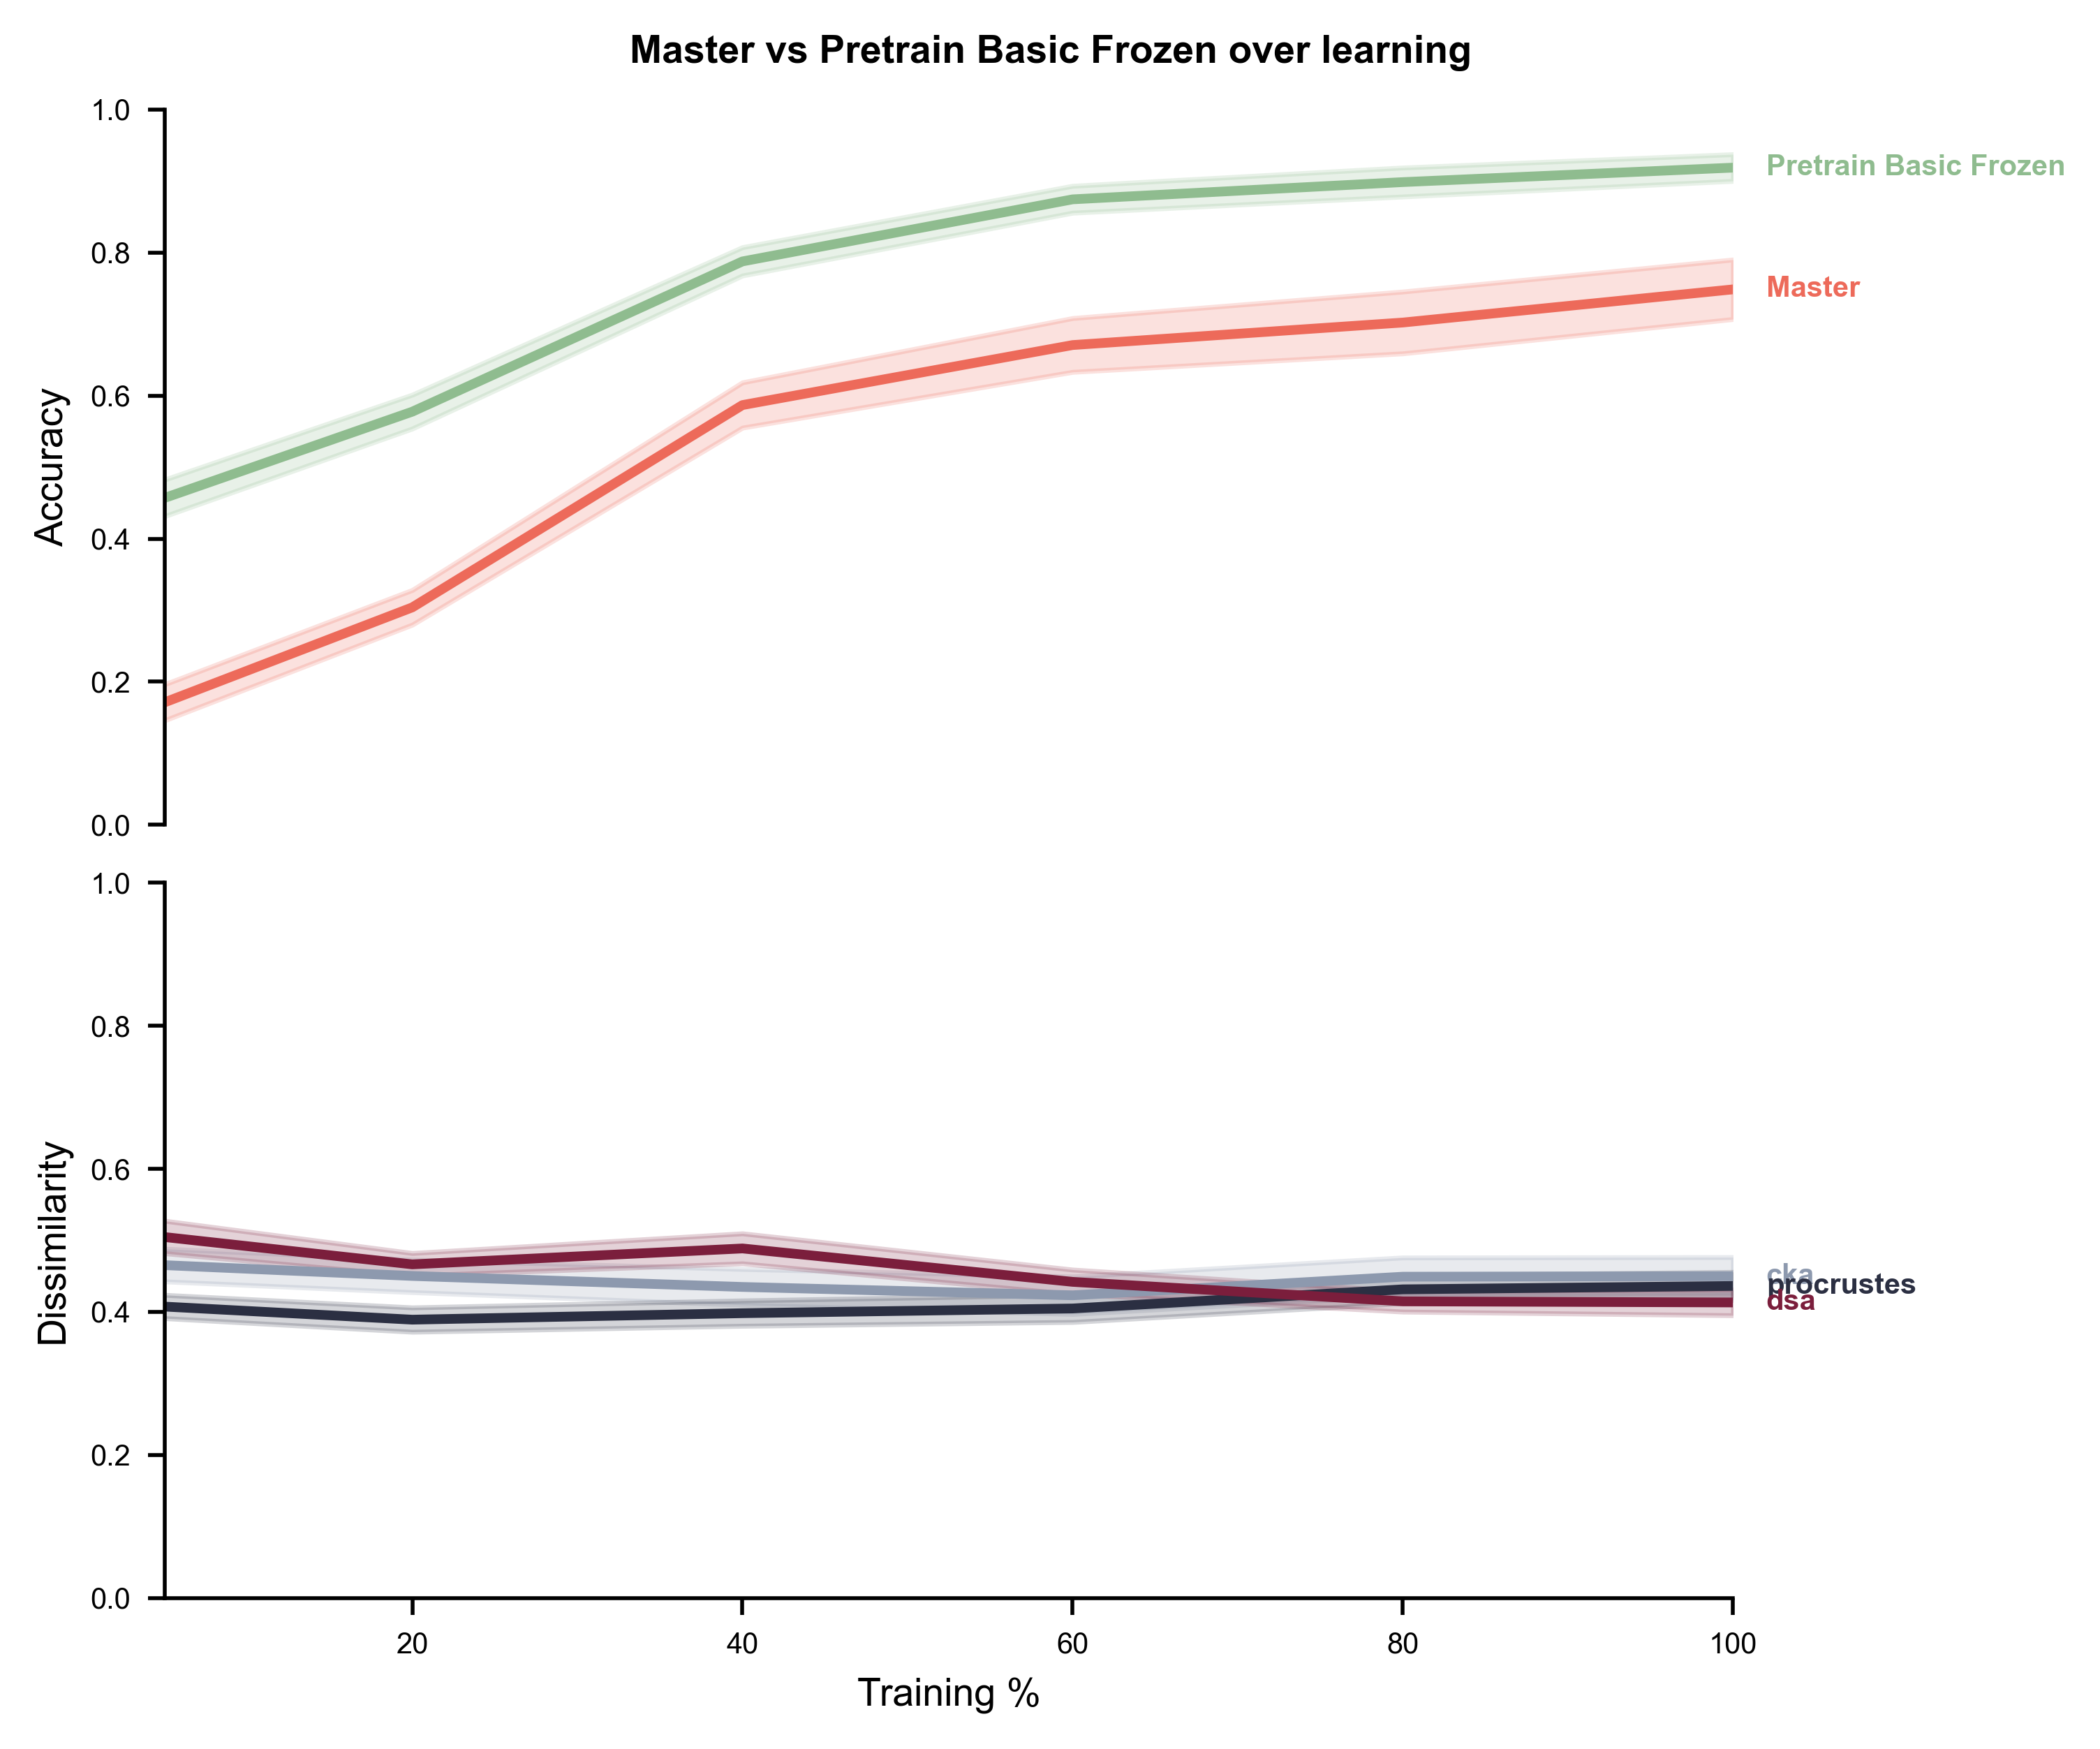

['pretrain_frozen_', '']


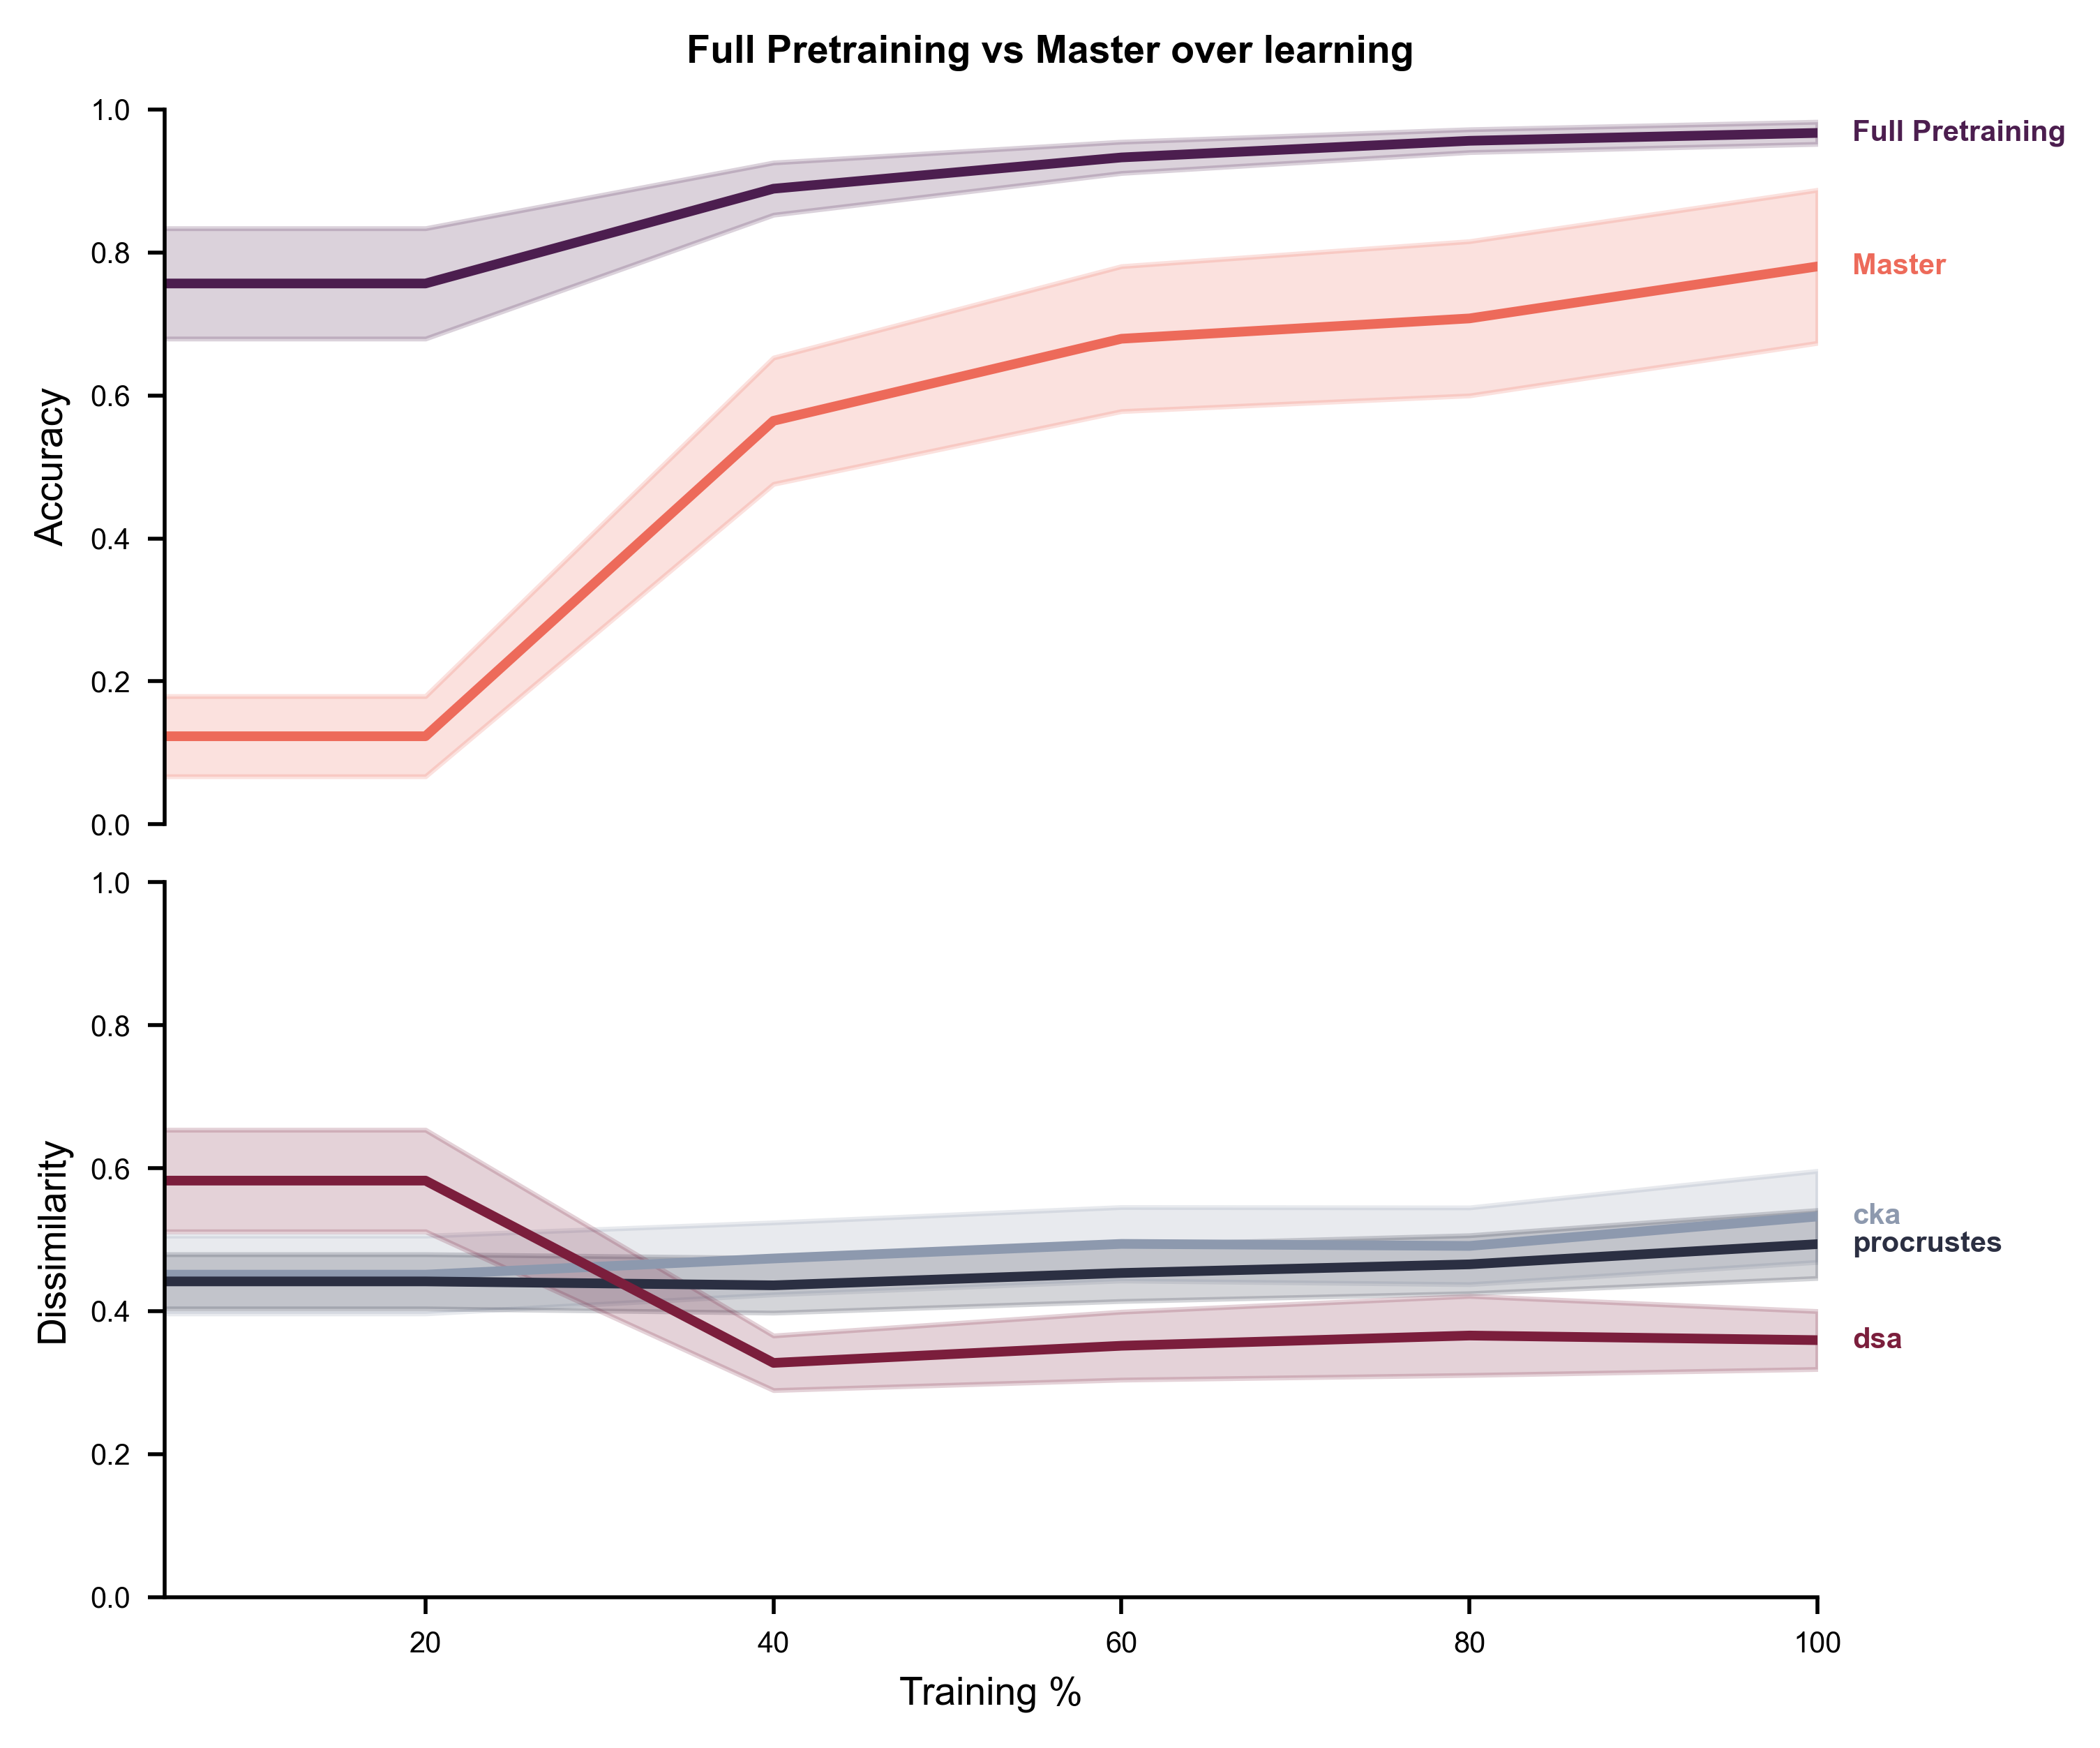

['', '_pretrain_delay_frozen']


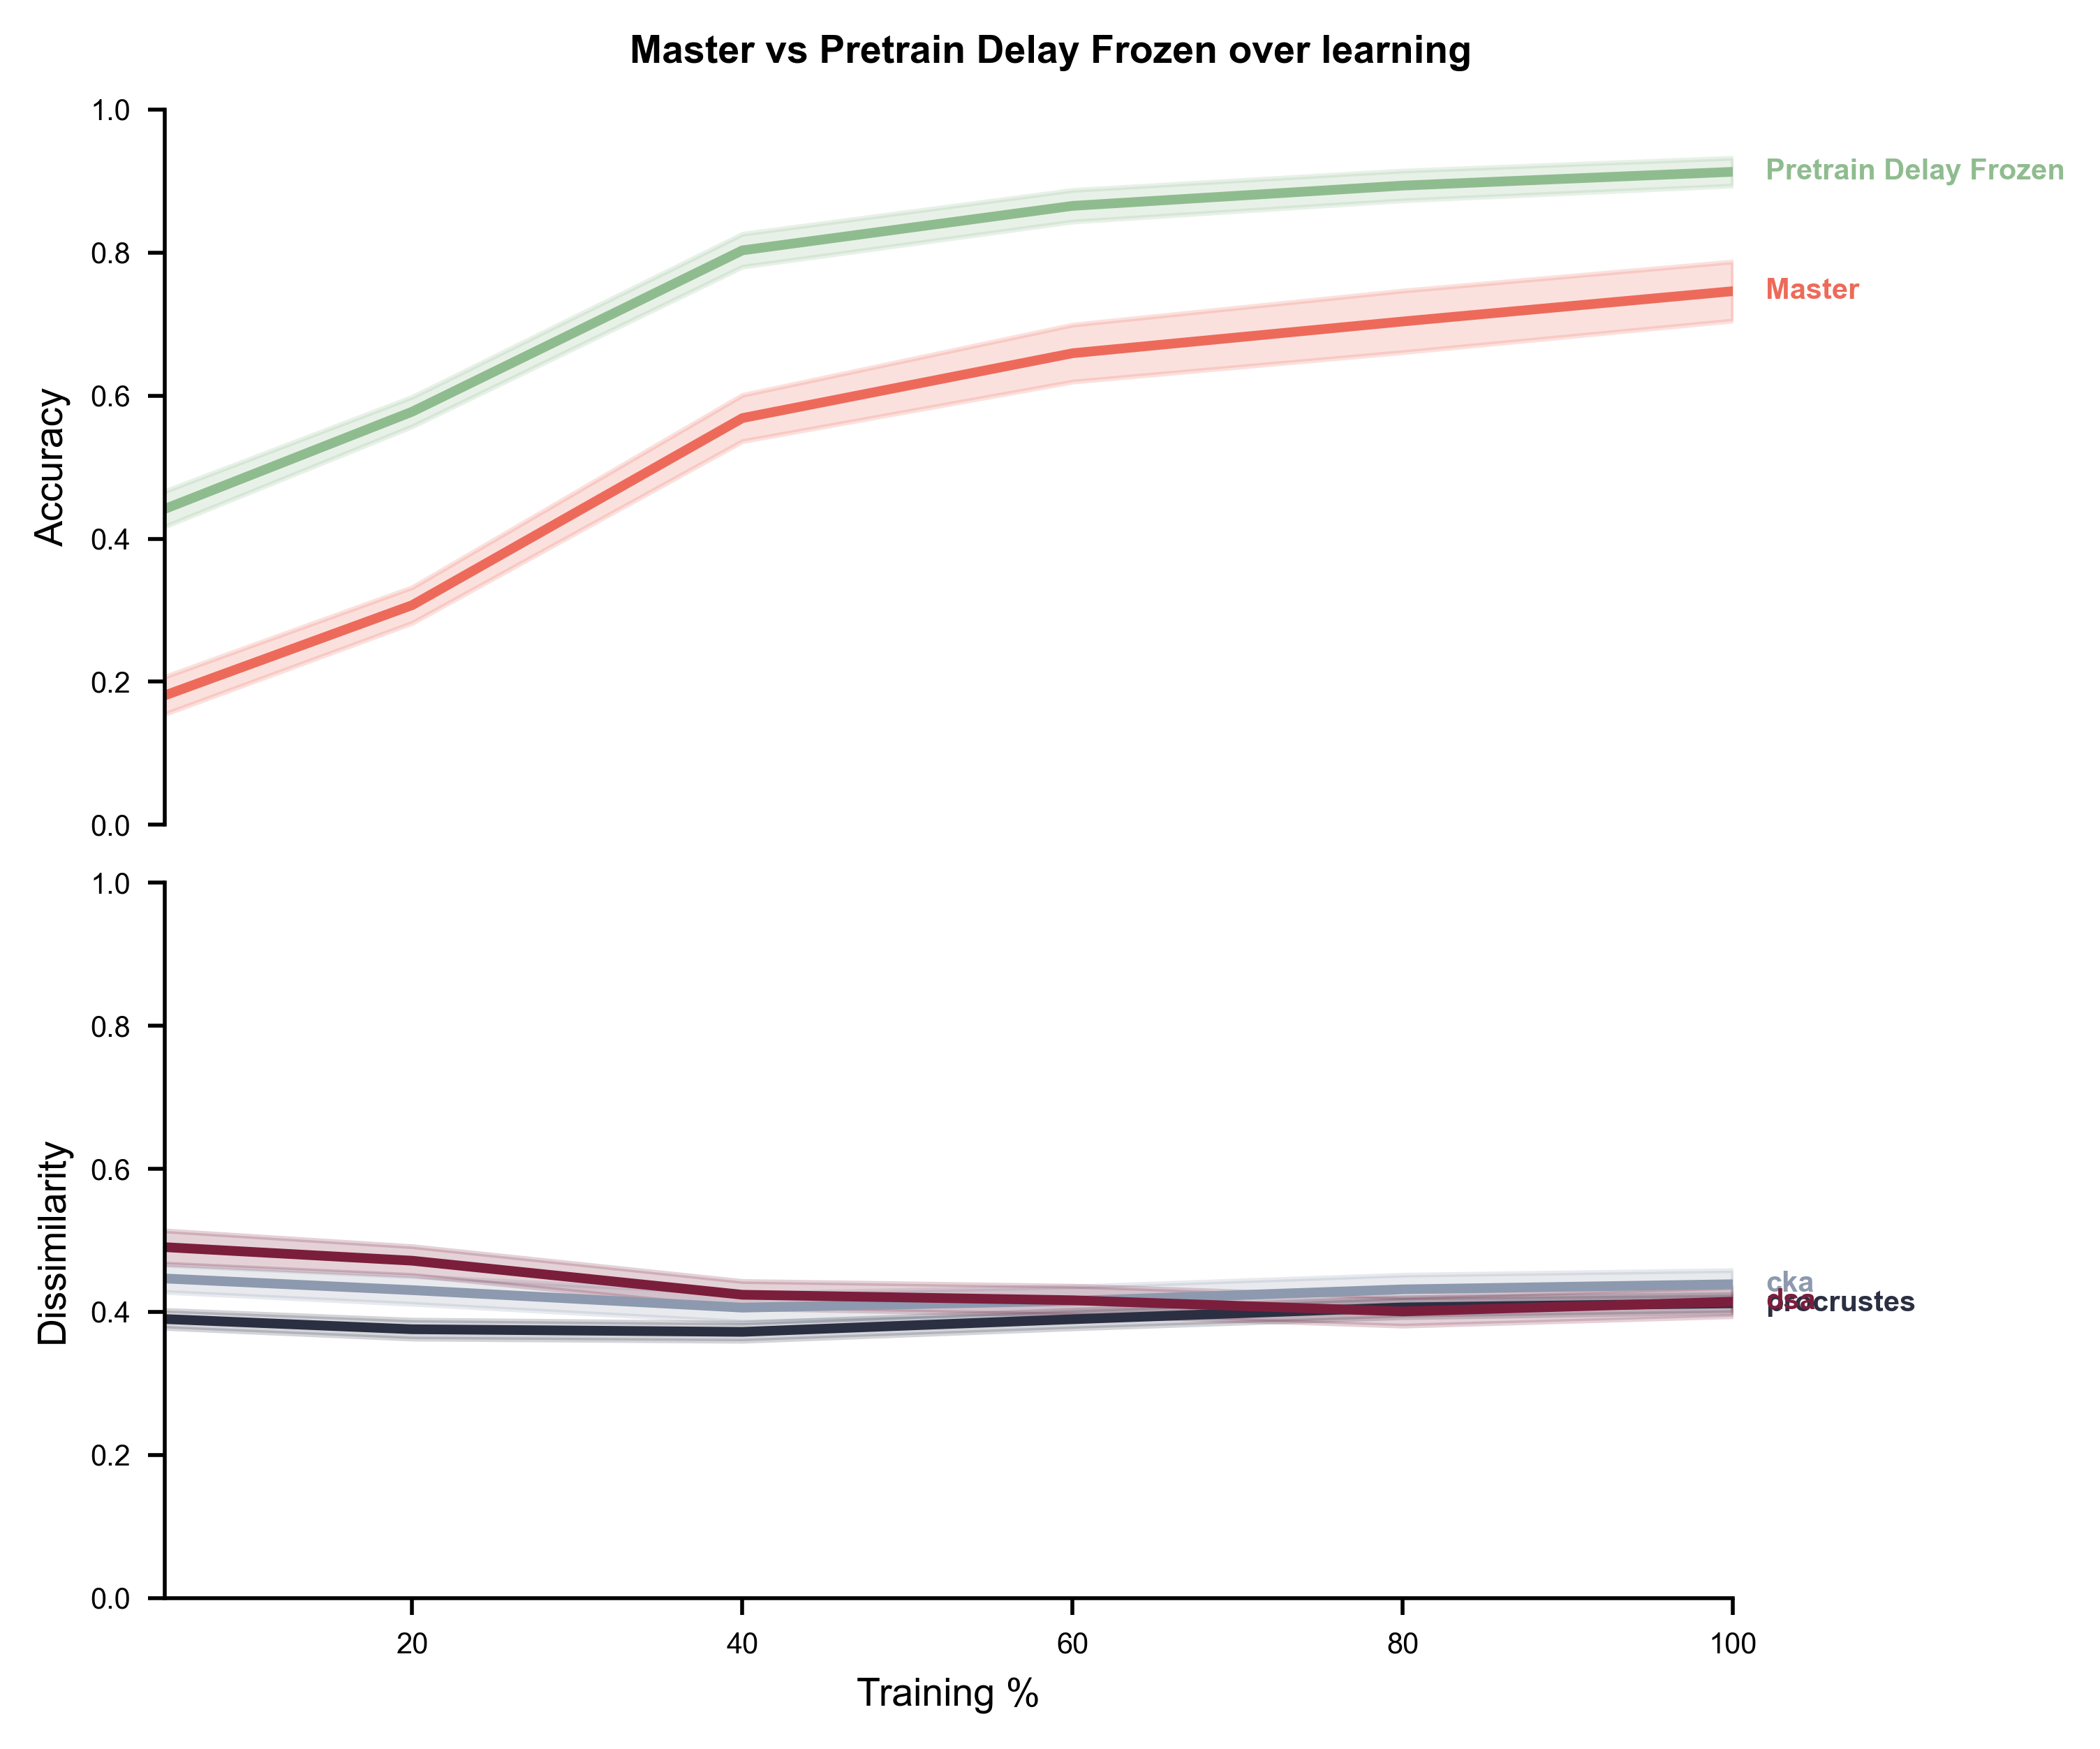

['', '_pretrain_basic_delay_frozen']


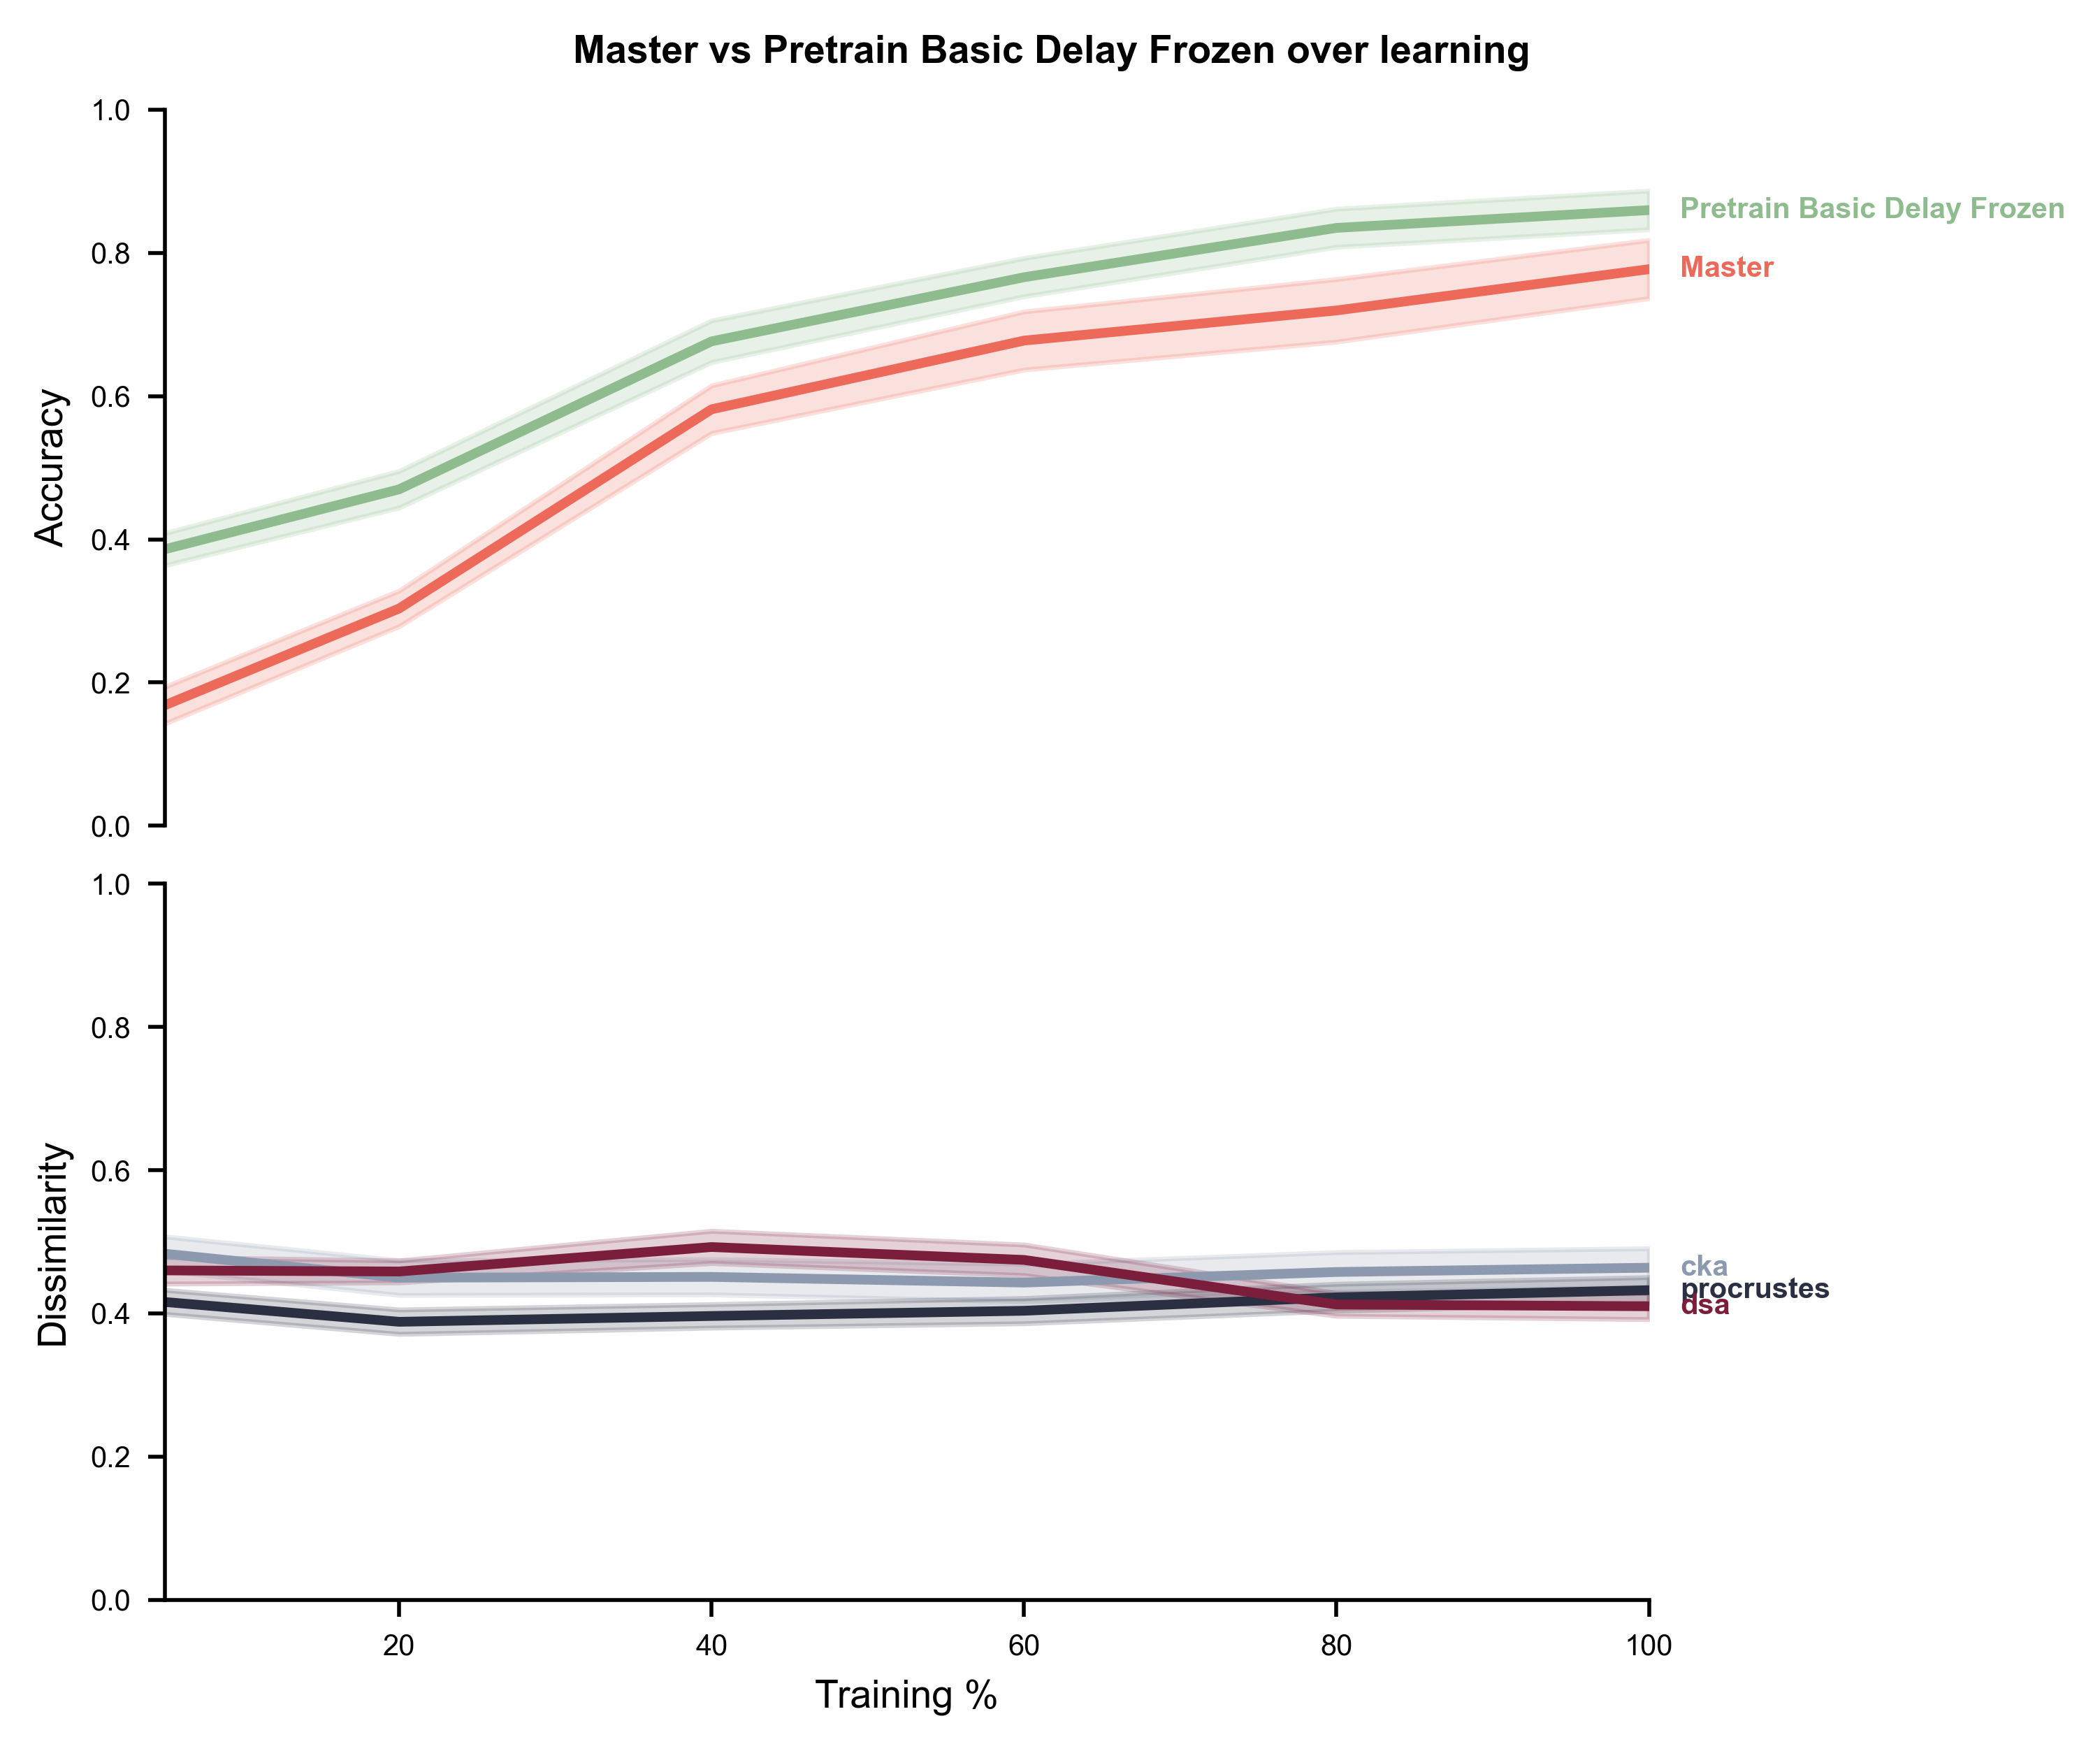

['pretrain_unfrozen_', '']


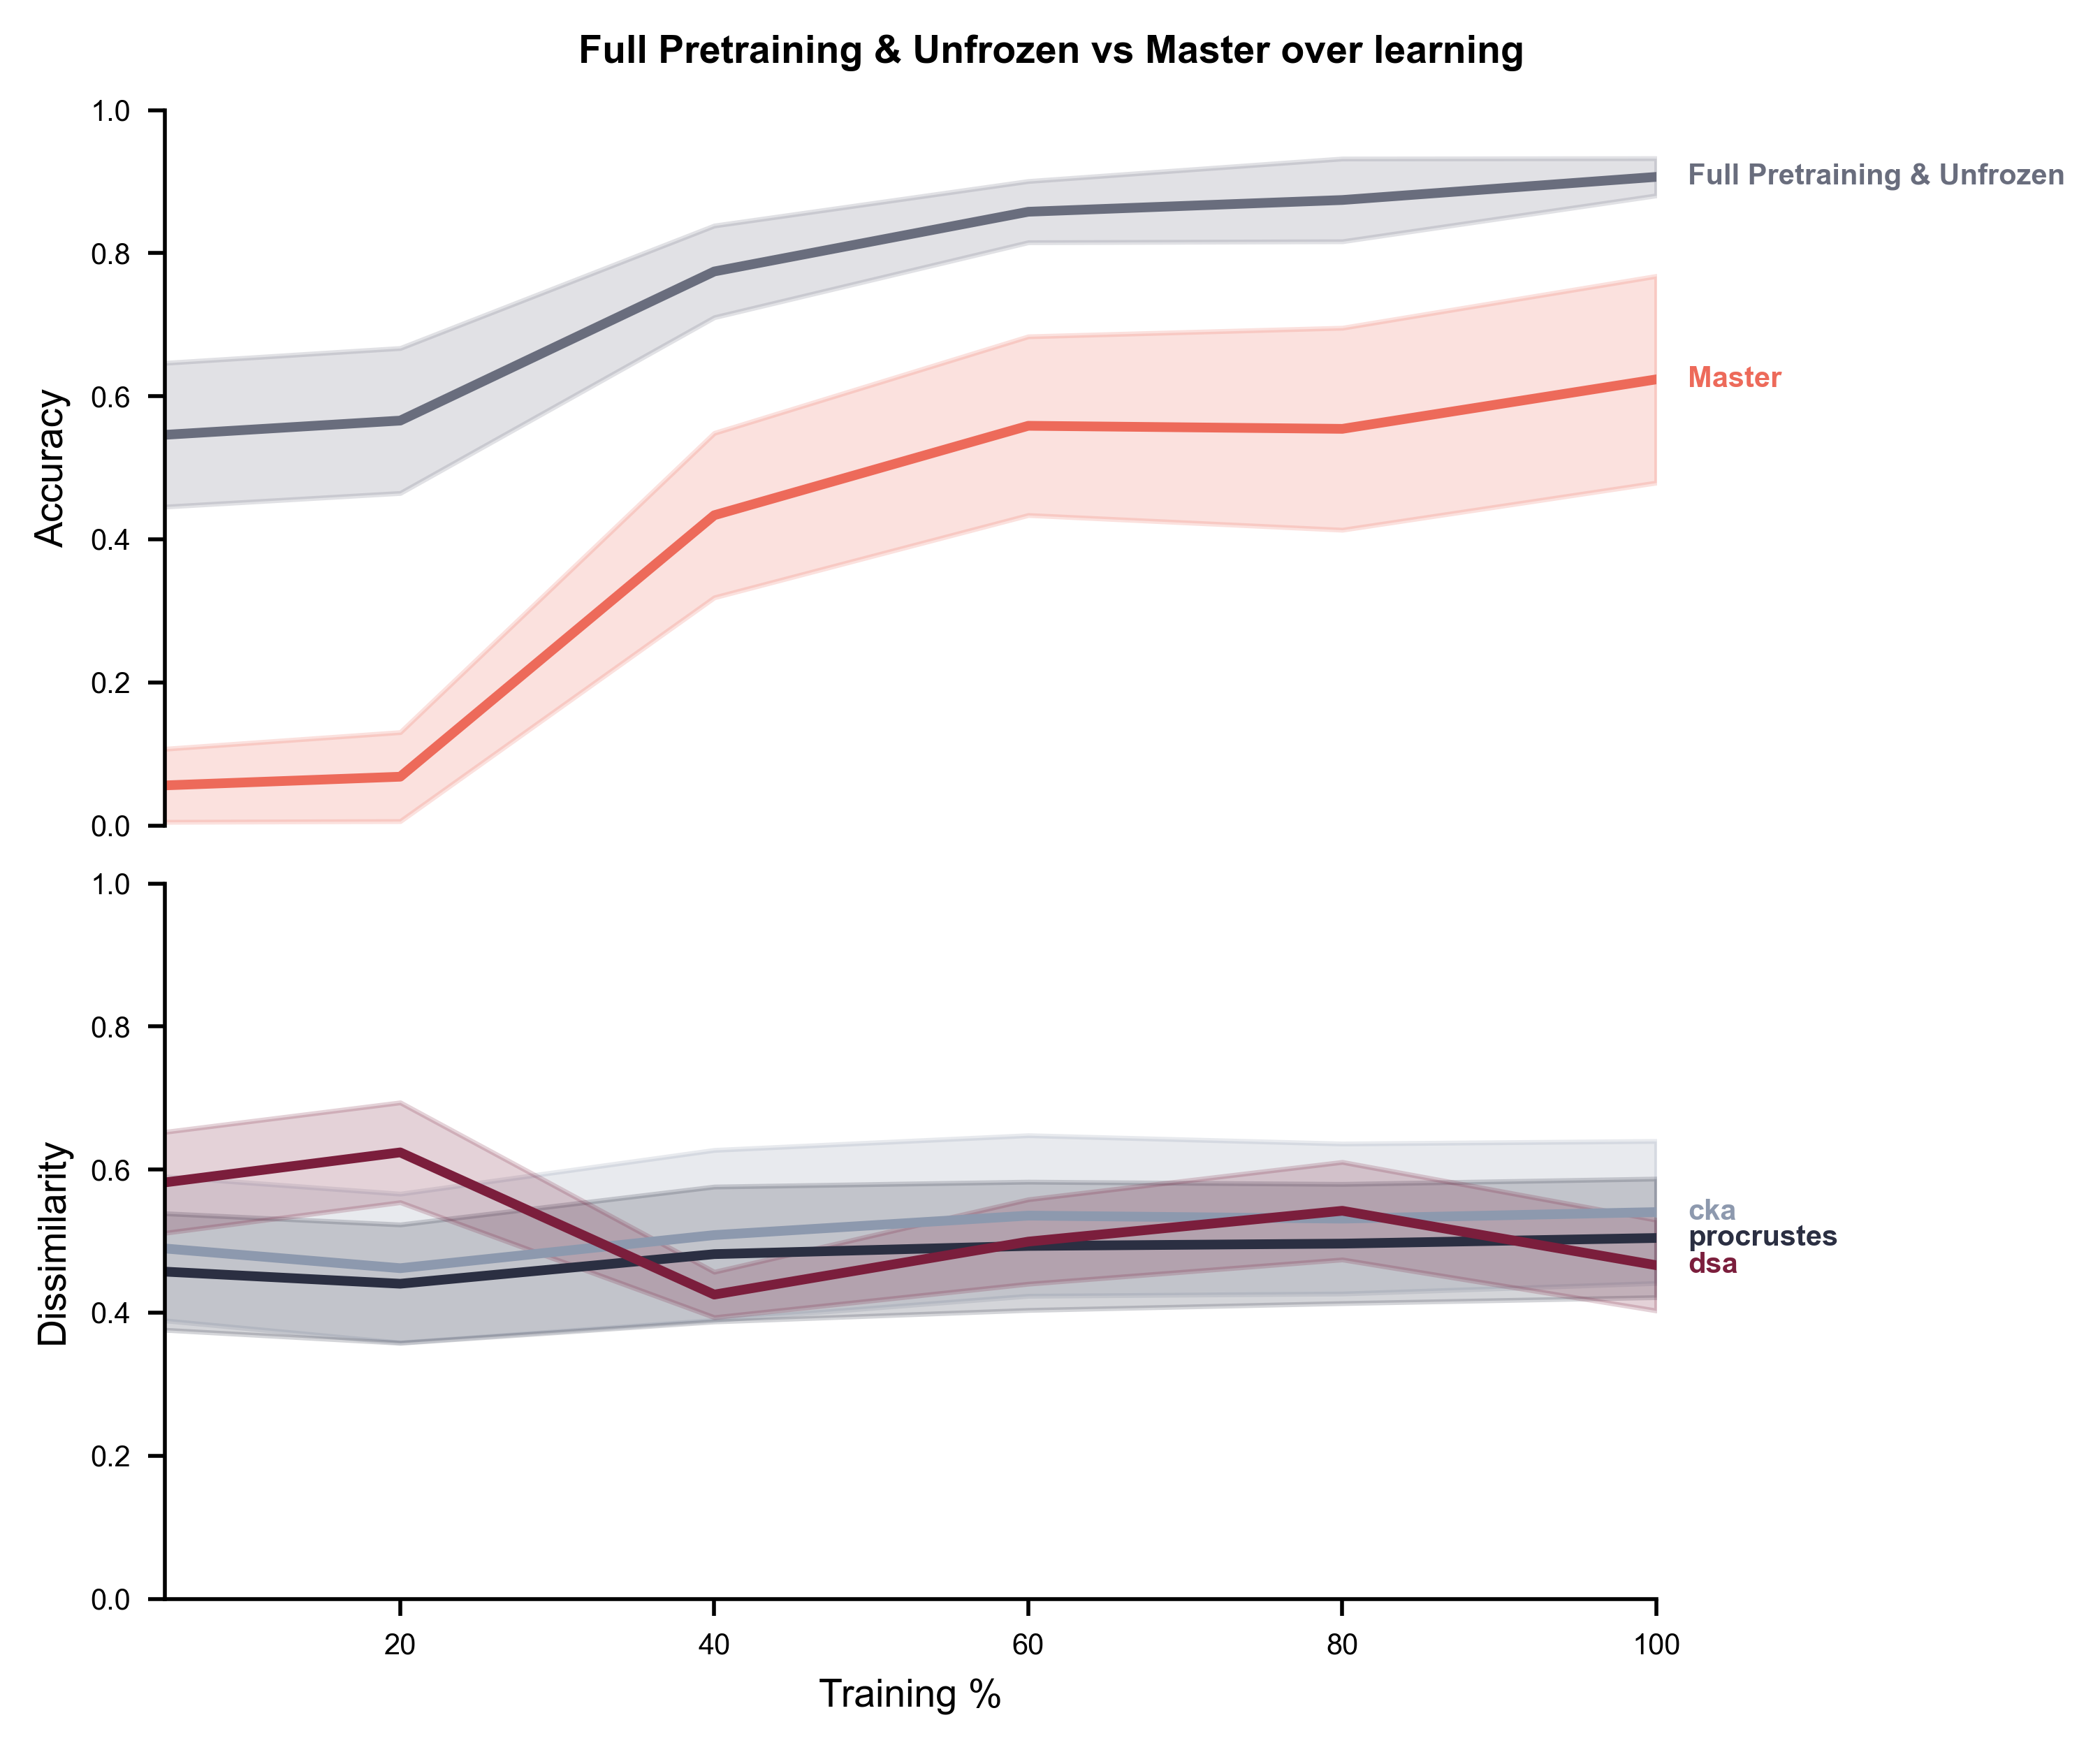

['', '_pretrain_anti_frozen']


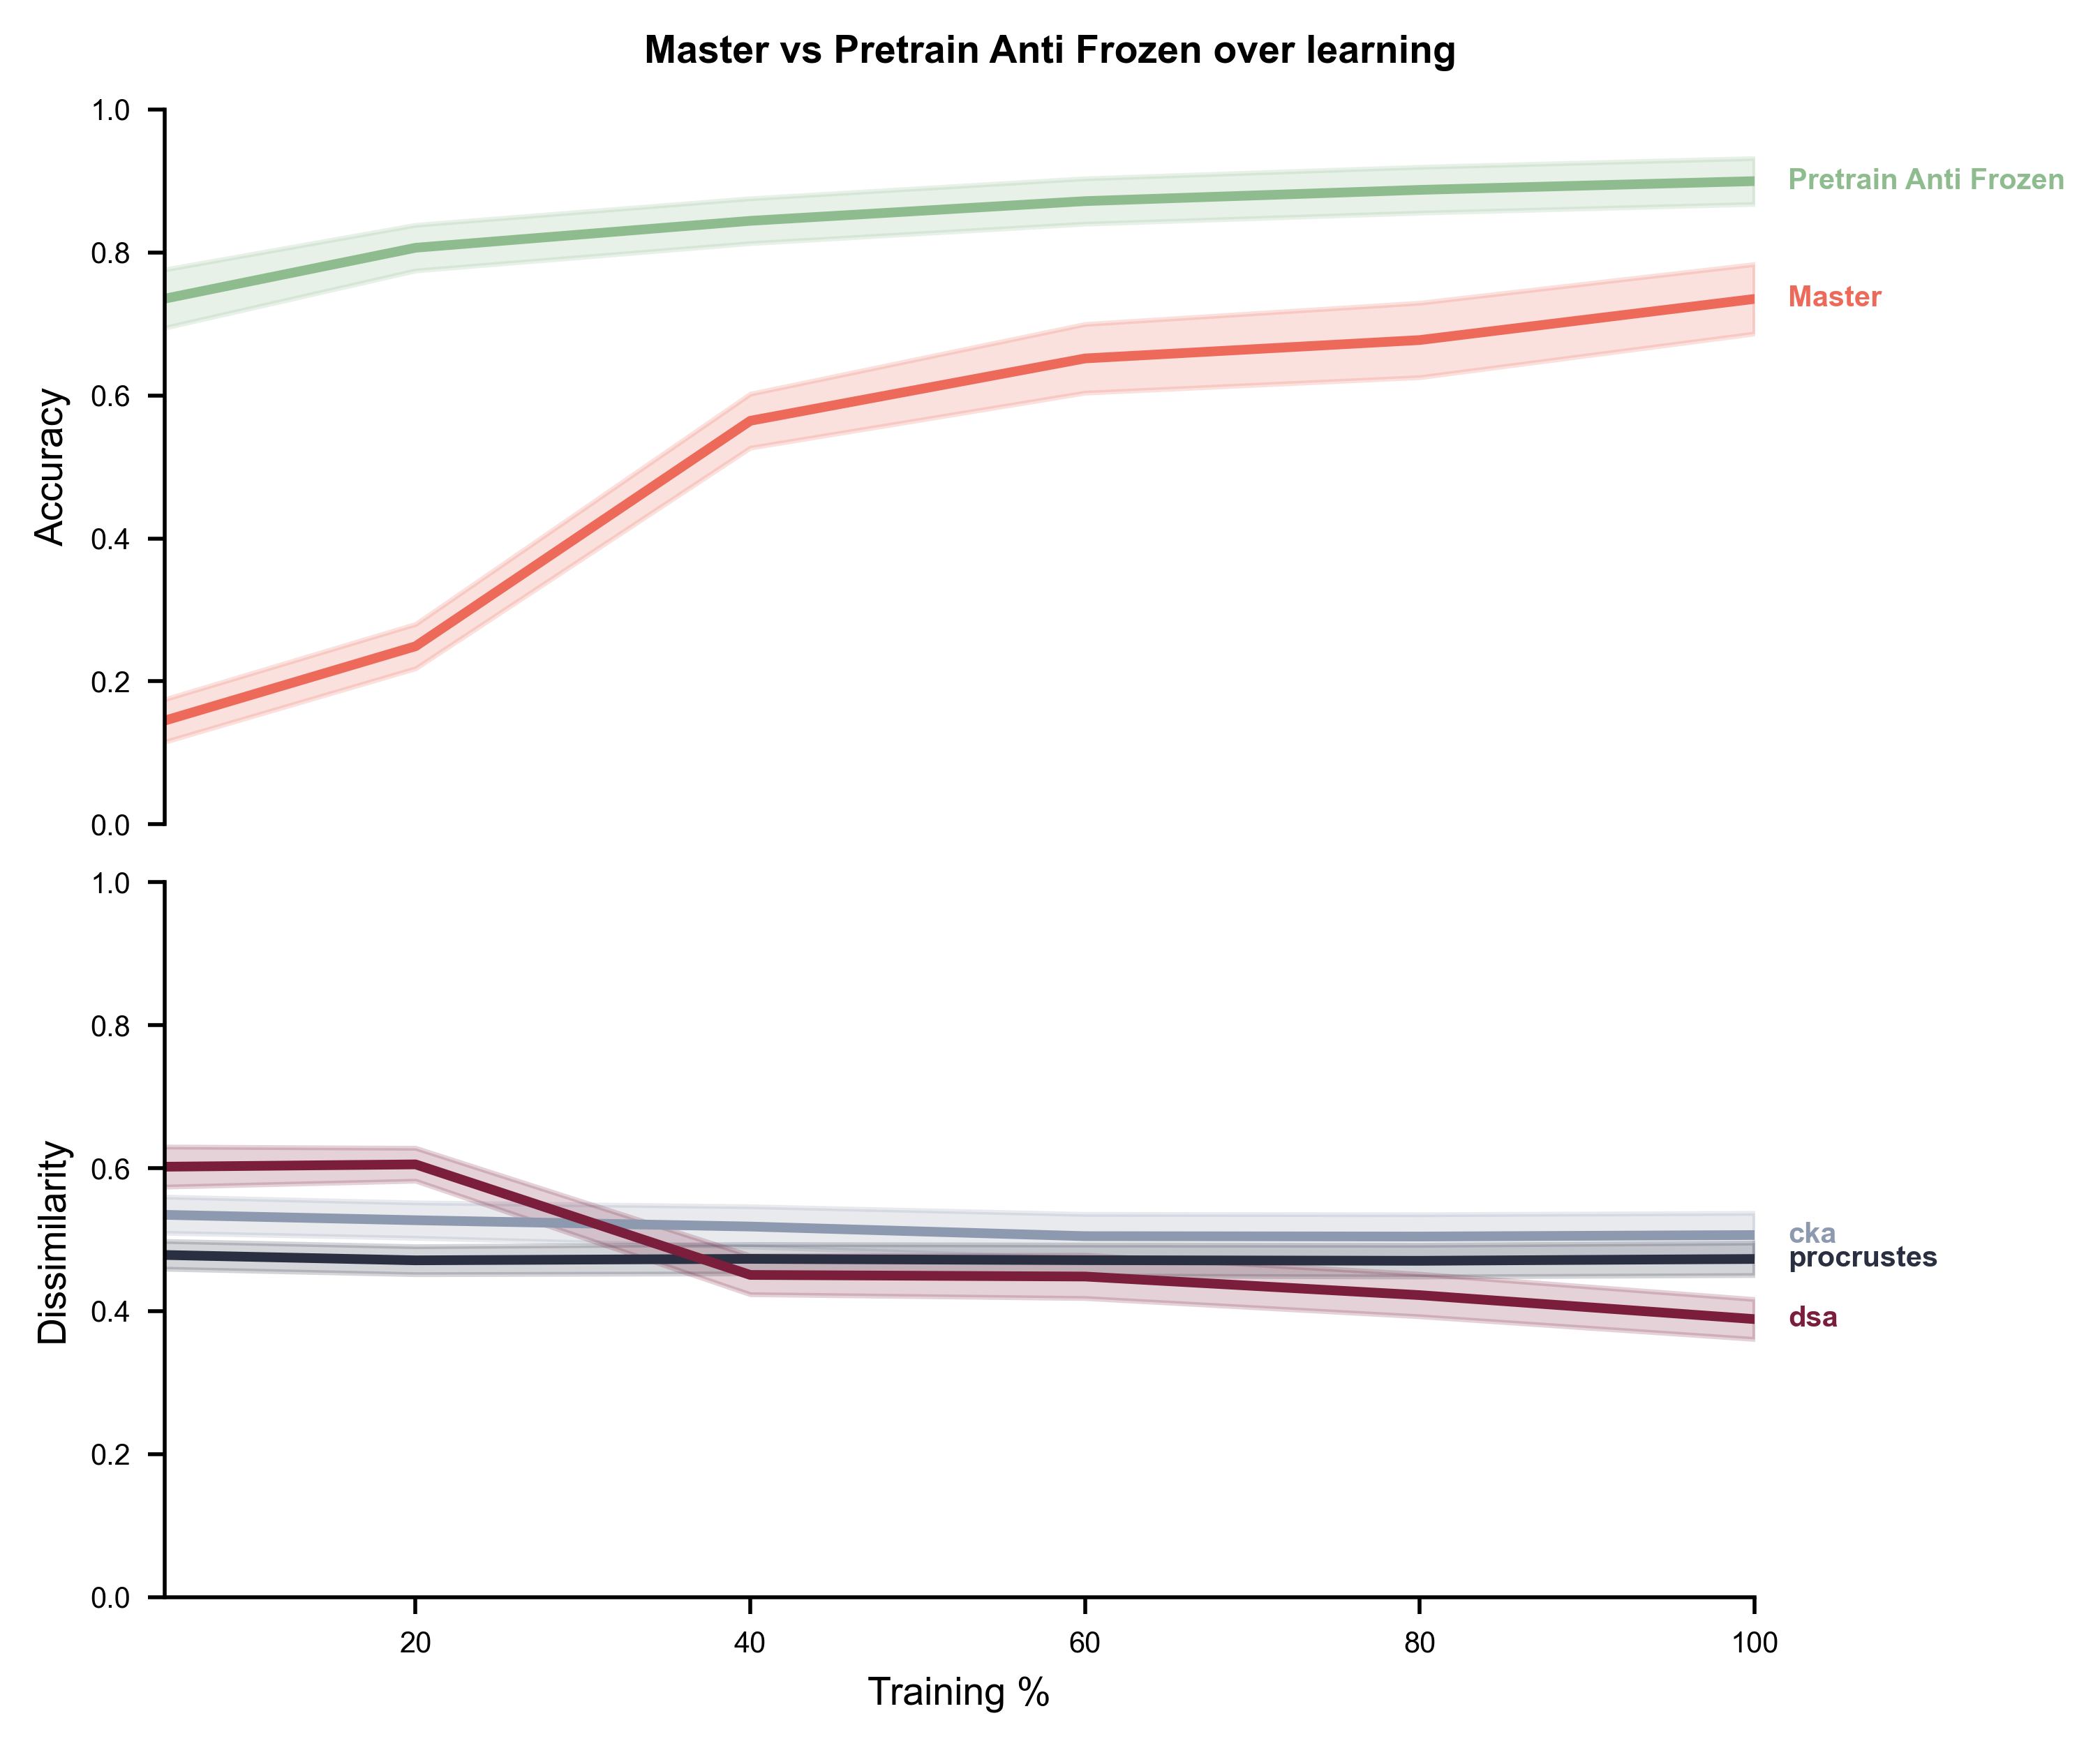

['', '_pretrain_basic_anti_frozen']


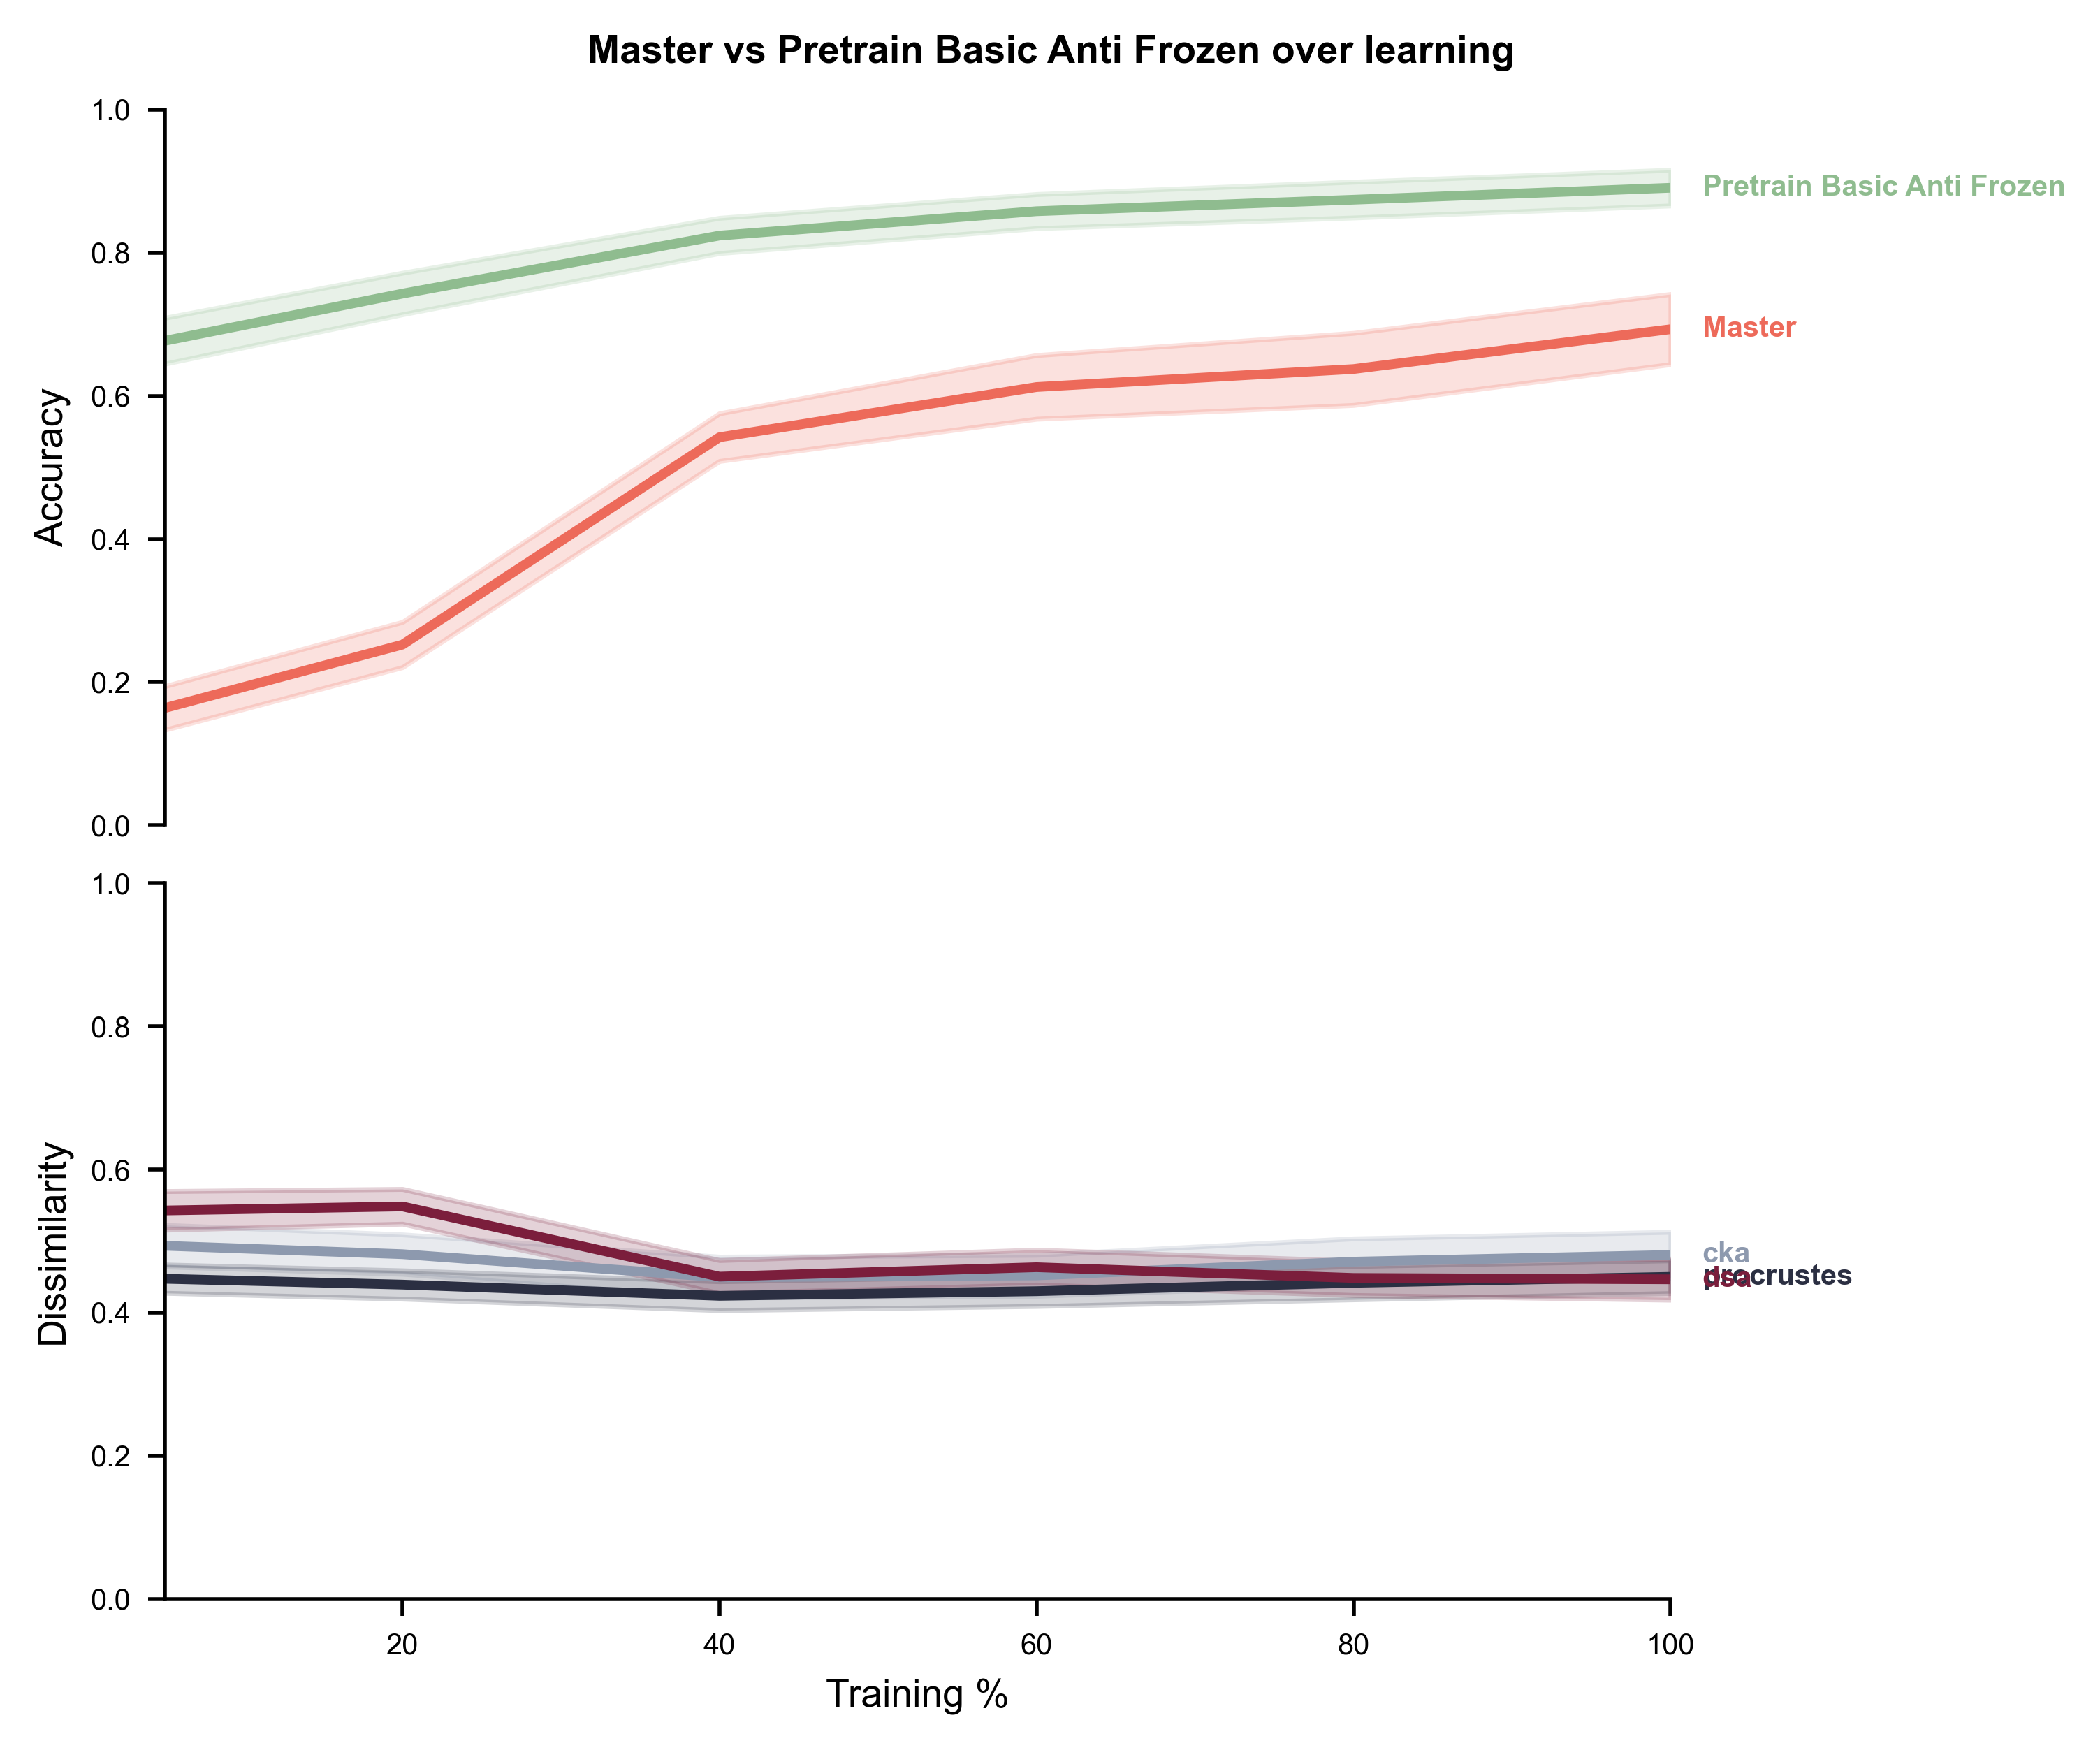

In [8]:
import os
from turtle import color
import numpy as np
import matplotlib.pyplot as plt

# Assuming dissimilarities_groups is defined from your previous code

# Iterate over each group in groups_training
for group_training in groups_training:
    if "master_frozen" not in group_training and "pretrain" in group_training:
        groups = group_training.split("master")
        if groups[0] == "":
            group1 = "master"
            group2 = groups[1][1:]
        else:
            group1 = groups[0][:-1]
            group2 = "master"
        print(groups)
        dissimilarities_interpolated = dissimilarities_groups[group_training]

        # X-axis values
        x_values = [i * 20 for i in range(6)]

        # Measures for the two plots
        measures_plot1 = ["cka", "procrustes", "dsa"]
        measures_plot2 = ["accuracy_1", "accuracy_2"]

        # Create the figure and the two subplots
        fig, axs = plt.subplots(
            2, 1, figsize=(6, 5), sharex=True, dpi=500
        )  # 2 rows, 1 column

        # Add a global title for the figure
        fig.suptitle(
            f"{group_mapping_names[group1]} vs {group_mapping_names[group2]} over learning",
            fontsize=SIZE_LARGE,
            fontweight="bold",
        )

        # Plot for the first set of measures (dissimilarities)
        for key in measures_plot1:
            dictionary_measures = dissimilarities_interpolated[key]
            means = [value[0] for value in dictionary_measures.values()]
            errors = [value[1] for value in dictionary_measures.values()]

            # Plot with shaded area for standard error
            axs[1].plot(
                x_values,
                means,
                label=key,
                color=color_mapping_metrics[key],
                linewidth=2,
            )
            axs[1].fill_between(
                x_values,
                [m - e for m, e in zip(means, errors)],
                [m + e for m, e in zip(means, errors)],
                color=color_mapping_metrics[key],
                alpha=0.2,
            )

            # Annotate each curve with its label slightly to the right of the last point
            axs[1].text(
                x_values[-1] * 1.02,  # Adjust x position slightly to the right
                means[-1],
                key,
                color=color_mapping_metrics[key],
                fontweight="bold",
                verticalalignment="center",
            )

        axs[1].set_ylabel("Dissimilarity")
        axs[1].set_ylim(0, 1)
        axs[1].grid(False)
        axs[1].set_xlabel("Training %")  # Keep x-axis label and graduation for axs[1]
        axs[1].set_xlim(5,100)

        # Plot for the second set of measures (accuracy)
        for i, key in enumerate(measures_plot2):
            dictionary_measures = dissimilarities_interpolated[key]
            means = [value[0] for value in dictionary_measures.values()]
            errors = [value[1] for value in dictionary_measures.values()]

            # Rename legend label for accuracy
            label = (
                f"{group_mapping_names[group1]}"
                if i == 0
                else f"{group_mapping_names[group2]}"
            )
            color = color_mapping[group1] if i == 0 else color_mapping[group2]

            # Plot with shaded area for standard error
            axs[0].plot(x_values, means, label=label, color=color, linewidth=2)
            axs[0].fill_between(
                x_values,
                [m - e for m, e in zip(means, errors)],
                [m + e for m, e in zip(means, errors)],
                color=color,
                alpha=0.2,
            )

            # Annotate each curve with its label slightly to the right of the last point
            axs[0].text(
                x_values[-1] * 1.02,  # Adjust x position slightly to the right
                means[-1],
                label,
                color=color,
                fontweight="bold",
                verticalalignment="center",
            )

        axs[0].set_ylabel("Accuracy")
        axs[0].set_ylim(0, 1)
        axs[0].grid(False)

        # Remove x-axis ticks and labels for the first subplot (axs[0])
        axs[0].tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

        # Customize plot limits and remove right/top spines
        for ax in axs:
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)
            ax.spines["left"].set_visible(True)
            ax.spines["bottom"].set_visible(True)
            if ax == axs[0]:
                ax.spines["bottom"].set_visible(False)

        # Adjust layout to avoid overlapping elements
        plt.tight_layout()

        # Display the plots
        plt.show()

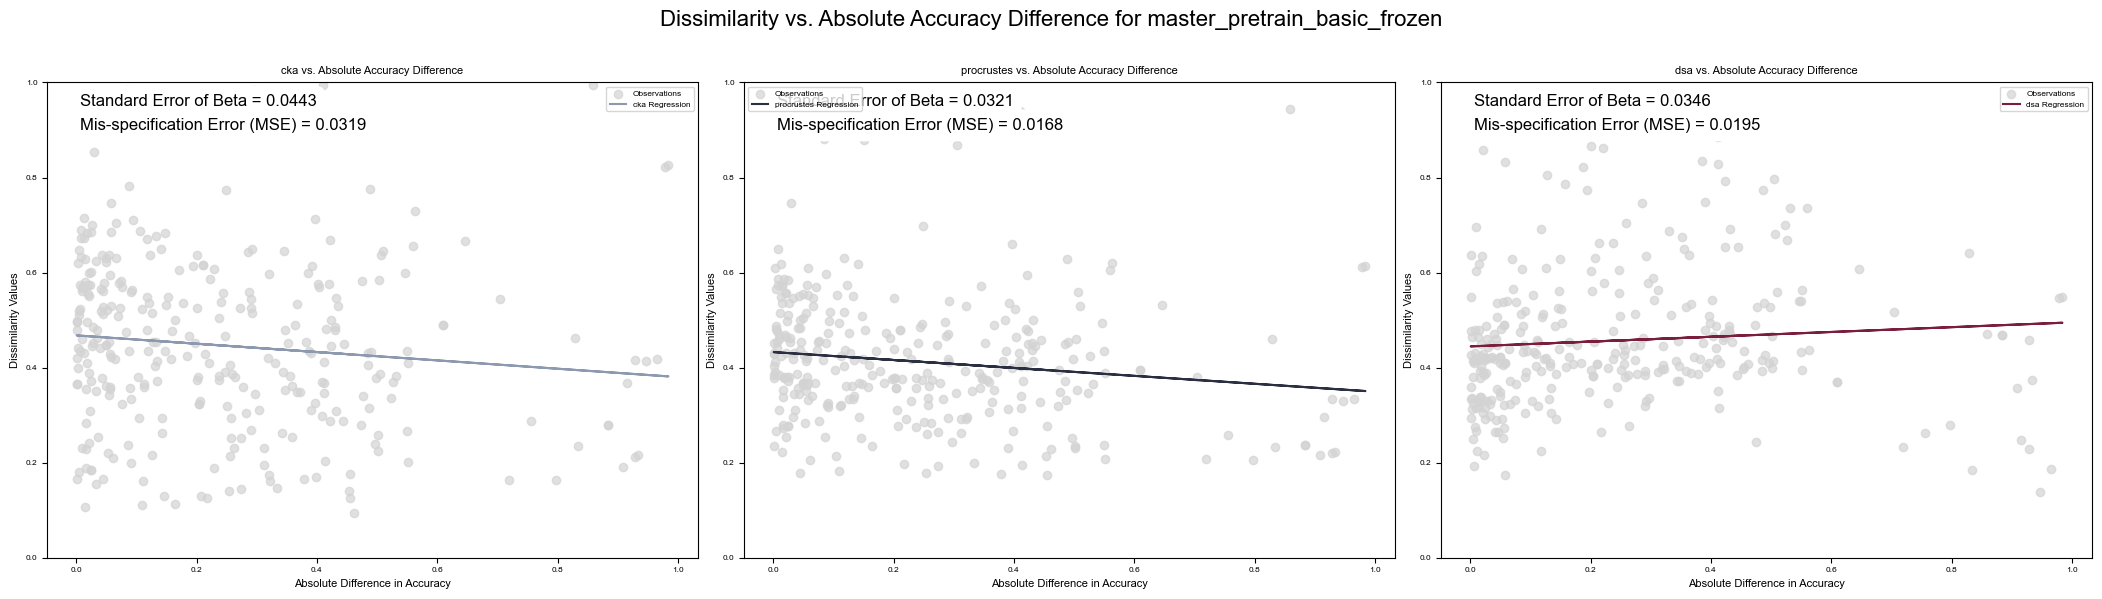

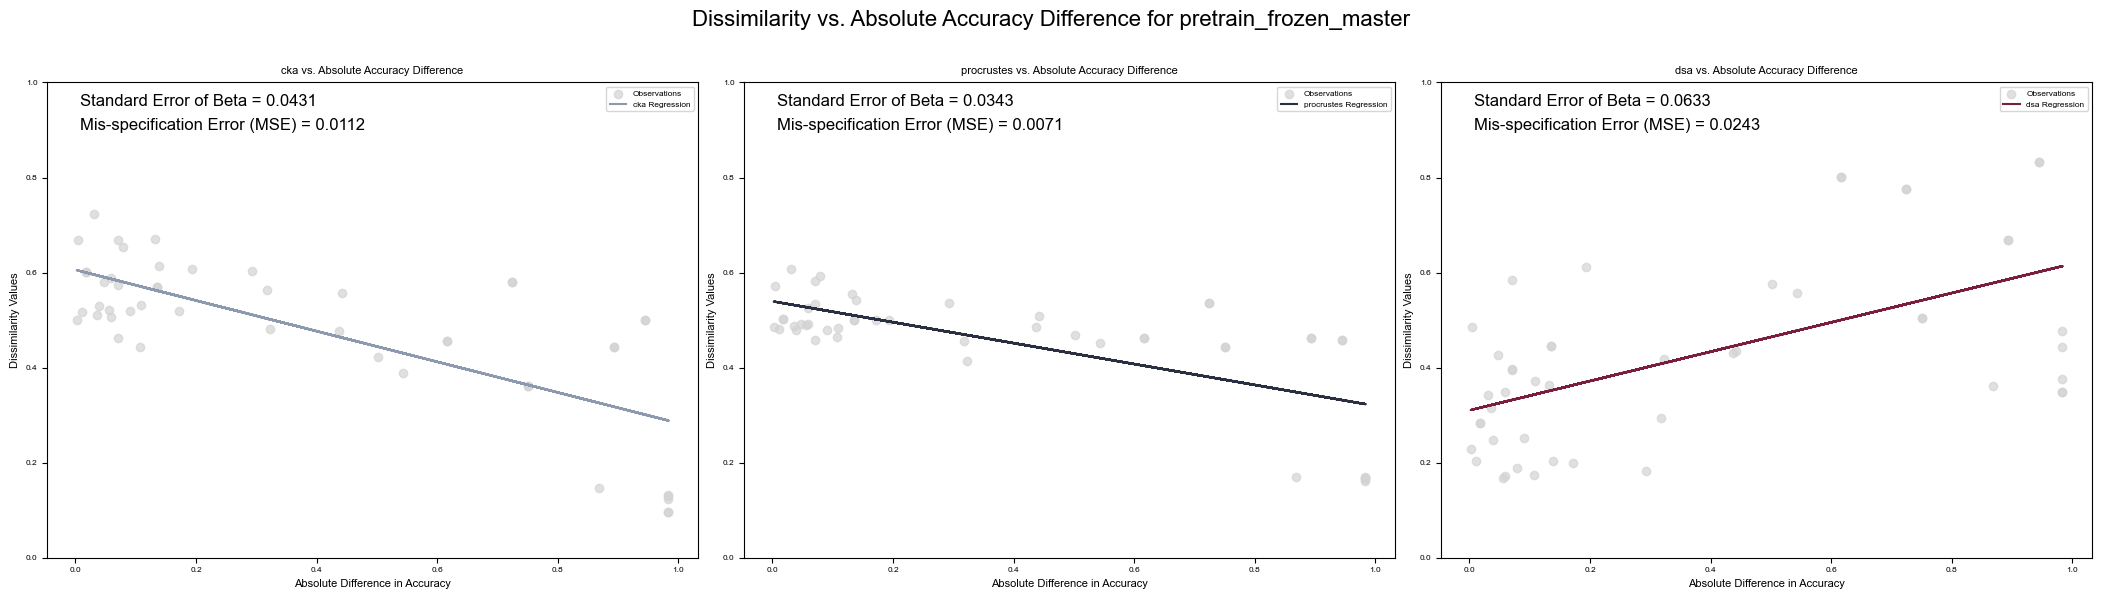

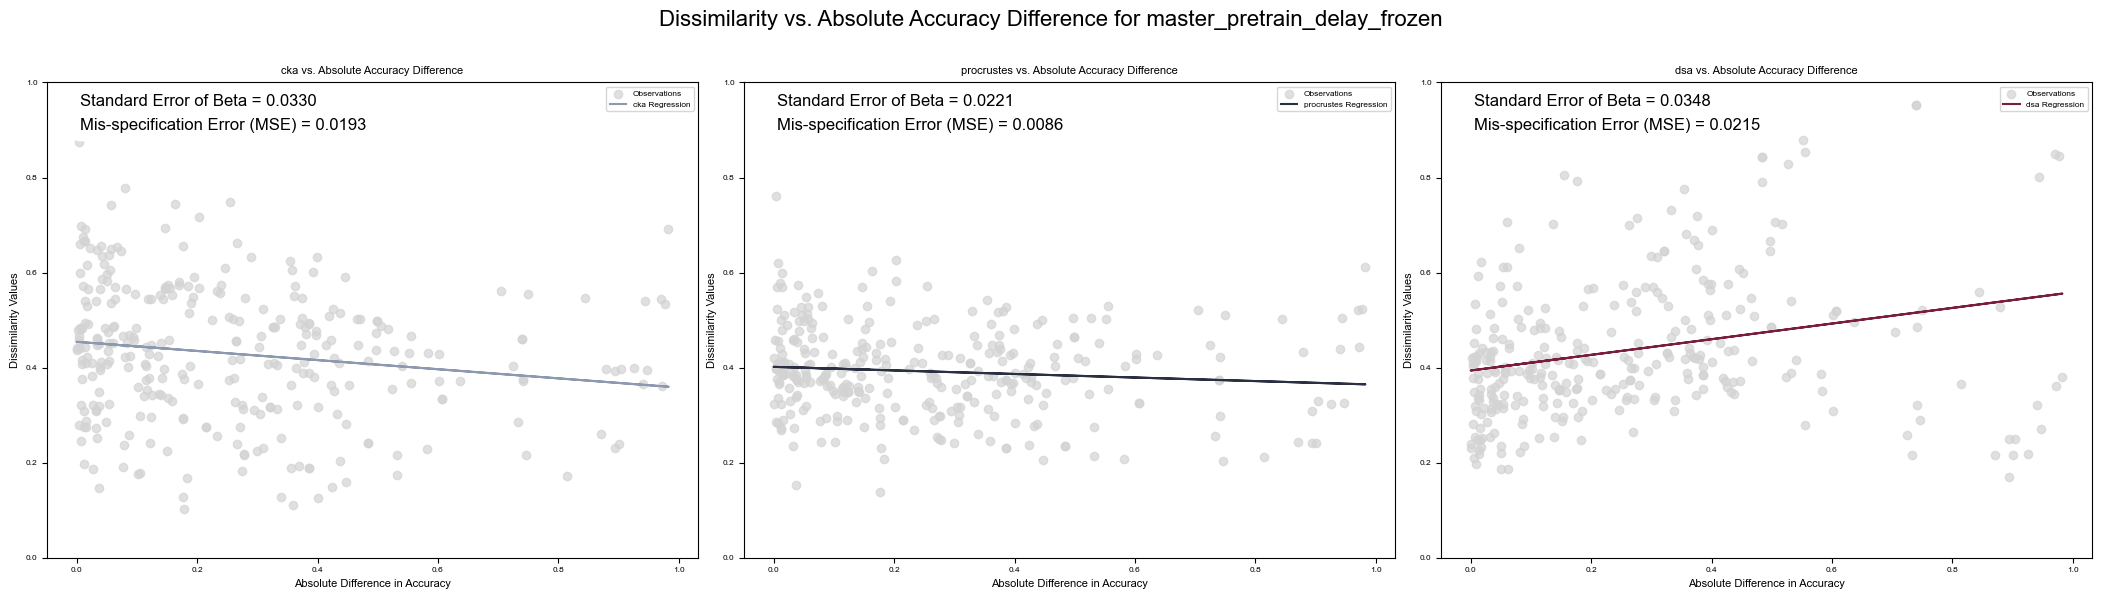

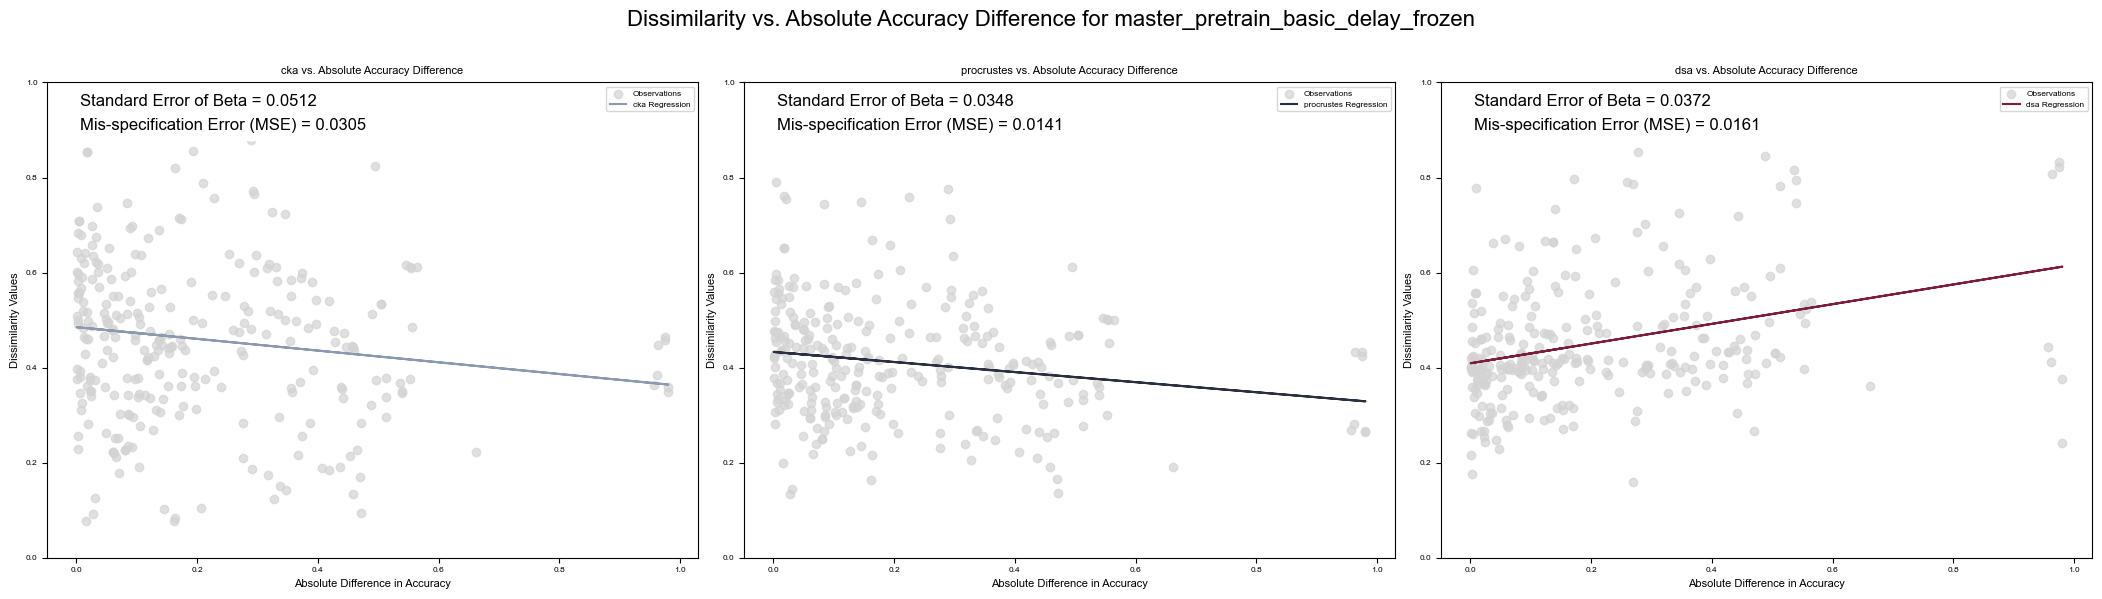

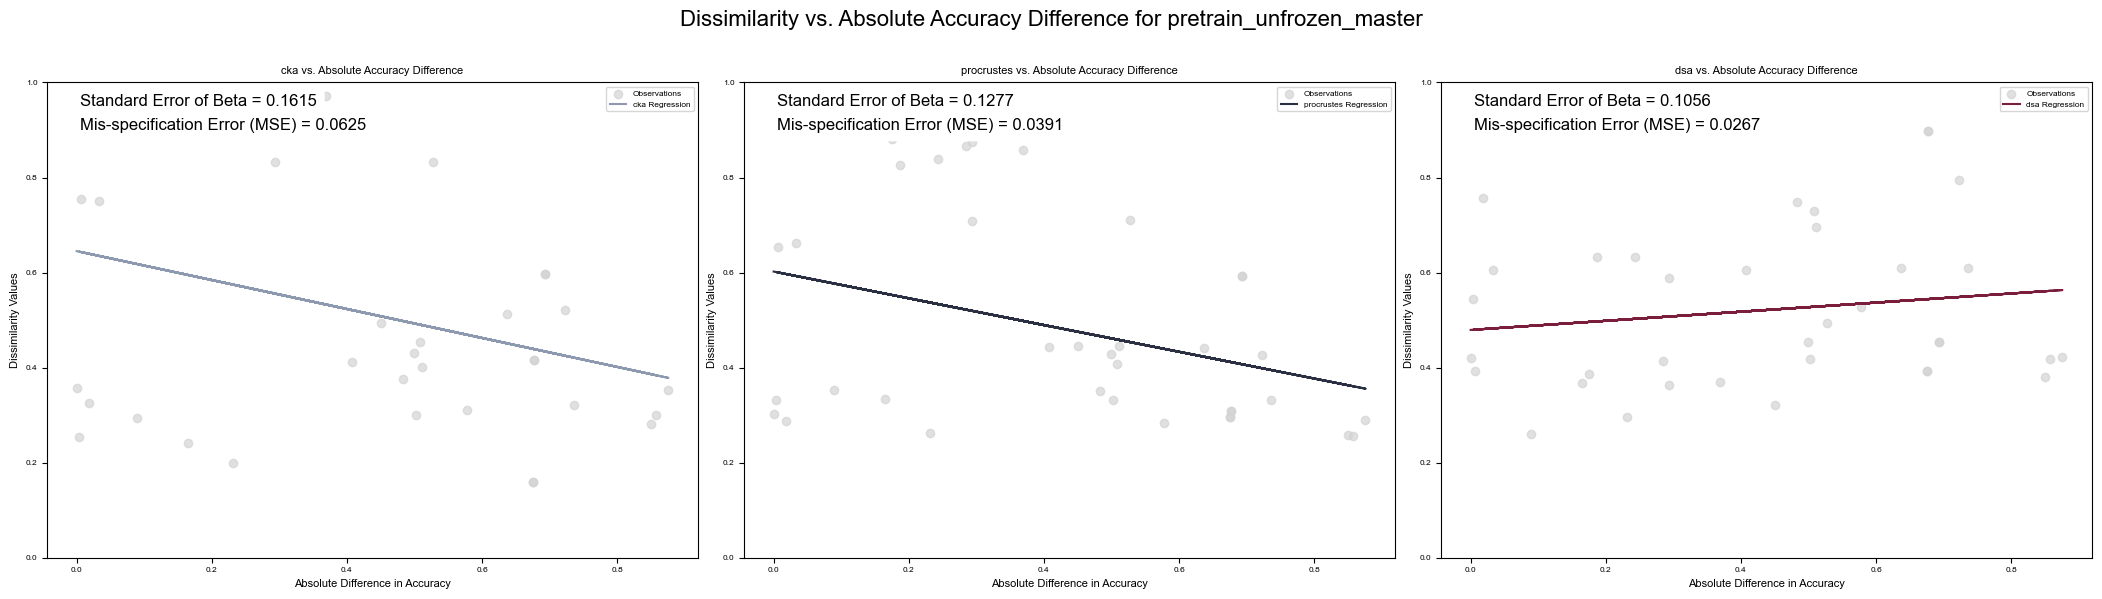

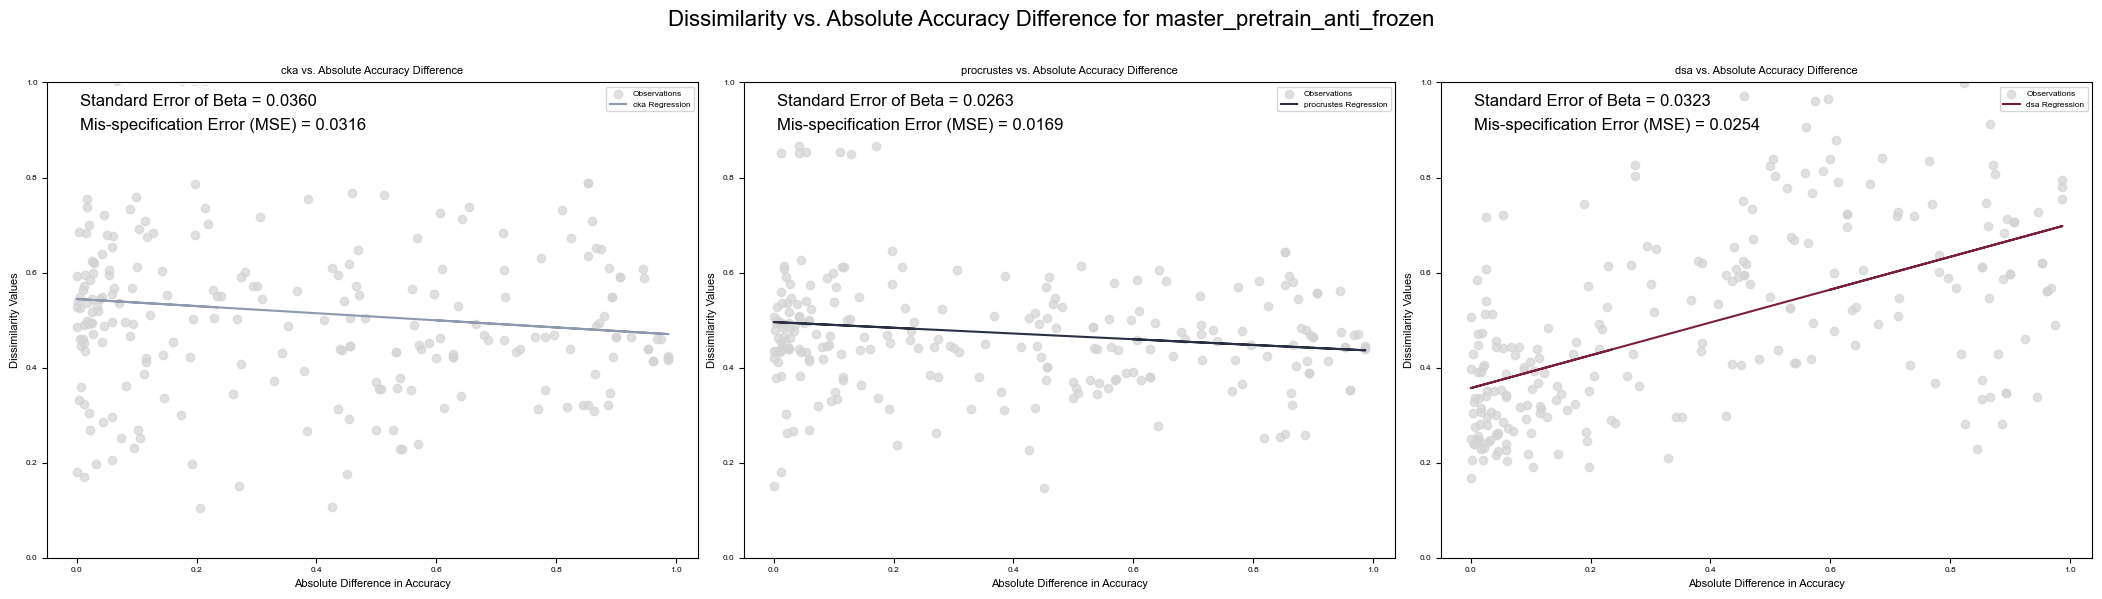

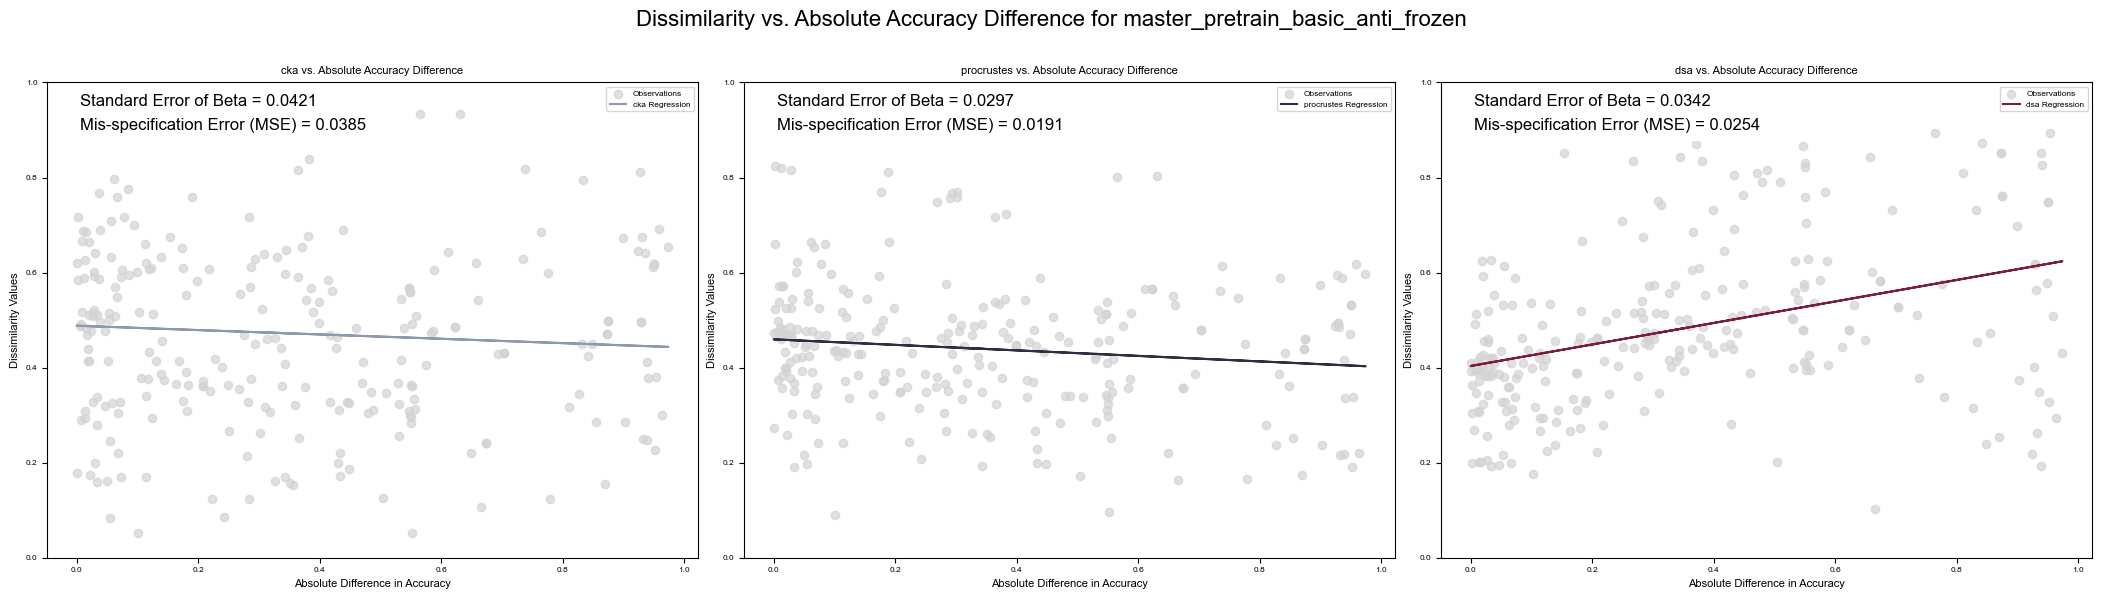

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression  # Ensure you import this

# Assuming dissimilarities_groups is defined from your previous code

# Iterate over each group in groups_training
for group_training in groups_training:
    if "master_frozen" not in group_training and "untrained" not in group_training and "master_master" not in group_training and "pretrain_partial" not in group_training:
        dissimilarities_interpolated = dissimilarities_groups[group_training]

        # X-axis values
        x_values = [i * 20 for i in range(6)]

        # Measures for dissimilarities and accuracies
        measures_plot1 = ["cka", "procrustes", "dsa"]
        measures_plot2 = ["accuracy_1", "accuracy_2"]

        # Collect accuracy values to calculate absolute differences
        accuracy_values = {}
        for key in measures_plot2:
            dict_sampling_to_mean_and_errors = dissimilarities_interpolated[key]
            accuracy_values[key] = [
                value[2] for value in dict_sampling_to_mean_and_errors.values()
            ]
            # flatten the list
            accuracy_values[key] = [
                item for sublist in accuracy_values[key] for item in sublist
            ]

        # Calculate the absolute difference between the two accuracy measures
        abs_diff_accuracies = np.abs(
            np.array(accuracy_values["accuracy_1"])
            - np.array(accuracy_values["accuracy_2"])
        )

        # Create a figure with 3 subplots, one for each measure
        fig, axs = plt.subplots(1, 3, figsize=(21, 6))  # 1 row, 3 columns

        # Plot the dissimilarities against the absolute accuracy difference
        for idx, key in enumerate(measures_plot1):
            dict_sampling_to_mean_and_errors = dissimilarities_interpolated[key]
            dissimilarity_values = [
                value[2] for value in dict_sampling_to_mean_and_errors.values()
            ]
            # flatten the list
            dissimilarity_values = [
                item for sublist in dissimilarity_values for item in sublist
            ]

            # Ensure X and Y have the same length and remove NaNs
            X = np.array(abs_diff_accuracies)
            Y = np.array(dissimilarity_values)

            # Check for NaN values in X or Y and remove them
            valid_indices = ~np.isnan(X) & ~np.isnan(Y)
            X = X[valid_indices].reshape(-1, 1)
            Y = Y[valid_indices]

            # Plot the observations in light gray
            axs[idx].scatter(X, Y, color="lightgray", label="Observations", alpha=0.7)

            # Fit a linear regression model
            model = LinearRegression()
            model.fit(X, Y)

            # Predict y values for the regression line
            Y_pred = model.predict(X)

            # Get the slope (beta) and intercept
            beta = model.coef_[0]
            intercept = model.intercept_

            # Compute residuals and their variance
            residuals = Y - Y_pred
            residual_variance = np.var(
                residuals, ddof=2
            )  # ddof=2 because we have 2 parameters estimated (slope and intercept)

            # Compute variance of X
            X_mean = np.mean(X)
            X_variance = np.sum((X - X_mean) ** 2)

            # Standard error of the slope (beta)
            standard_error_beta = np.sqrt(residual_variance / X_variance)

            # Mis-specification error (Mean Squared Error)
            mse = np.mean(residuals**2)

            # Plot the linear regression line in the specified color
            axs[idx].plot(X, Y_pred, color=color_mapping_metrics[key], label=f"{key} Regression")

            # Annotate the plot with Standard Error of Beta and Mis-specification Error
            axs[idx].annotate(
                f"Standard Error of Beta = {standard_error_beta:.4f}",
                xy=(0.05, 0.95),
                xycoords="axes fraction",
                fontsize=12,
                bbox=dict(
                    facecolor="white", edgecolor="none", boxstyle="round,pad=0.5"
                ),
            )
            axs[idx].annotate(
                f"Mis-specification Error (MSE) = {mse:.4f}",
                xy=(0.05, 0.90),
                xycoords="axes fraction",
                fontsize=12,
                bbox=dict(
                    facecolor="white", edgecolor="none", boxstyle="round,pad=0.5"
                ),
            )

            # Set labels and title for each subplot
            axs[idx].set_xlabel("Absolute Difference in Accuracy")
            axs[idx].set_ylabel("Dissimilarity Values")
            axs[idx].set_title(f"{key} vs. Absolute Accuracy Difference")
            axs[idx].set_ylim(0, 1)
            axs[idx].legend()
            axs[idx].grid(False)

        # Set the main title for the group
        fig.suptitle(
            f"Dissimilarity vs. Absolute Accuracy Difference for {group_training}",
            fontsize=16,
        )

        # Adjust layout to avoid overlapping elements
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title

        # Display the plot
        plt.show()

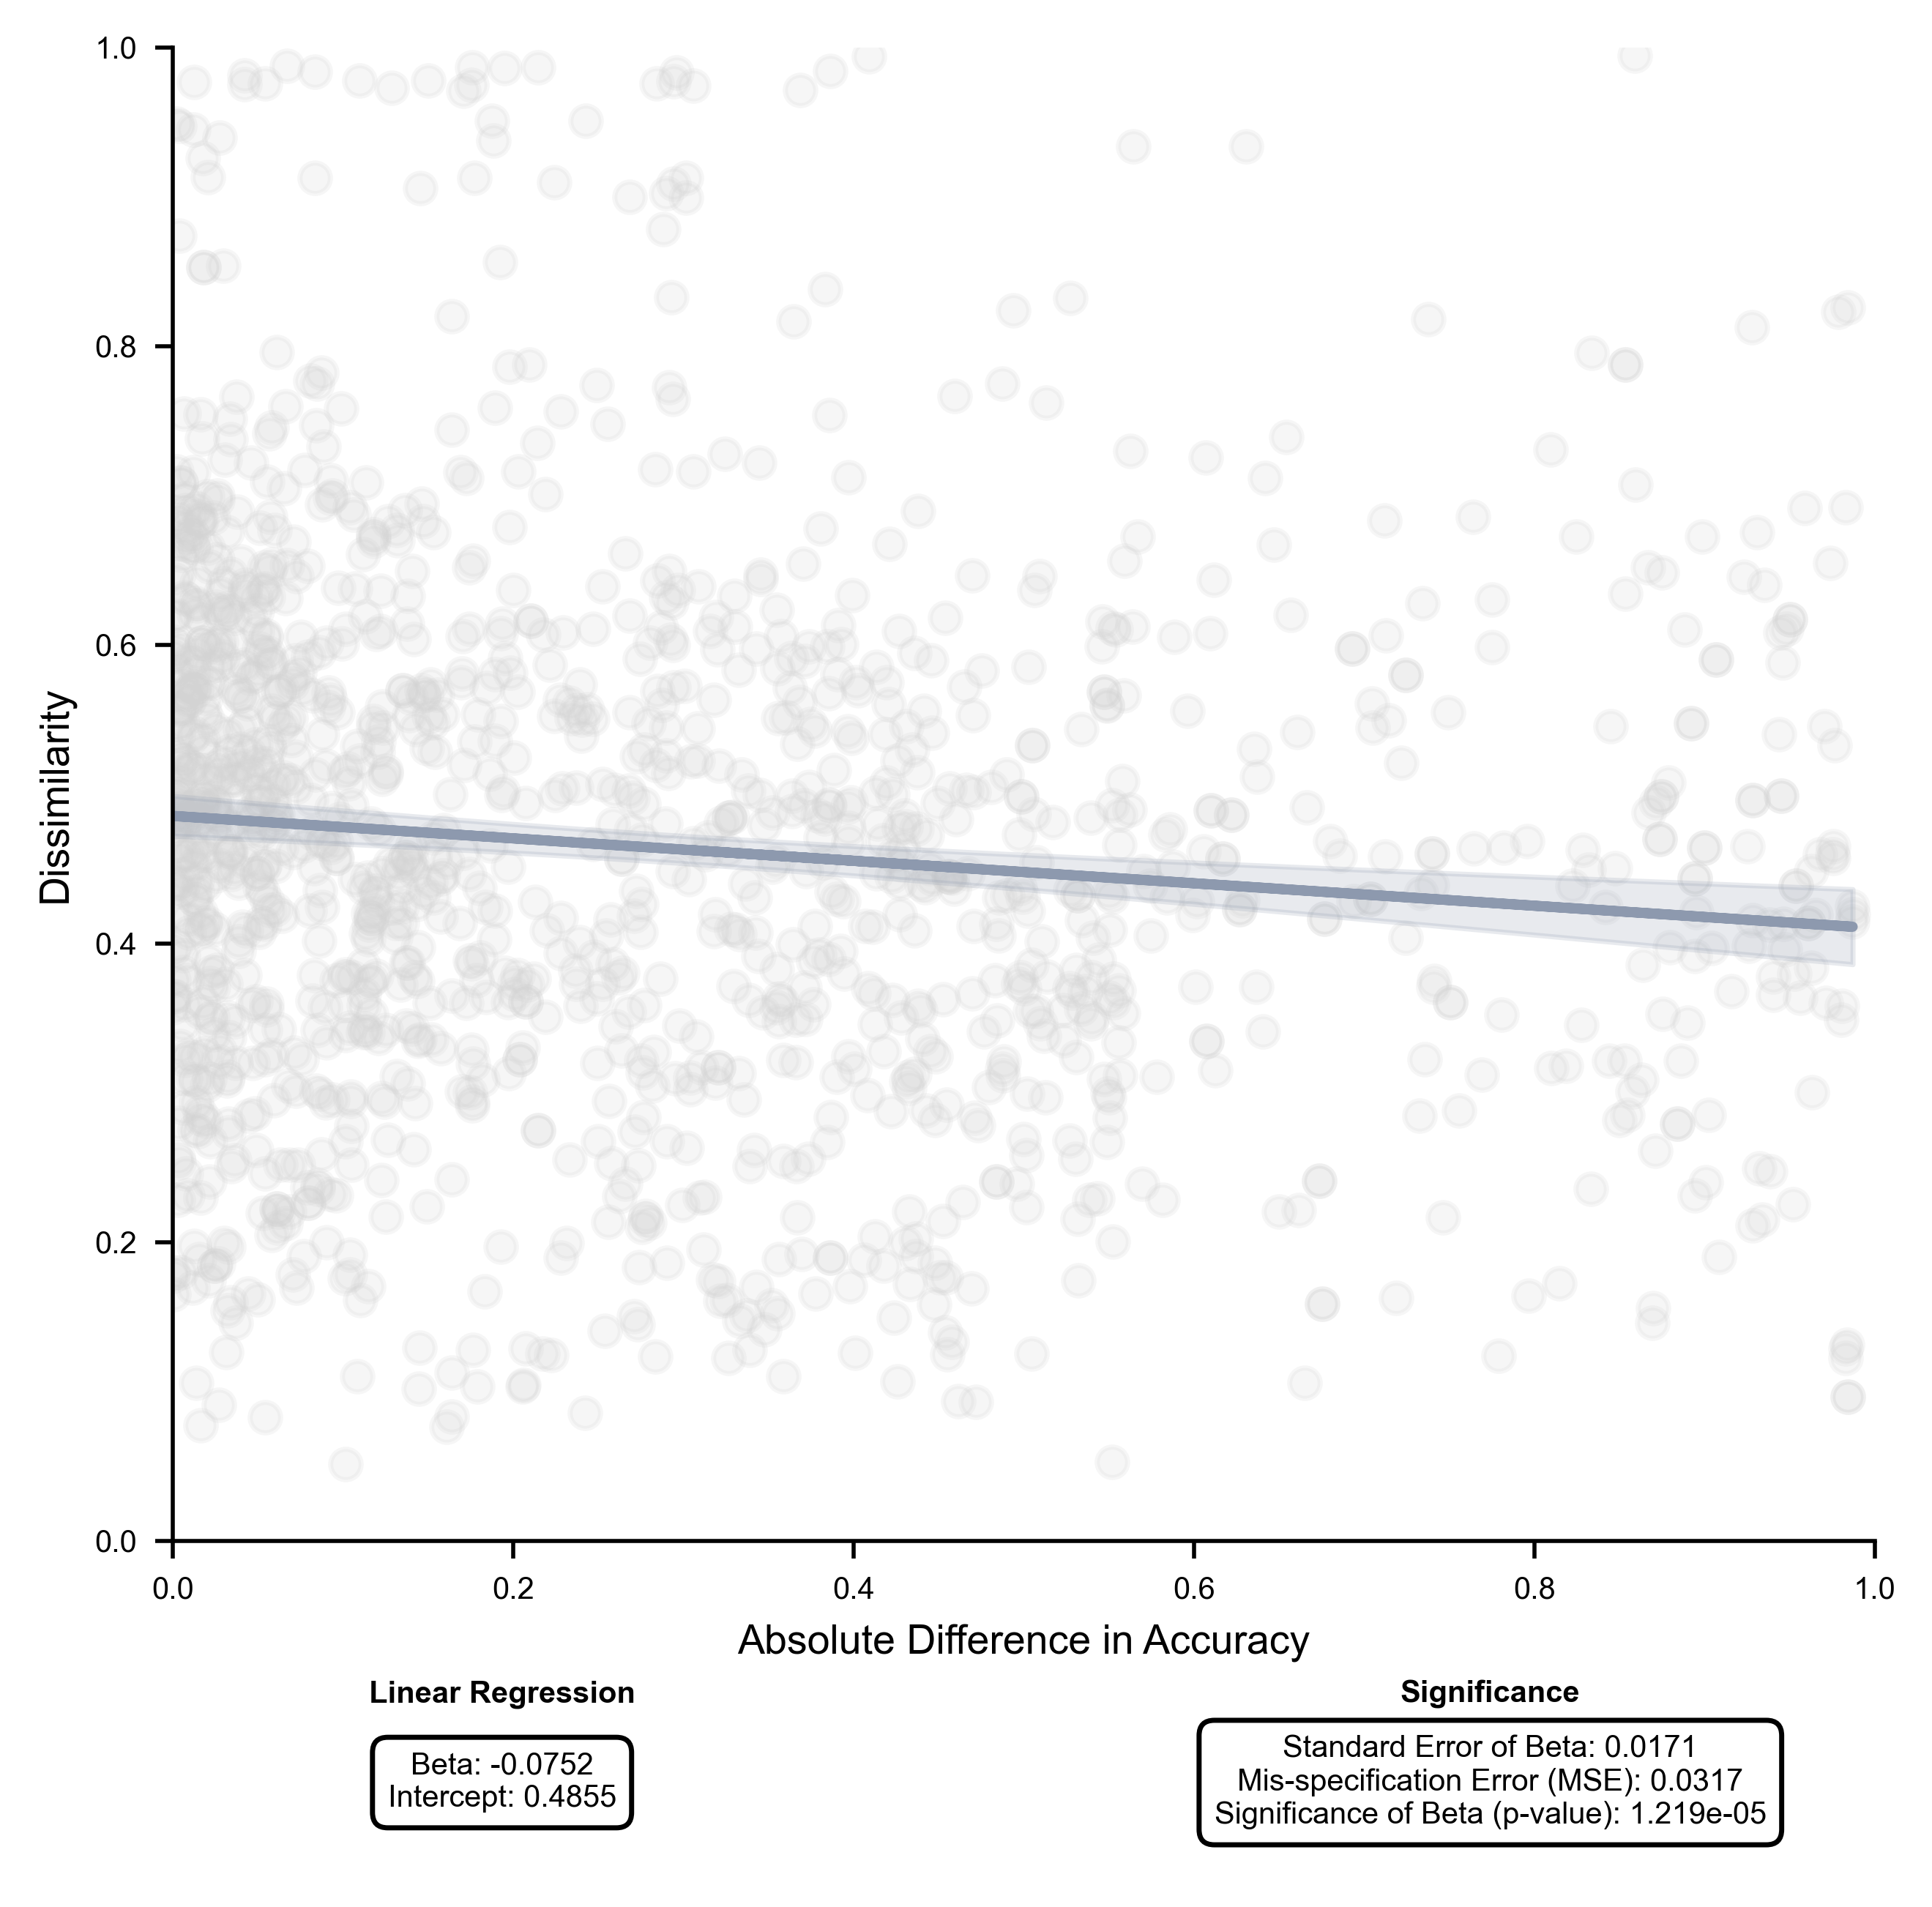

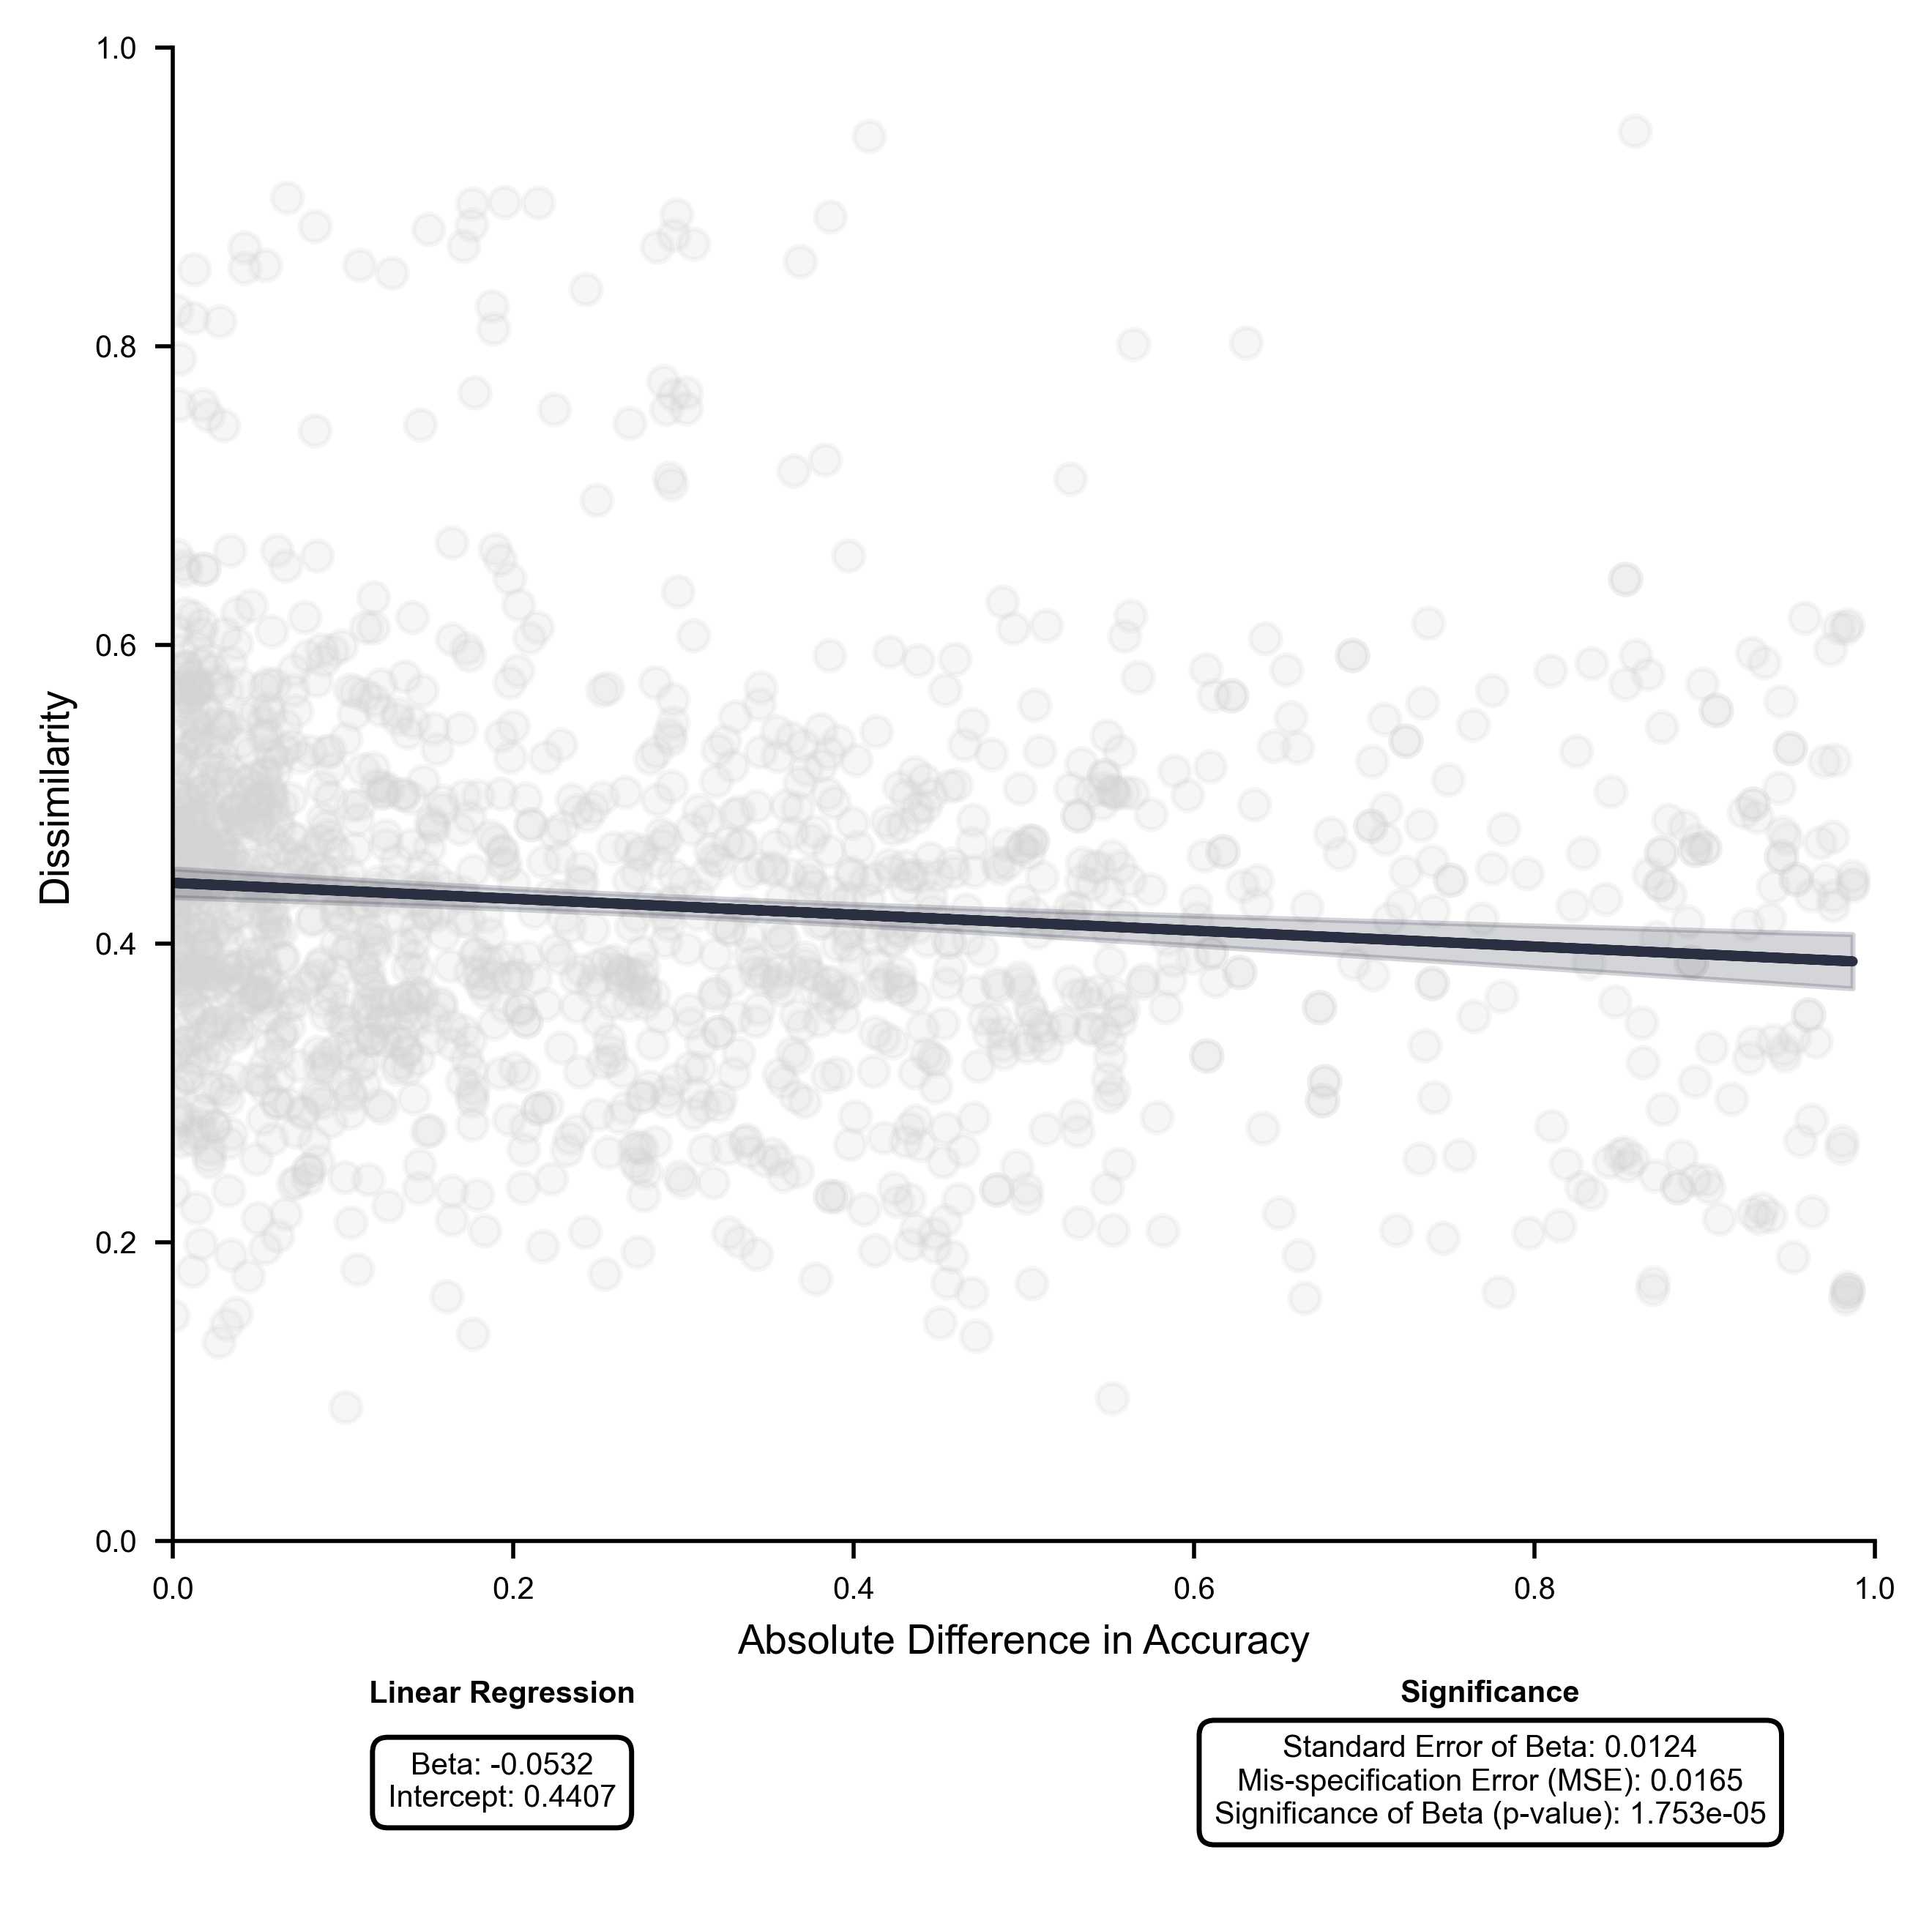

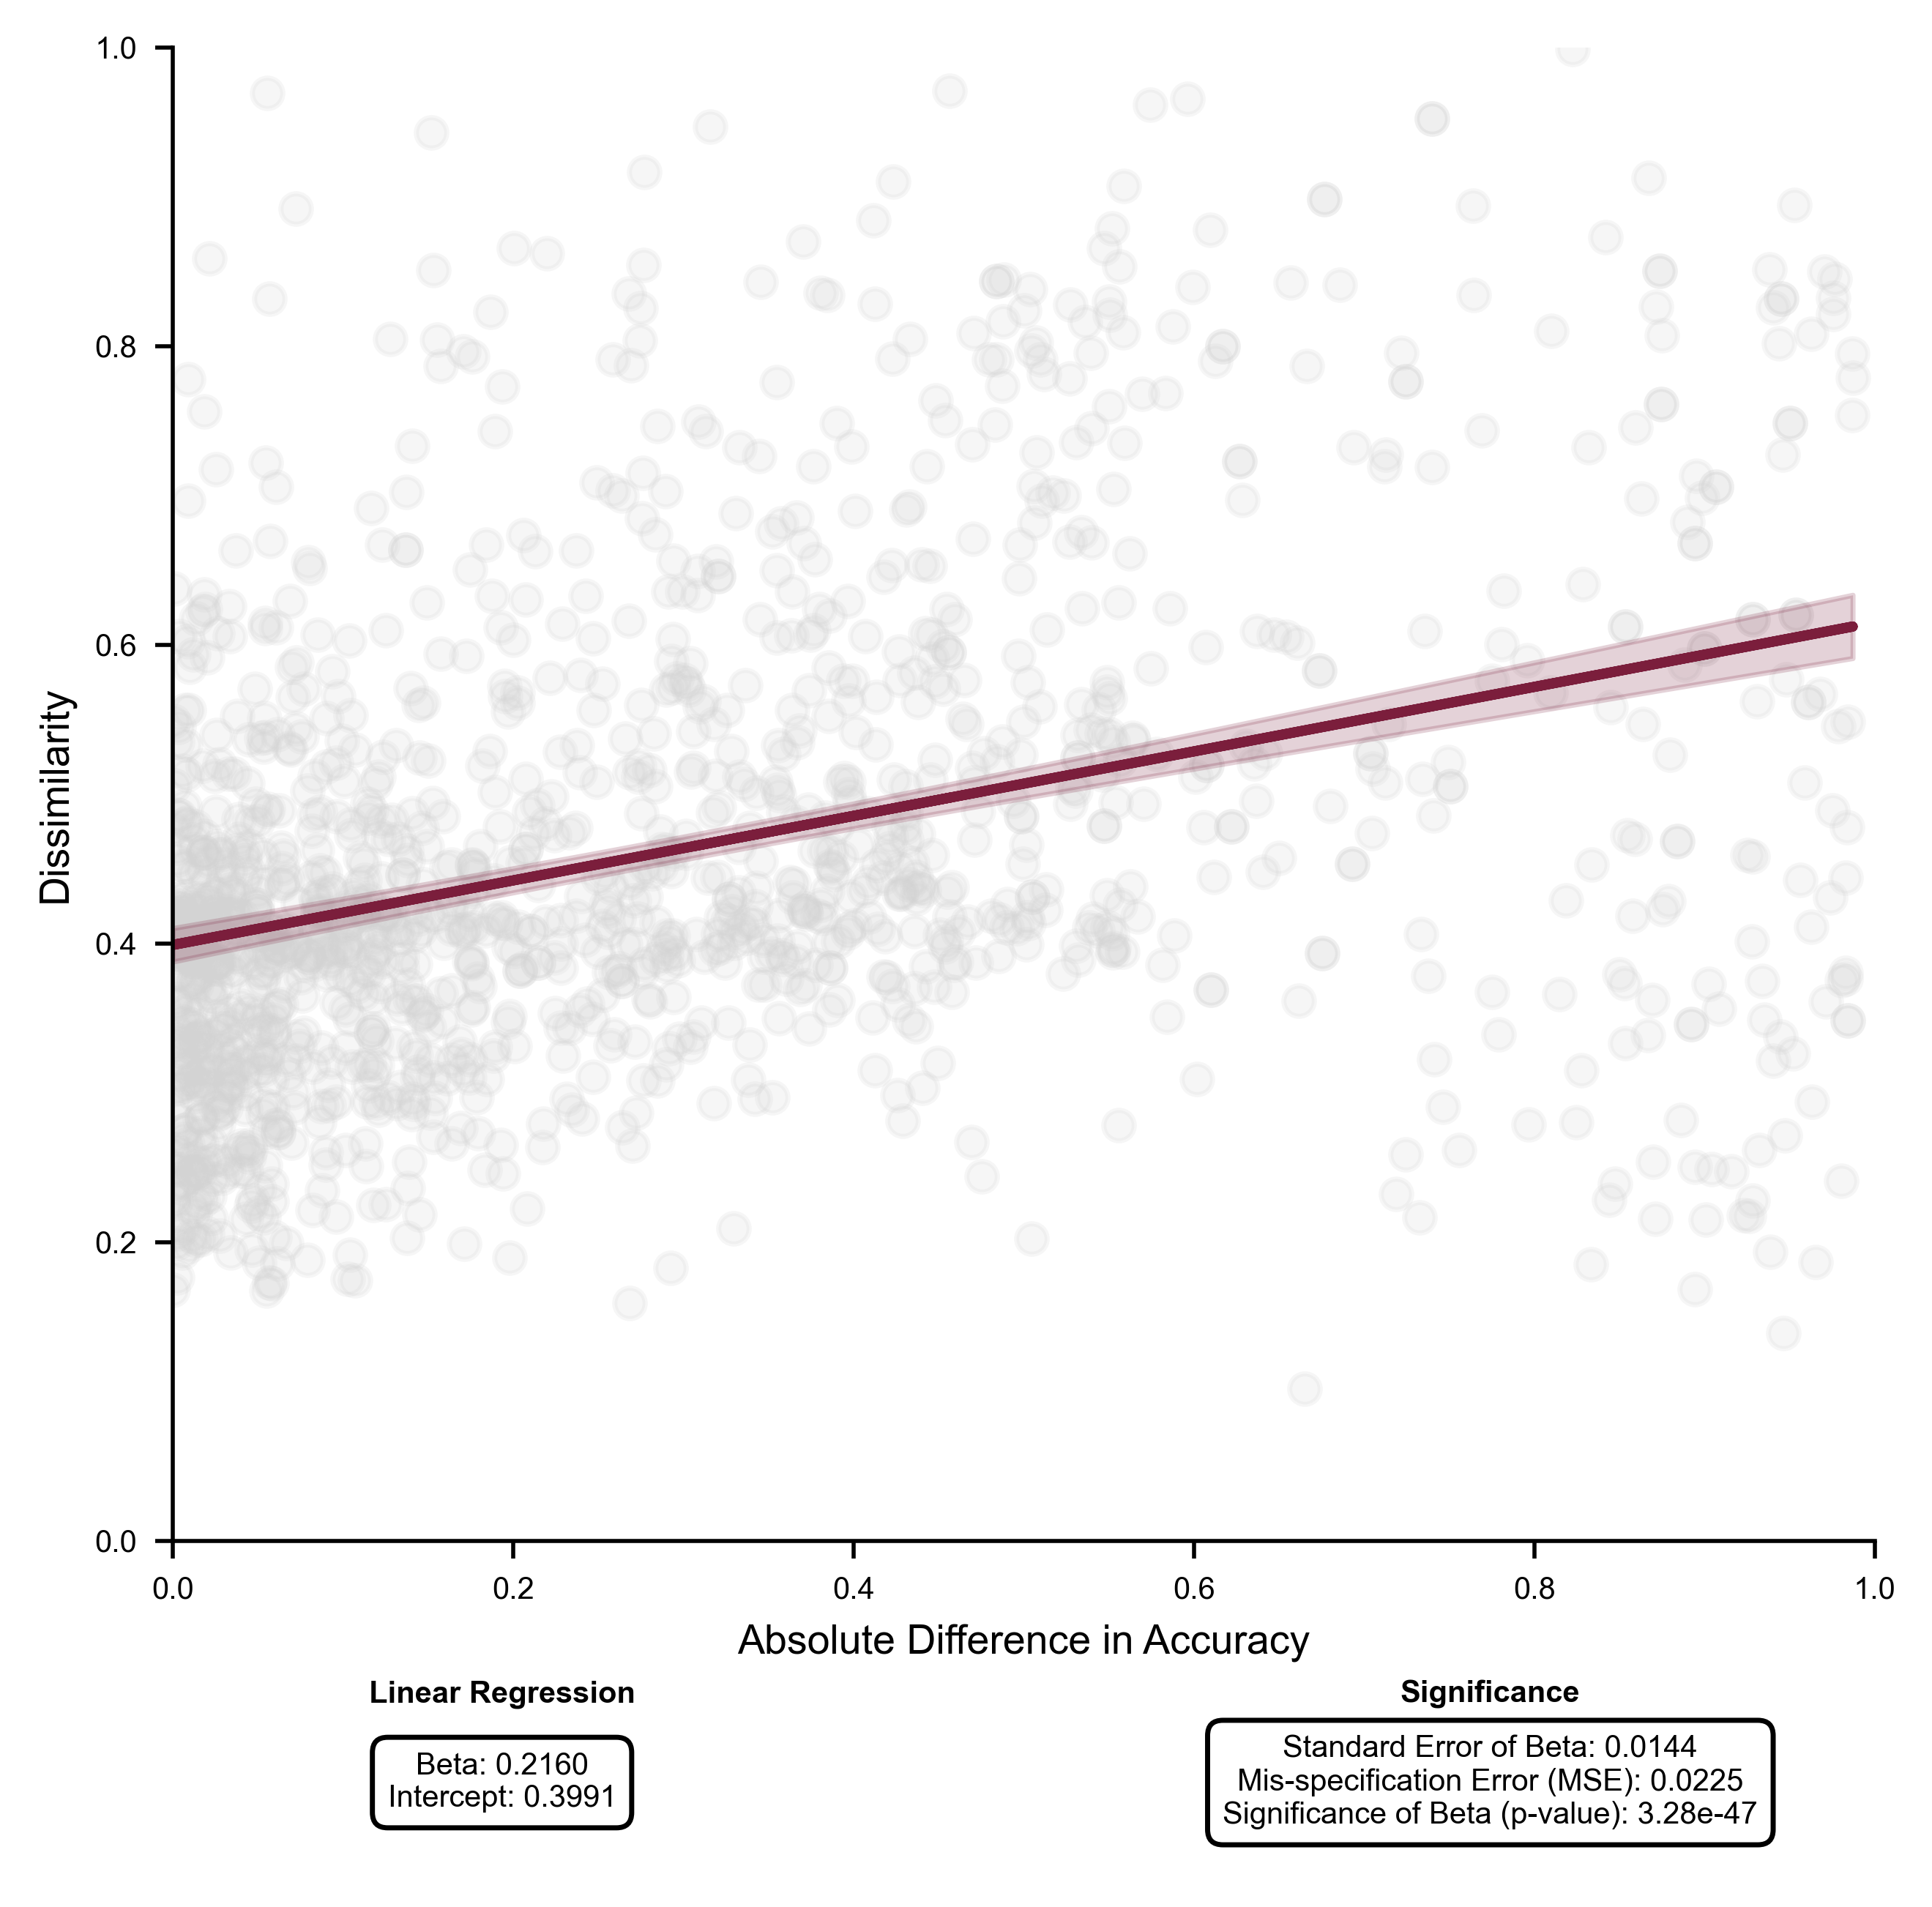

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats  # Importing for t-statistic and p-value calculation

# Assuming dissimilarities_groups, groups_training, and color_mapping_metrics are defined

# X-axis values
x_values = [i * 20 for i in range(6)]

# Measures for dissimilarities and accuracies
measures_plot1 = ["cka", "procrustes", "dsa"]
measures_plot2 = ["accuracy_1", "accuracy_2"]

# Initialize lists and dictionaries to collect data
abs_diff_accuracies_cumulated = []
dissimilarity_values_cumulated = {measure: [] for measure in measures_plot1}
accuracy_values = {
    measure: [] for measure in measures_plot2
}  # Initialize accuracy_values dictionary

# Calculate dissimilarity values and absolute accuracy differences
for group_training in groups_training:
    if (
        "master_frozen" not in group_training
        and "untrained" not in group_training
        and "master_master" not in group_training
        and "pretrain_partial" not in group_training
    ):
        dissimilarities_interpolated = dissimilarities_groups[group_training]

        # Collect accuracy values to calculate absolute differences
        for key in measures_plot2:
            dict_sampling_to_mean_and_errors = dissimilarities_interpolated[key]
            accuracy_values[key] = [
                value[2] for value in dict_sampling_to_mean_and_errors.values()
            ]
            # Flatten the list
            accuracy_values[key] = [
                item for sublist in accuracy_values[key] for item in sublist
            ]

        # Calculate the absolute difference between the two accuracy measures
        abs_diff_accuracies = np.abs(
            np.array(accuracy_values["accuracy_1"])
            - np.array(accuracy_values["accuracy_2"])
        )
        abs_diff_accuracies_cumulated.extend(abs_diff_accuracies.tolist())

        # Plot the dissimilarities against the absolute accuracy difference
        for idx, key in enumerate(measures_plot1):
            dict_sampling_to_mean_and_errors = dissimilarities_interpolated[key]
            dissimilarity_values = [
                value[2] for value in dict_sampling_to_mean_and_errors.values()
            ]
            # Flatten the list
            dissimilarity_values = [
                item for sublist in dissimilarity_values for item in sublist
            ]
            dissimilarity_values_cumulated[key].extend(dissimilarity_values)

# Create a plot for each measure in measures_plot1
for idx, measure in enumerate(measures_plot1):
    # Ensure X and Y have the same length and remove NaNs
    X = np.array(abs_diff_accuracies_cumulated)
    Y = np.array(dissimilarity_values_cumulated[measure])

    # Check for NaN values in X or Y and remove them
    valid_indices = ~np.isnan(X) & ~np.isnan(Y)
    X = X[valid_indices].reshape(-1, 1)
    Y = Y[valid_indices]

    # Perform linear regression
    model = LinearRegression()
    model.fit(X, Y)

    # Predict y values for the regression line
    Y_pred = model.predict(X)

    # Get the slope (beta) and intercept
    beta = model.coef_[0]
    intercept = model.intercept_

    # Compute residuals and their variance
    residuals = Y - Y_pred
    residual_variance = np.var(residuals, ddof=2)

    # Compute variance of X
    X_mean = np.mean(X)
    X_variance = np.sum((X - X_mean) ** 2)

    # Standard error of the slope (beta)
    standard_error_beta = np.sqrt(residual_variance / X_variance)

    # Calculate t-statistic and p-value
    t_statistic = beta / standard_error_beta
    df = len(X) - 2  # degrees of freedom
    p_value = 2 * stats.t.sf(np.abs(t_statistic), df)

    # Mis-specification error (MSE)
    mse = np.mean(residuals**2)

    # Confidence interval for the regression line
    X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred_range = model.predict(X_range)
    se_line = np.sqrt(
        residual_variance * (1 / len(X) + (X_range - X_mean) ** 2 / X_variance)
    )
    ci_upper = y_pred_range.flatten() + 1.96 * se_line.flatten()
    ci_lower = y_pred_range.flatten() - 1.96 * se_line.flatten()

    # Create the main plot
    fig, ax_main = plt.subplots(figsize=(6, 6), dpi=500)

    # Main plot: scatter plot of observations and the regression line
    ax_main.scatter(X, Y, color="lightgray", label="Observations", alpha=0.2)
    ax_main.plot(
        X,
        Y_pred,
        color=color_mapping_metrics[measure],
        label=f"{measure} Regression",
        linewidth=2,
    )

    # Plot the confidence interval
    ax_main.fill_between(
        X_range.flatten(),
        ci_lower.flatten(),
        ci_upper.flatten(),
        color=color_mapping_metrics[measure],
        alpha=0.2,
        label="95% Confidence Interval",
    )

    # Set axis labels and title for the main plot
    ax_main.set_xlabel("Absolute Difference in Accuracy")
    ax_main.set_ylabel("Dissimilarity")
    ax_main.set_xlim(0, 1)
    ax_main.set_ylim(0, 1)

    # Customize axis limits and hide the top and right spines
    ax_main.spines["right"].set_visible(False)
    ax_main.spines["top"].set_visible(False)
    ax_main.spines["left"].set_visible(True)
    ax_main.spines["bottom"].set_visible(True)
    ax_main.grid(False)

    # Add the boxes below the main plot
    # Left box for "Linear Regression"
    fig.subplots_adjust(bottom=0.2)  # Adjust bottom space to fit the boxes
    ax_lr = fig.add_axes([0.1, 0.05, 0.35, 0.2])  # [left, bottom, width, height]
    ax_lr.axis("off")  # Turn off axes for the metrics plot
    ax_lr.text(
        0.5, 0.4, "Linear Regression", ha="center", va="center", fontweight="bold"
    )
    ax_lr.text(
        0.5,
        0.2,
        f"Beta: {beta:.4f}\nIntercept: {intercept:.4f}",
        ha="center",
        va="center",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
    )

    # Right box for "Significance"
    ax_significance = fig.add_axes(
        [0.55, 0.05, 0.35, 0.2]
    )  # [left, bottom, width, height]
    ax_significance.axis("off")  # Turn off axes for the metrics plot
    ax_significance.text(
        0.5, 0.4, "Significance", ha="center", va="center", fontweight="bold"
    )
    ax_significance.text(
        0.5,
        0.2,
        (
            f"Standard Error of Beta: {standard_error_beta:.4f}\n"
            f"Mis-specification Error (MSE): {mse:.4f}\n"
            f"Significance of Beta (p-value): {p_value:.4g}"
        ),
        ha="center",
        va="center",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
    )

    # Save the plot if needed
    plt.savefig(f"{measure}_dissimilarity_vs_accuracy.png", dpi=300)

    # Show the plot
    plt.show()

In [11]:
group_pairs_master = find_group_pairs_master(config, taskset)
diss_cc = get_dissimilarities_shared_task_shared_curriculum(
    group_pairs_master, dissimilarities_groups, x_values
)

cka


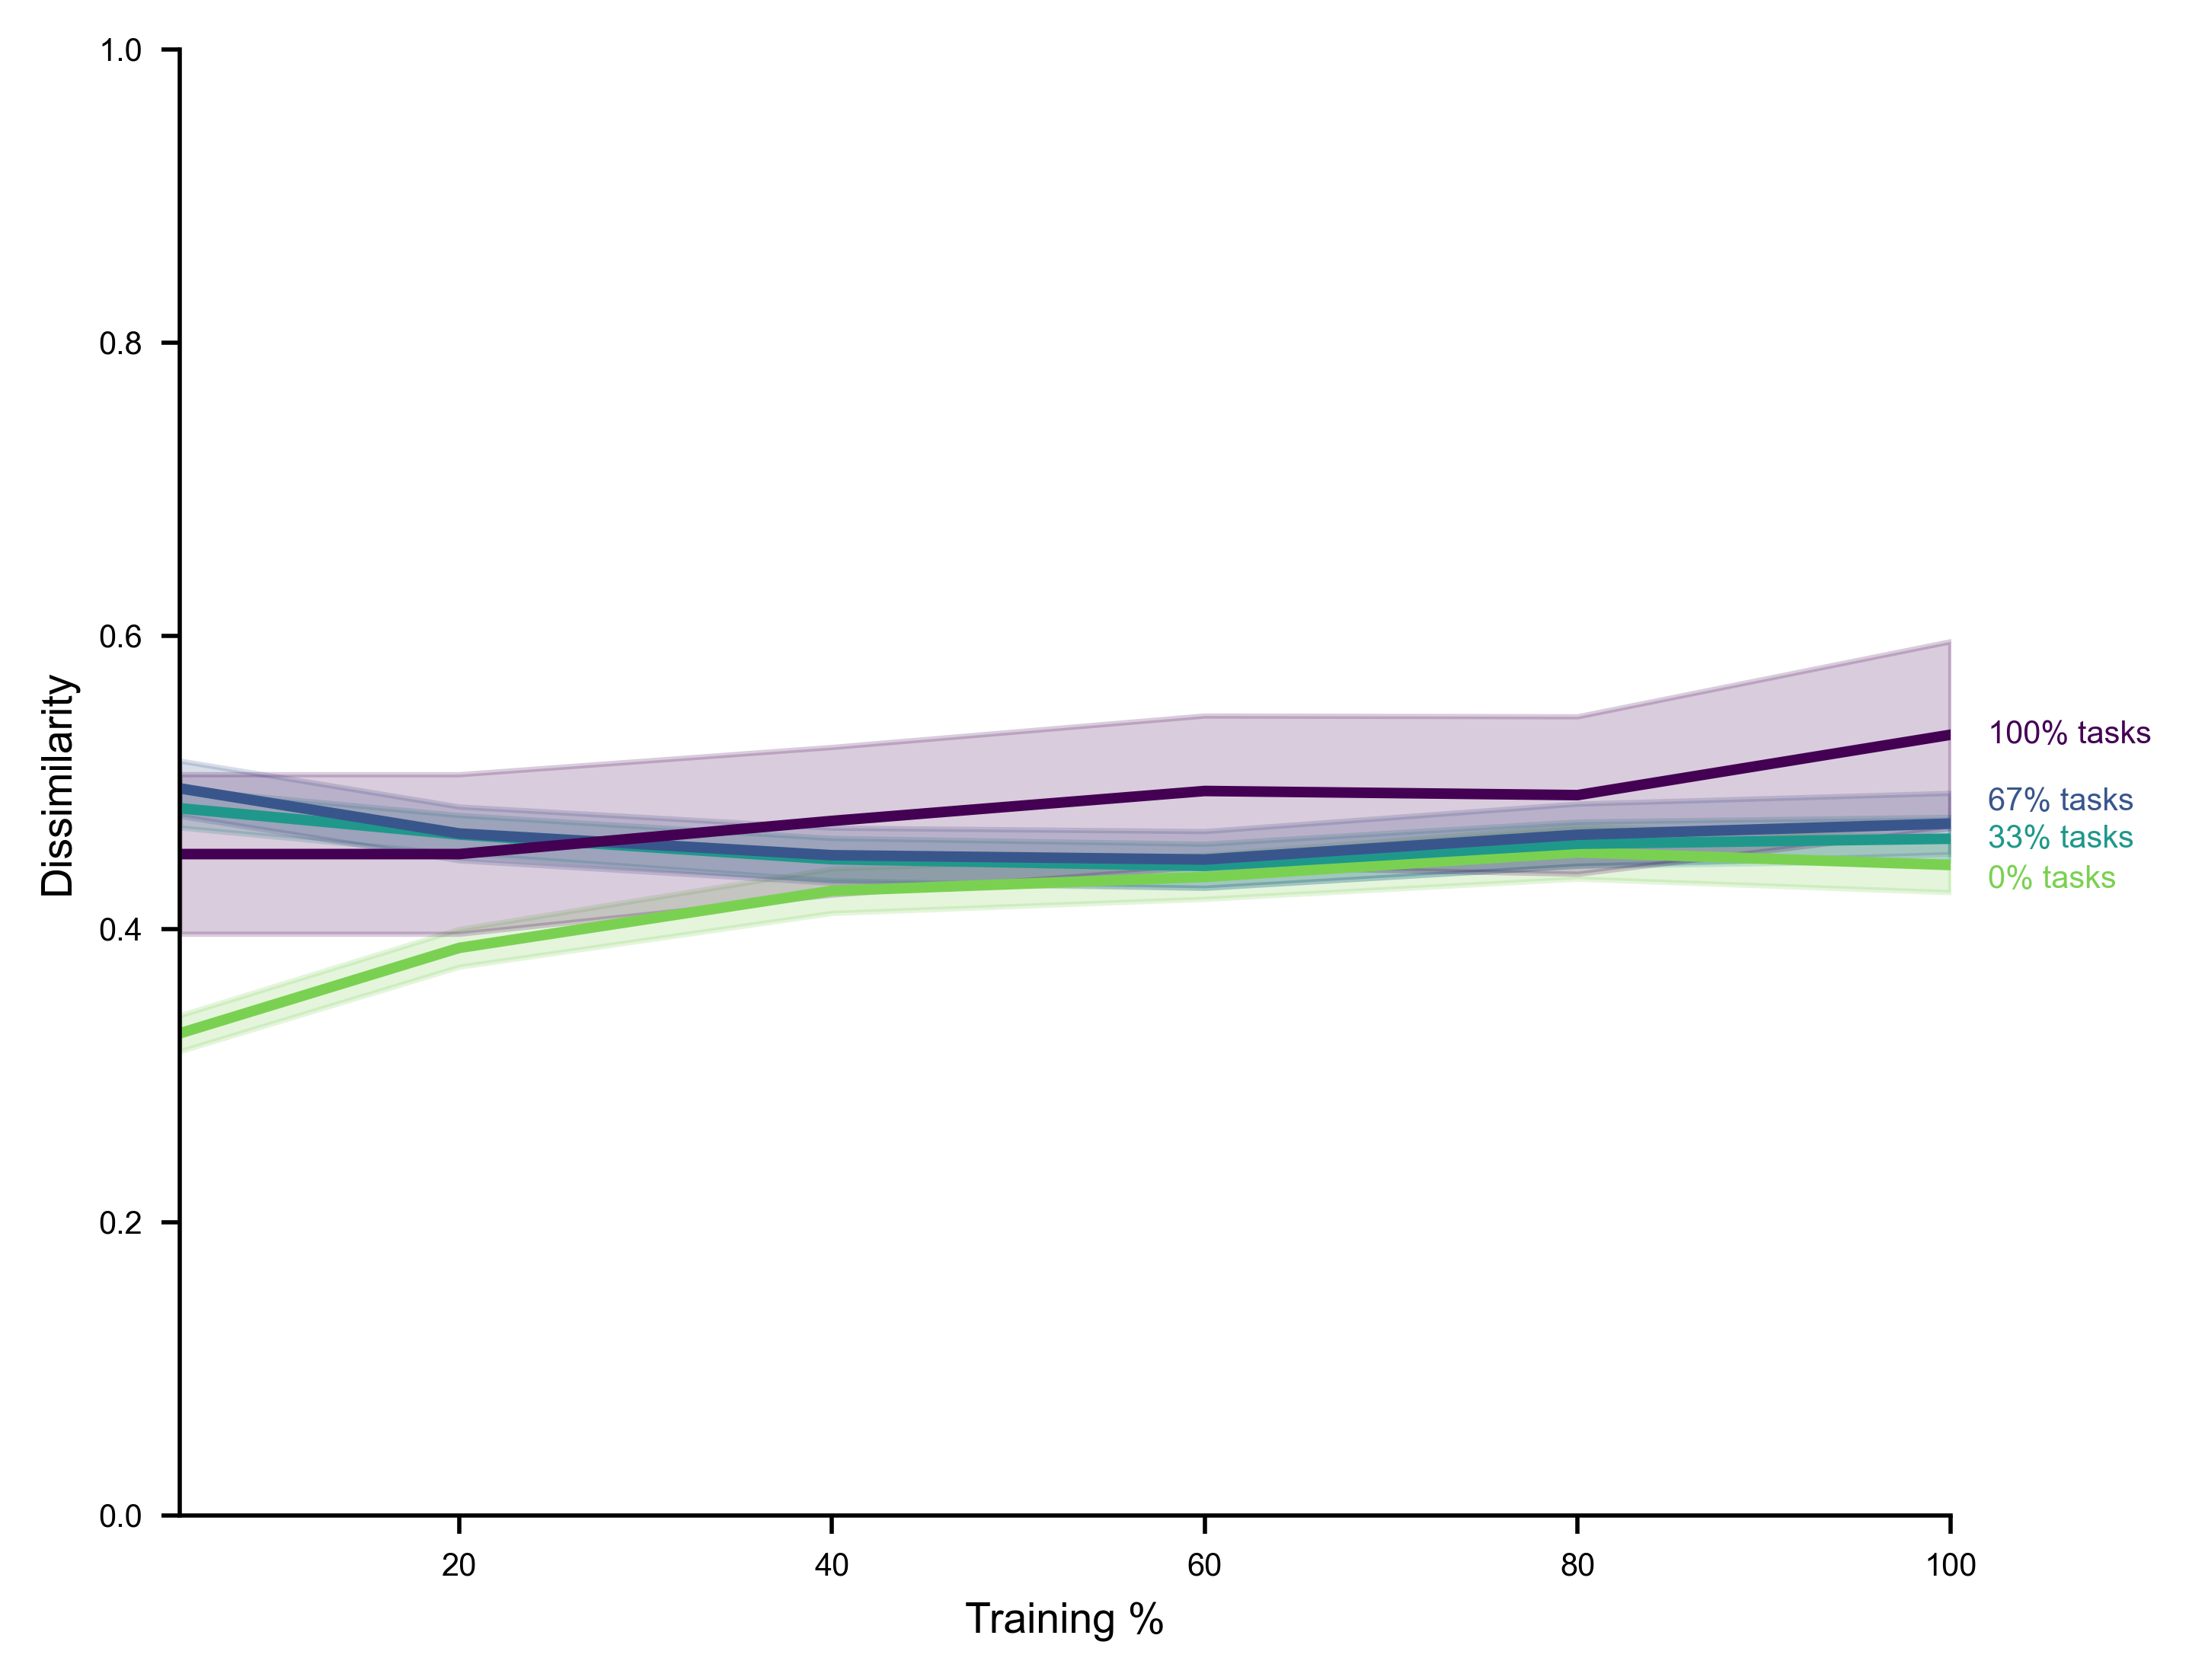

dsa


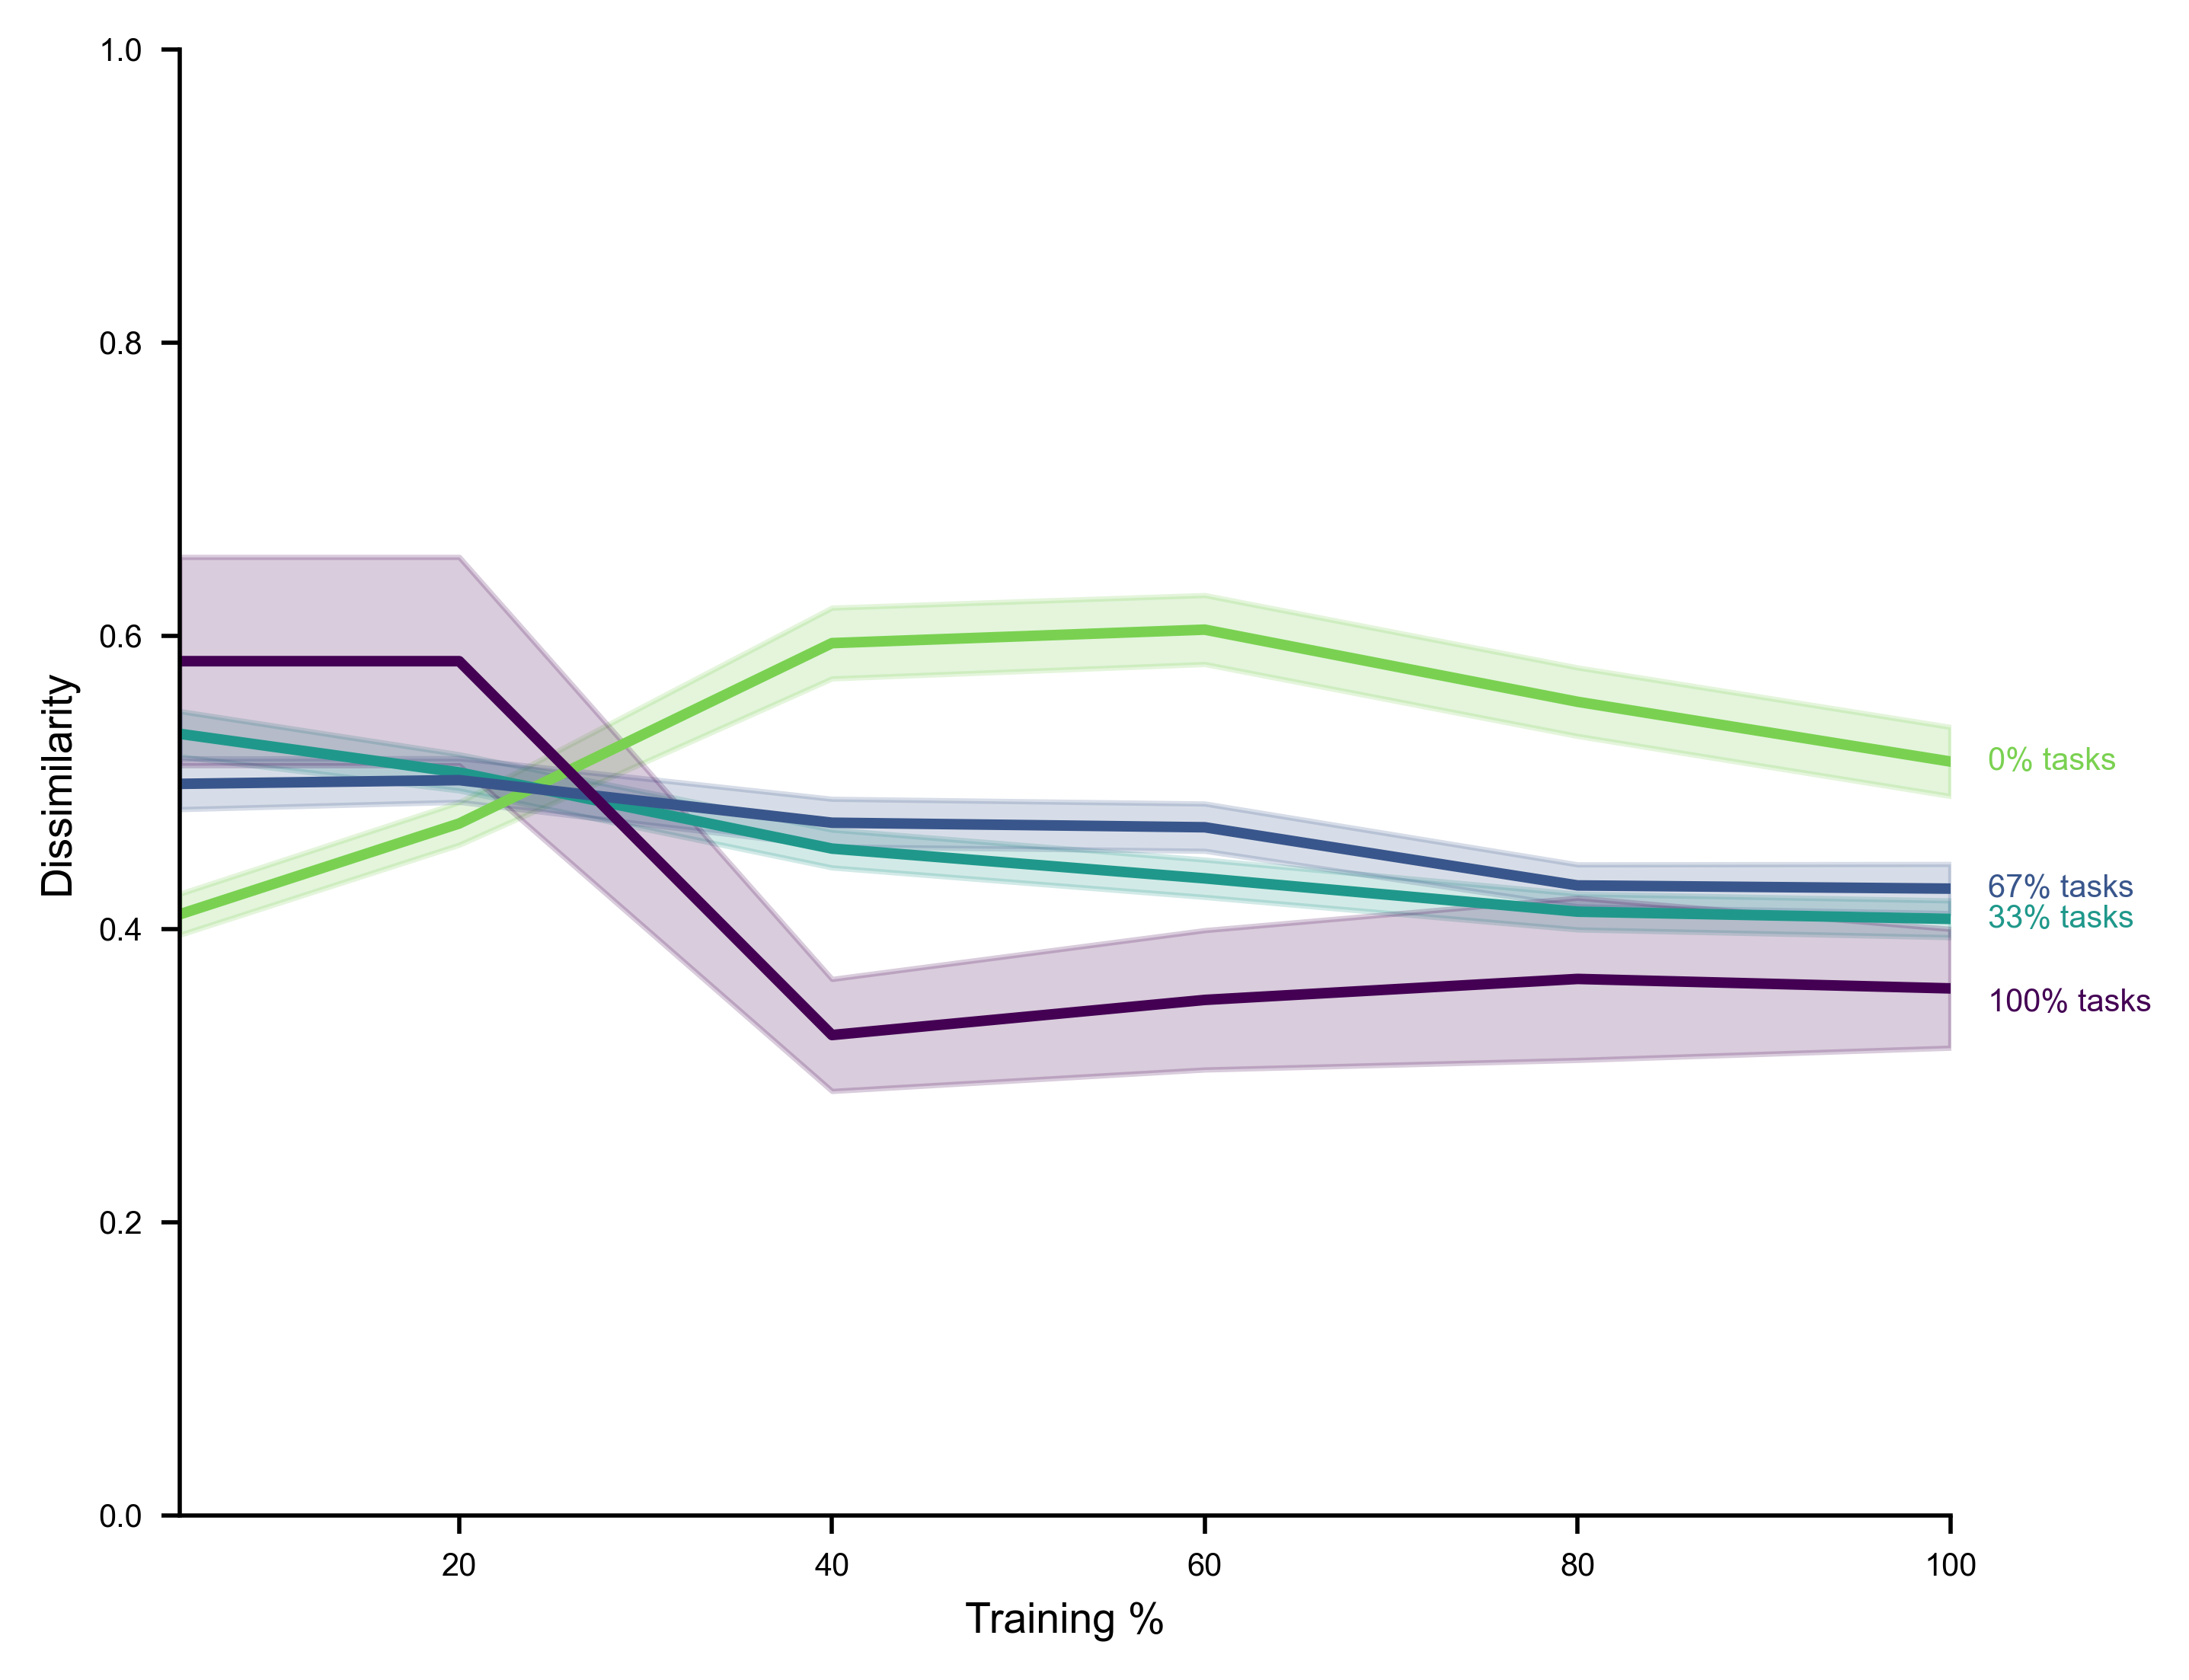

procrustes


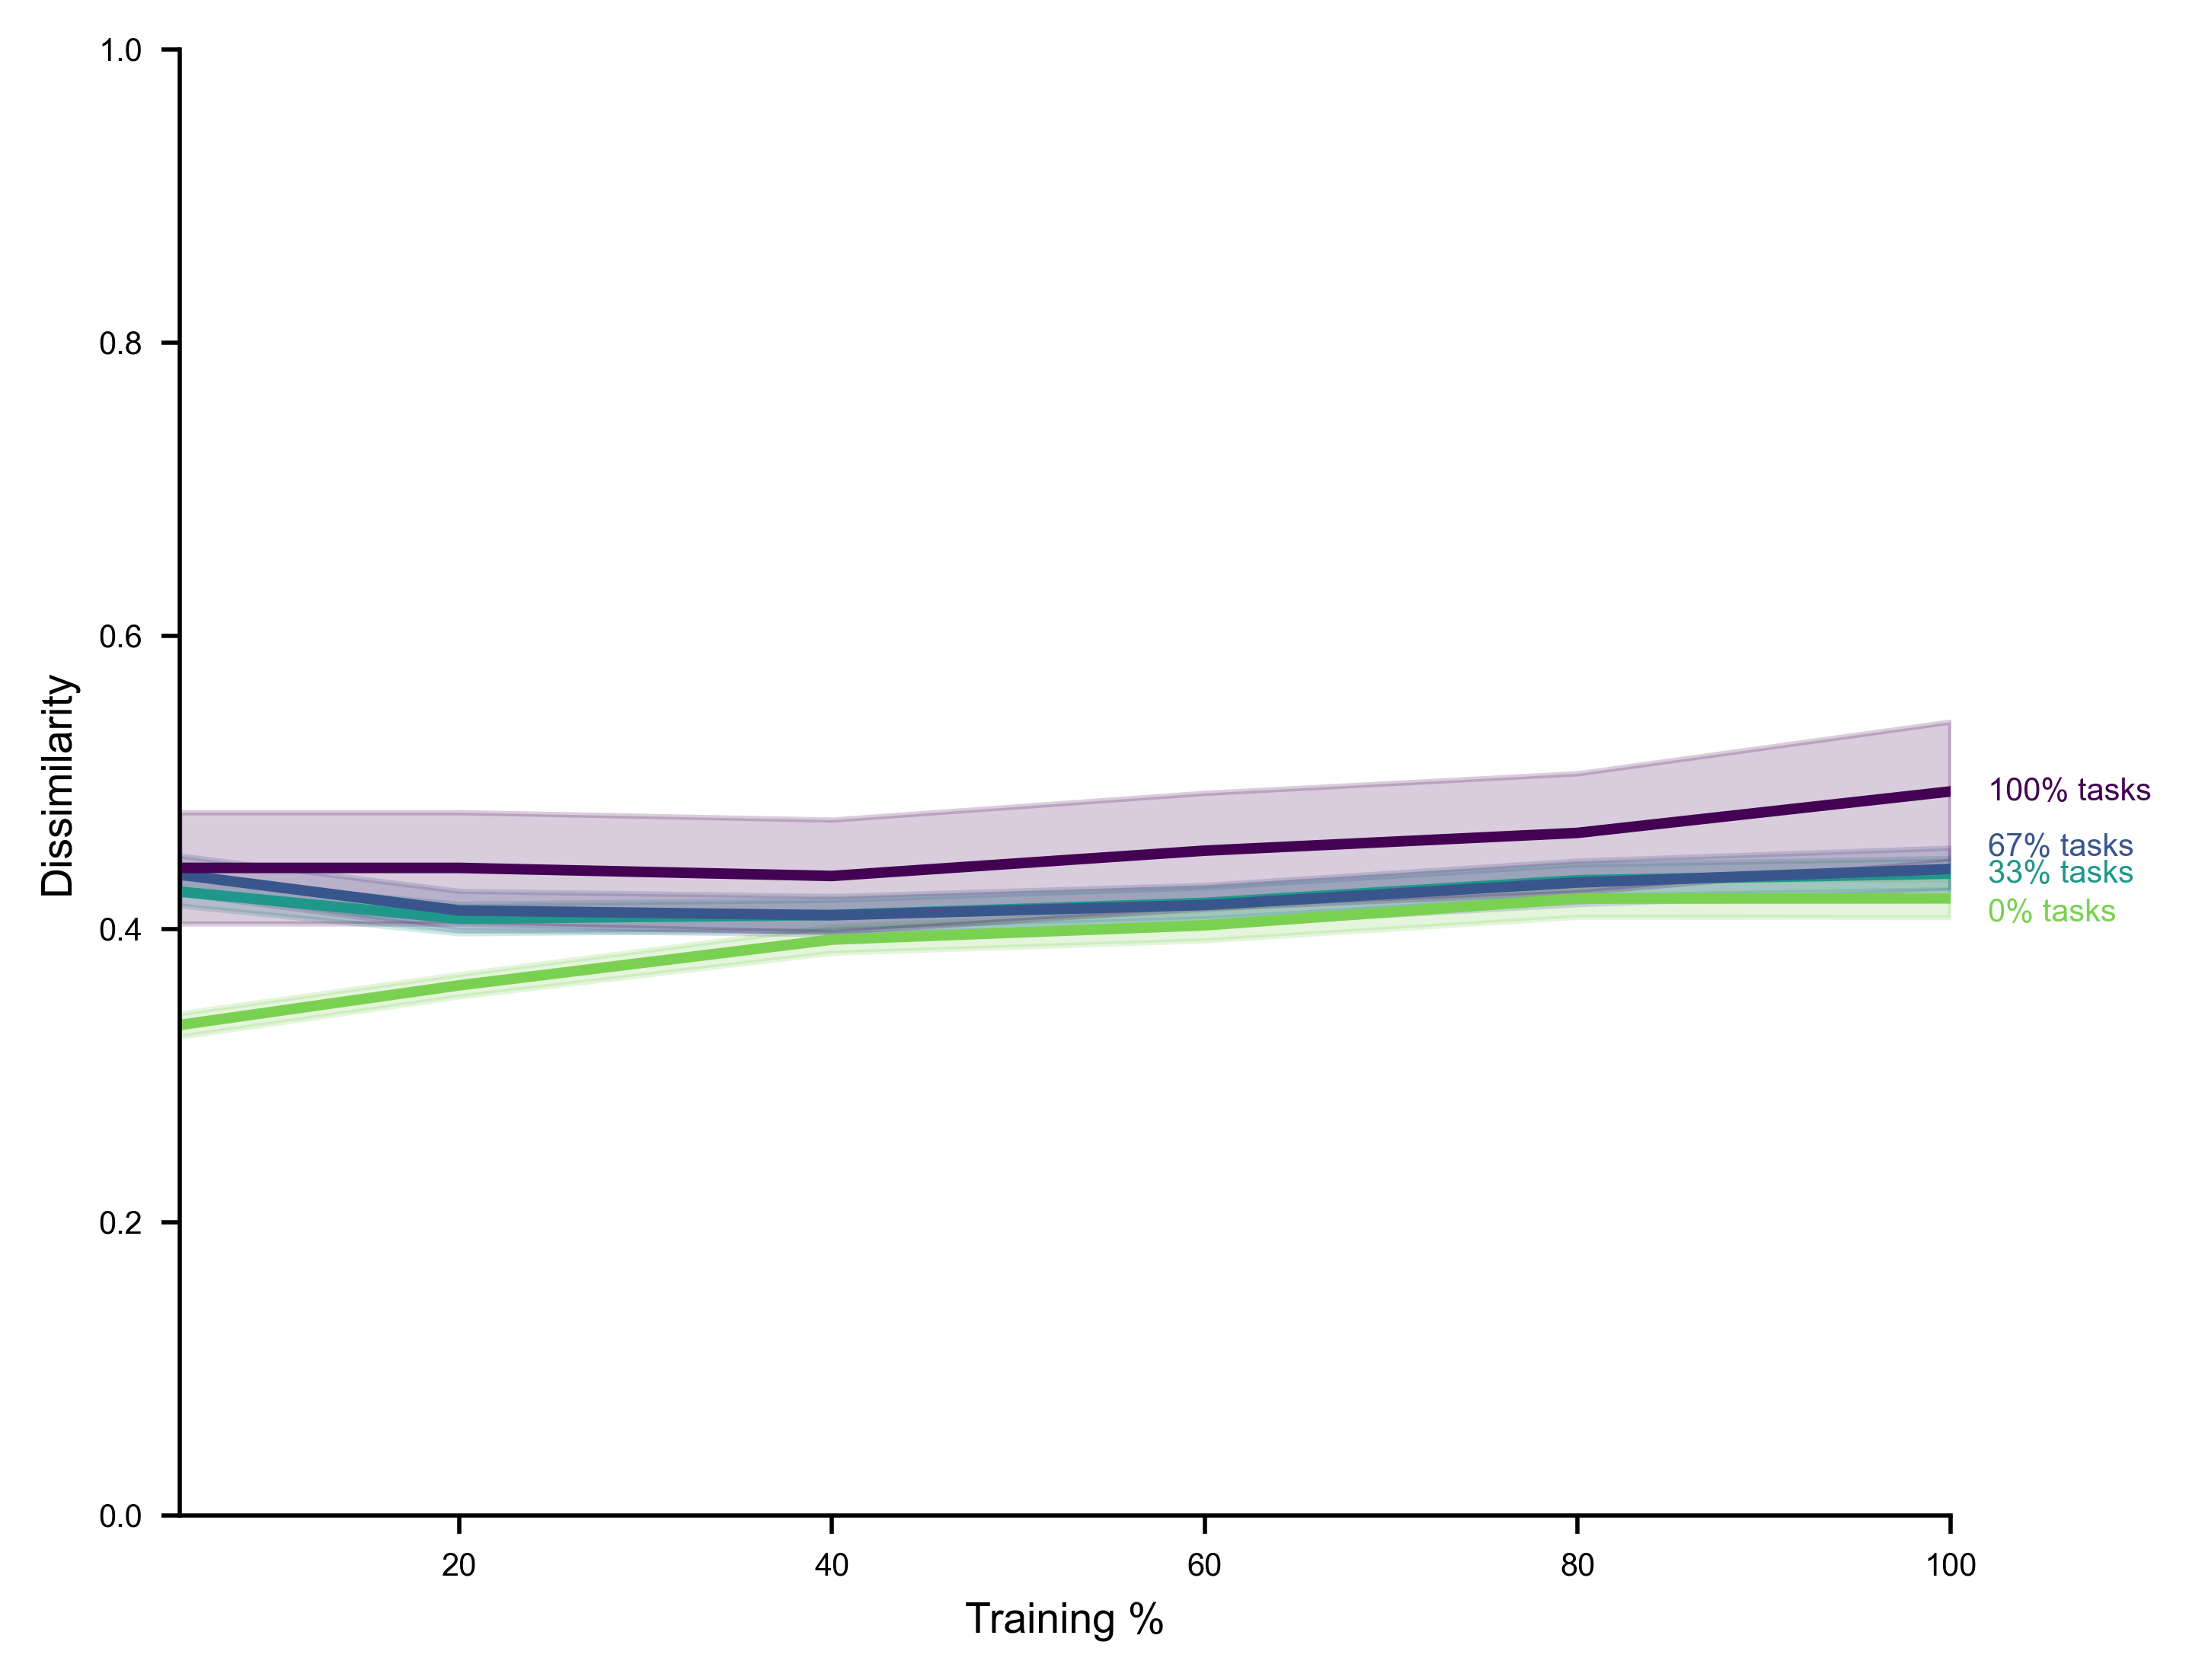

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
# Define font sizes and styles for consistency
SIZE_DEFAULT = 6
SIZE_LARGE = 8
plt.rc("font", family="Arial")
plt.rc("font", weight="normal")
plt.rc("font", size=SIZE_DEFAULT)
plt.rc("axes", titlesize=SIZE_LARGE)
plt.rc("axes", labelsize=SIZE_LARGE)
plt.rc("xtick", labelsize=SIZE_DEFAULT)
plt.rc("ytick", labelsize=SIZE_DEFAULT)

# Normalize the number of shared tasks to range between 0 and 1 for color mapping
all_shared_tasks = [shared for measure in diss_cc for shared in diss_cc[measure]]
min_shared = min(all_shared_tasks)
max_shared = max(all_shared_tasks)

# Create a colormap ranging from light to dark red
cmap = cm.viridis_r
offset = 0.2


# Plot each measure
for measure in diss_cc:
    print(measure)
    fig, ax = plt.subplots(
        figsize=(6, 5), dpi=500
    )  # Create a new figure for each measure

    # Plot each shared task count
    offsets_dsa =[0,0,0, -0.01]
    offsets_cka = [-0.01,0,0.015,0]
    shared_order = [0, 33, 66, 100]
    for shared in sorted(diss_cc[measure].keys()):  # Sort by shared tasks for plotting
        x_new, y_new, y_new_std = diss_cc[measure][shared]

        # Get the color from the colormap
        # Normalize shared task count to get a color, with the offset to avoid very light colors
        norm_shared = offset + (shared - min_shared) / (max_shared - min_shared) * (
            1 - offset
        )
        color = cmap(norm_shared)  # Get the color from the colormap

        # Plot with the determined color
        ax.plot([5] + x_new[1:], y_new, color=color, linewidth=2)

        # Plot the standard deviation as a shaded region
        ax.fill_between(
            [5] + x_new[1:],
            np.array(y_new) - np.array(y_new_std),
            np.array(y_new) + np.array(y_new_std),
            color=color,
            alpha=0.2,  # Transparency for the shaded area
        )

        # Annotate each curve with its label slightly to the right of the last point
        if measure == "dsa":
            ax.text(
                x_new[-1] * 1.02,  # Adjust x position slightly to the right
                y_new[-1] + offsets_dsa[shared_order.index(int(shared))],  # Last y value
                f"{shared:.0f}% tasks",
                color=color,
                horizontalalignment="left",
                verticalalignment="center",
            )
        else:
            ax.text(
                x_new[-1] * 1.02,  # Adjust x position slightly to the right
                y_new[-1] + offsets_cka[shared_order.index(int(shared))],  # Last y value
                f"{shared:.0f}% tasks",
                color=color,
                horizontalalignment="left",
                verticalalignment="center",
            )

    # Set axis labels
    ax.set_xlabel("Training %")
    ax.set_ylabel("Dissimilarity")

    # Customize plot limits
    ax.set_ylim(0, 1)  # Adjust this as needed
    ax.set_xlim(
        5, max(x_new)
    )  # Ensure space on the right side of the plot for labels

    # Hide all but the bottom and left spines (axis lines)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")

    # Set title
    plt.show()